In [1]:
import re
import time
import math
import joblib
import nltk

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

import seaborn as sns
sns.set_style('darkgrid')

from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

print("Libraries Loaded!")

Libraries Loaded!


### Getting the data

In [2]:
train_varient = pd.read_csv("../input/train_variants")
train_text = pd.read_csv("../input/train_text", sep="\|\|", engine="python", names=["ID", "TEXT"], skiprows=1)
data = pd.merge(train_varient, train_text, on="ID", how="left")

print("DataFrame Loaded!")
print("=================")
print(f"After Merging variants and text: {data.shape[1]} columns = {data.columns.values} and {data.shape[0]} rows")

DataFrame Loaded!
After Merging variants and text: 5 columns = ['ID' 'Gene' 'Variation' 'Class' 'TEXT'] and 3321 rows


### A Quick look at our data

In [3]:
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

- ID : the id of the row used to link the mutation to the clinical evidence
- Gene : the gene where this genetic mutation is located
- Variation : the aminoacid change for this mutations
- Class : 1-9 the class this genetic mutation has been classified on
- TEXT : Research content corresponding to Gene and variance

264 unique category in Gene feature


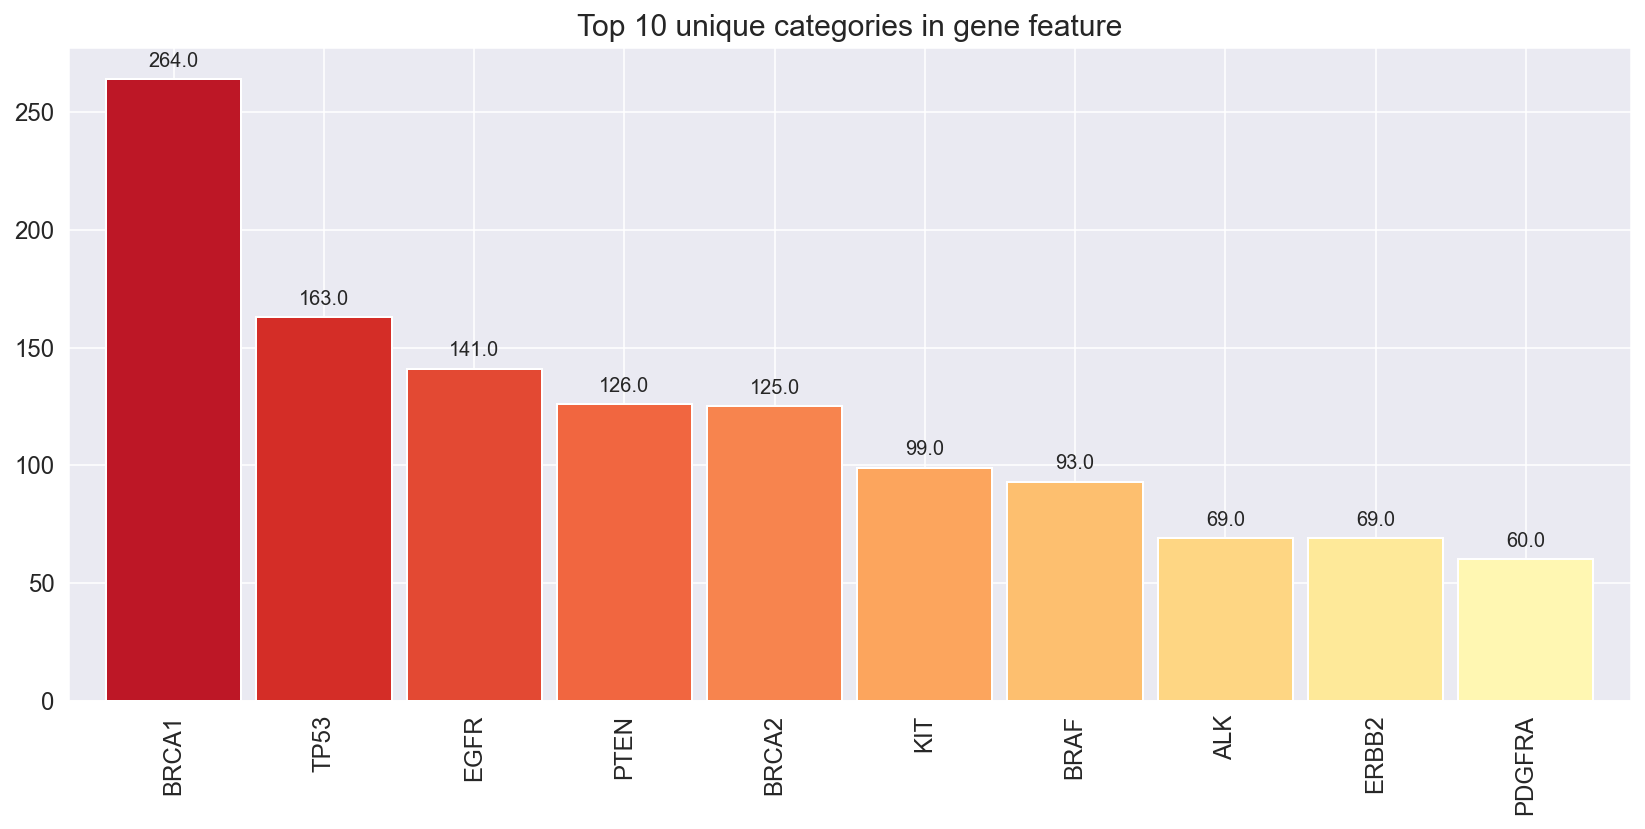

In [4]:
print(f"{len(data['Gene'].unique())} unique category in Gene feature")

plt.subplots(figsize=(14, 6))
ax = data['Gene'].value_counts().sort_values(ascending=False)[:10].plot.bar(
     width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Top 10 unique categories in gene feature")
plt.show()

2996 unique category in variance feature


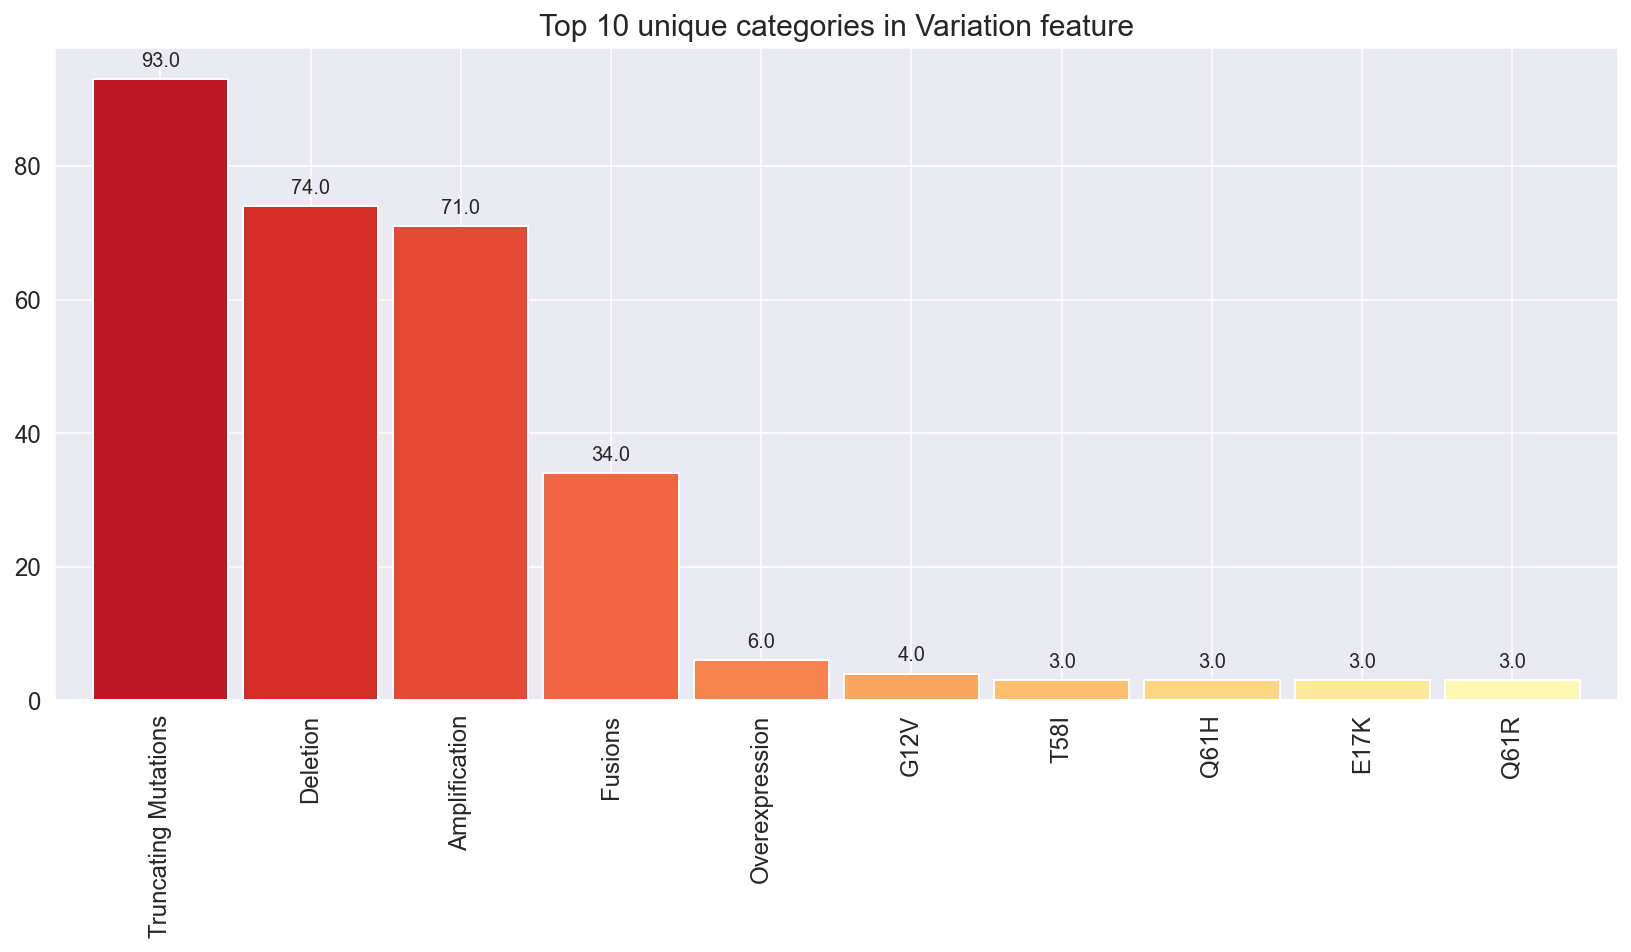

In [5]:
print(f"{len(data['Variation'].unique())} unique category in variance feature")

plt.subplots(figsize=(14, 6))
ax = data['Variation'].value_counts().sort_values(ascending=False)[:10].plot.bar(
     width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Top 10 unique categories in Variation feature")
plt.show()

### Let's see null values ?

In [6]:
data[data.isnull().any(1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [6]:
data.loc[data['TEXT'].isnull(), 'TEXT'] = data['Gene'] + " " + data['Variation']

In [7]:
data[data.ID == 1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

### Clean TEXT 

In [8]:
# loading stopwords from nltk library
stop_words = set(stopwords.words('english'))

def nlp_text_preprocessing(x):
    string = ""
    # Replace every special character with space
    x = re.sub('[^a-zA-Z0-9\n]', ' ', x)
    # Replace multiple space with single space
    x = re.sub('\s+', ' ', x)
    # replace all the capital latters into smaller letters
    x = x.lower()

    # removing all the stopwords from text
    for word in x.split():
        if not word in stop_words:
            string += word + " "

    x = string
    return x

In [9]:
for i in range(len(data['TEXT'])):
    data['TEXT'][i] = nlp_text_preprocessing(data['TEXT'][i])

In [11]:
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

### Splitting dataset into train, cross validation and test dataset's 

### (64:16:20)

In [10]:
y = data['Class'].values
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2, stratify =y_train, random_state=1)

print(f"        Number of datapoints in training data : [{X_train.shape[0]}]")
print(f"Number of datapoints of cross validation data : [{X_cv.shape[0]}]")
print(f"            Number of datapoints in test data : [{X_test.shape[0]}]")

        Number of datapoints in training data : [2124]
Number of datapoints of cross validation data : [532]
            Number of datapoints in test data : [665]


#### Distributions of 'Class' in train, cv, test dataset's

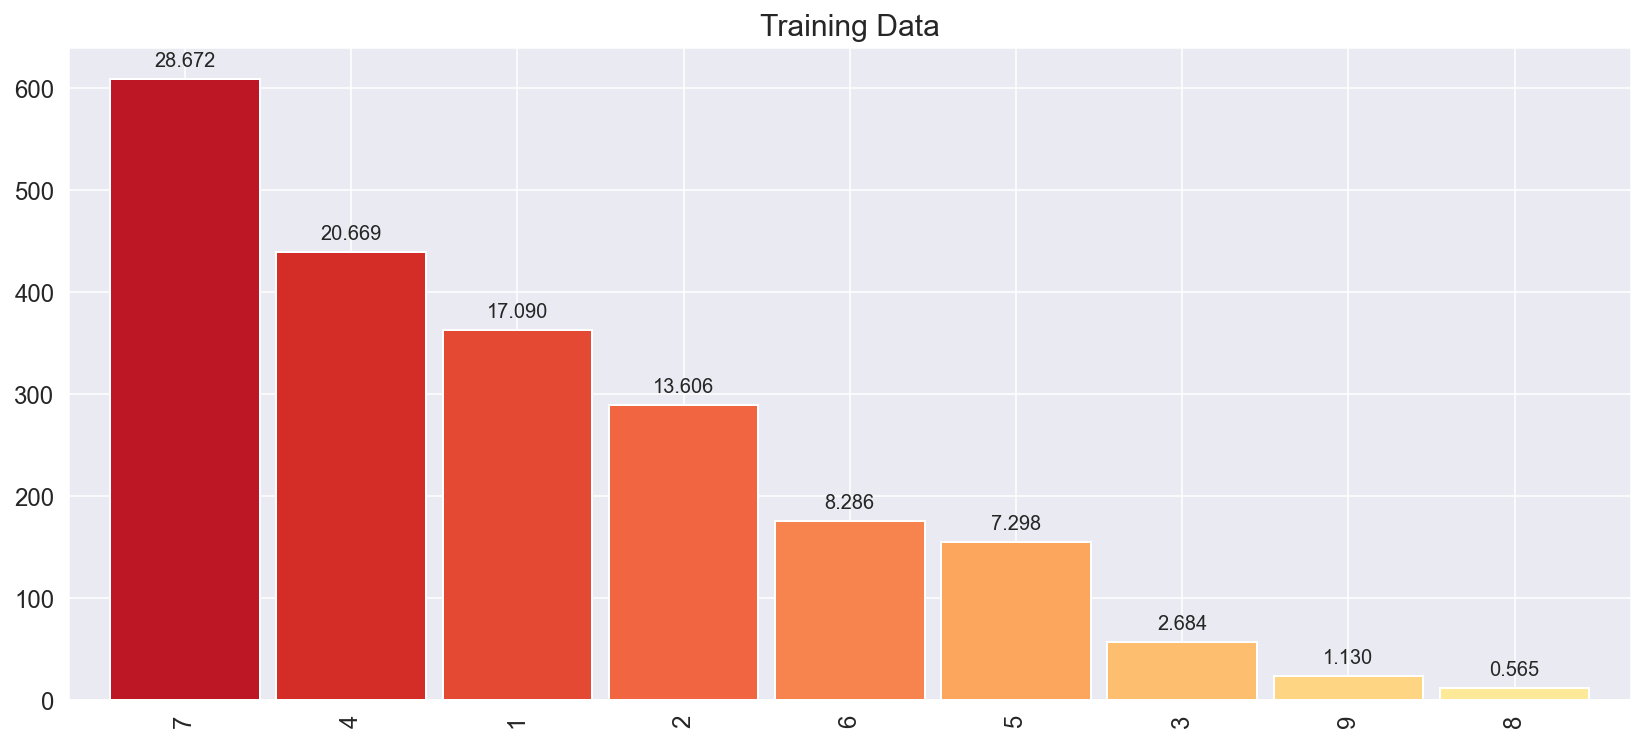

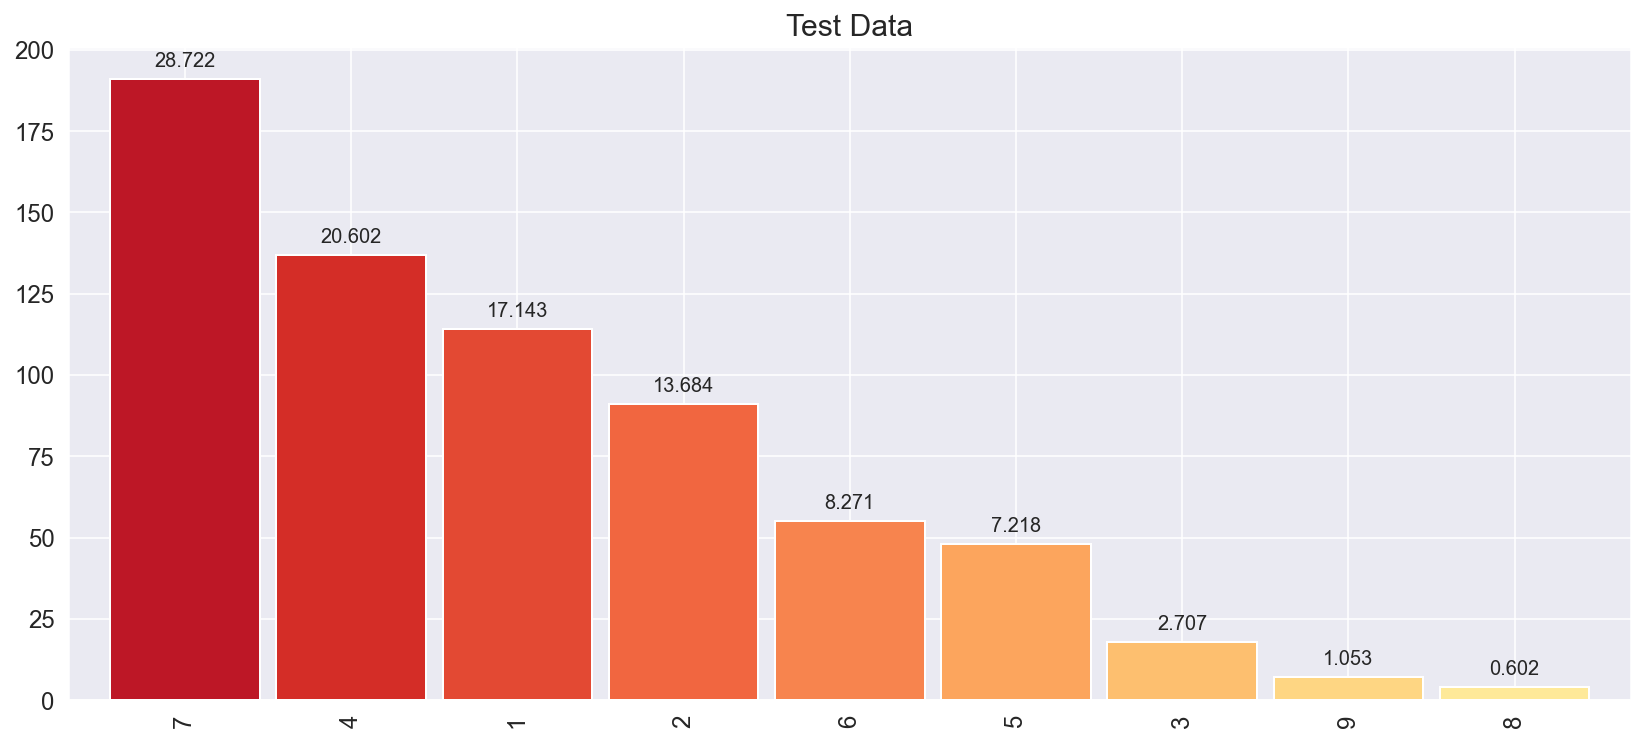

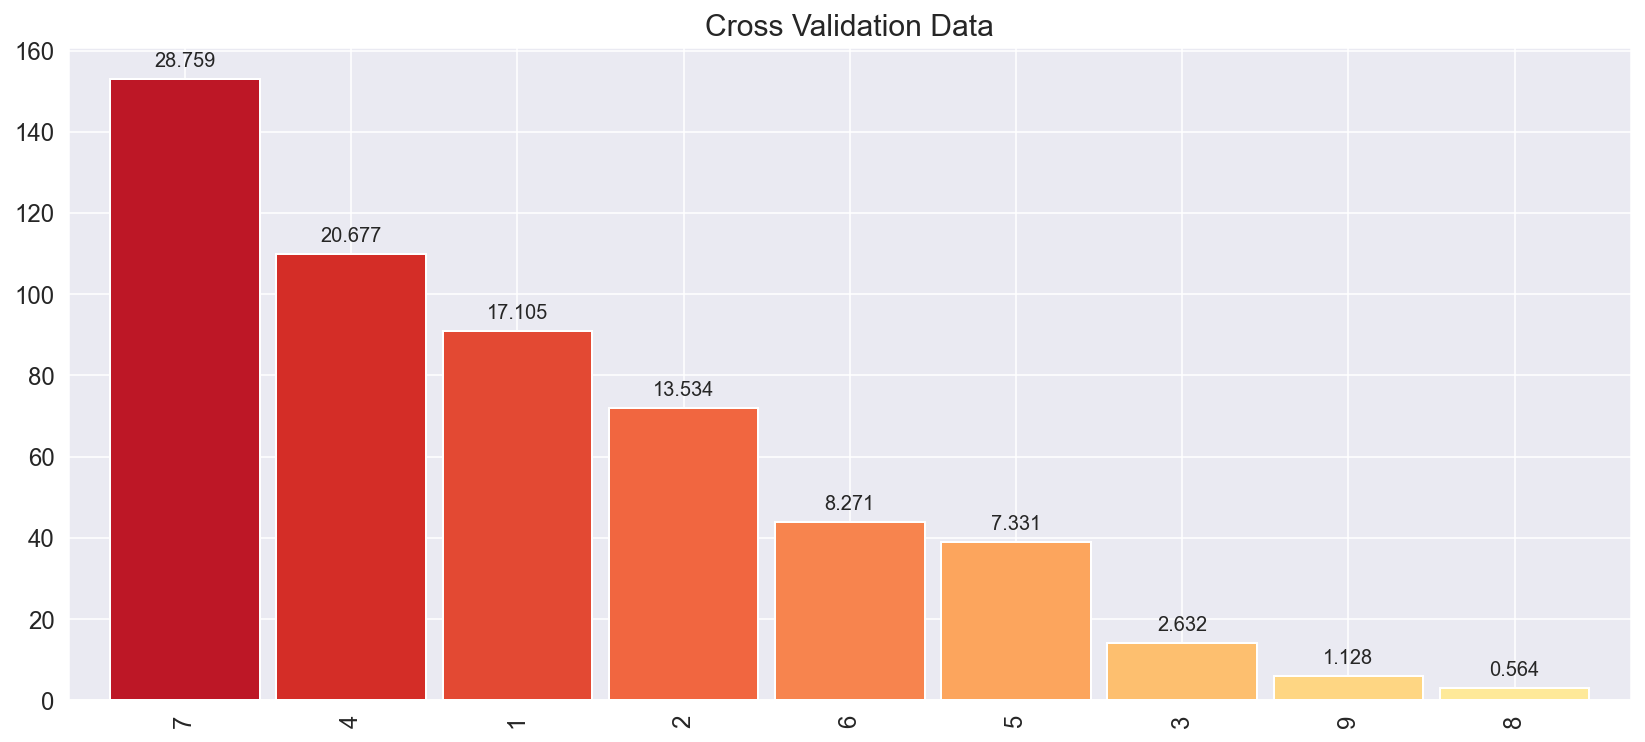

In [13]:
train_class_distribution = X_train['Class'].value_counts().sort_values(ascending=False)
test_class_distribution = X_test['Class'].value_counts().sort_values(ascending=False)
cv_class_distribution = X_cv['Class'].value_counts().sort_values(ascending=False)

plt.subplots(figsize=(14, 6))
ax = train_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
sorted_yi = np.argsort(-train_class_distribution.values)
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_train.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Training Data")

plt.subplots(figsize=(14, 6))
ax = test_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_test.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Test Data")

plt.subplots(figsize=(14, 6))
ax = cv_class_distribution.plot.bar(width=0.9, color=sns.color_palette('RdYlGn', 20))
for p in ax.patches:
    ax.annotate(format((p.get_height()/X_cv.shape[0]*100), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title("Cross Validation Data")
plt.show()

- It is a multi class classification problem.
- Distribution of all the classes in train, test and cross validate dataset is almost same.Which is good sign for us.
- Class 7, 4 and 1 are the majority classes.
- Class 3, 9 and have very low data points associated with them.

### Predicting using "Random Model"

In a random model we generate the NINE (9) class probability randomly such that they sum to 1

In [14]:
def plot_confusion_matrix(y_test, y_pred):
    # C will be a 9x9 matrix, each cell represents number of 
    # points of class i and predicted class j
    C = confusion_matrix(y_test, y_pred)
    
    # precision matrix : Divide each element of the confusion matrix with the sum
    # of element in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    
    # C.T = [[1, 3],
    #        [2, 4]]
    
    # C.sum(axis = 1) ; axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    A = ((C.T / C.sum(axis = 1)).T)
        
    # Recall Matrix : divid each element of the confusion matrix with the sum of
    # elements in that row
    
    # C = [[1, 2],
    #     [3, 4]]
    
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    B = ((C / C.sum(axis = 0)))
    
    labels = [1, 2, 3, 4, 5, 6, 7 , 8, 9]
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(C, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(B, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    plt.figure(figsize = (20, 7))
    cmap = sns.diverging_palette(250, 15, 30, as_cmap=True)
    sns.heatmap(A, annot = True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize=18)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

[Random Model] cv log loss is   (2.5212611426794753
[Random Model] test log loss is (2.4663257582368385)


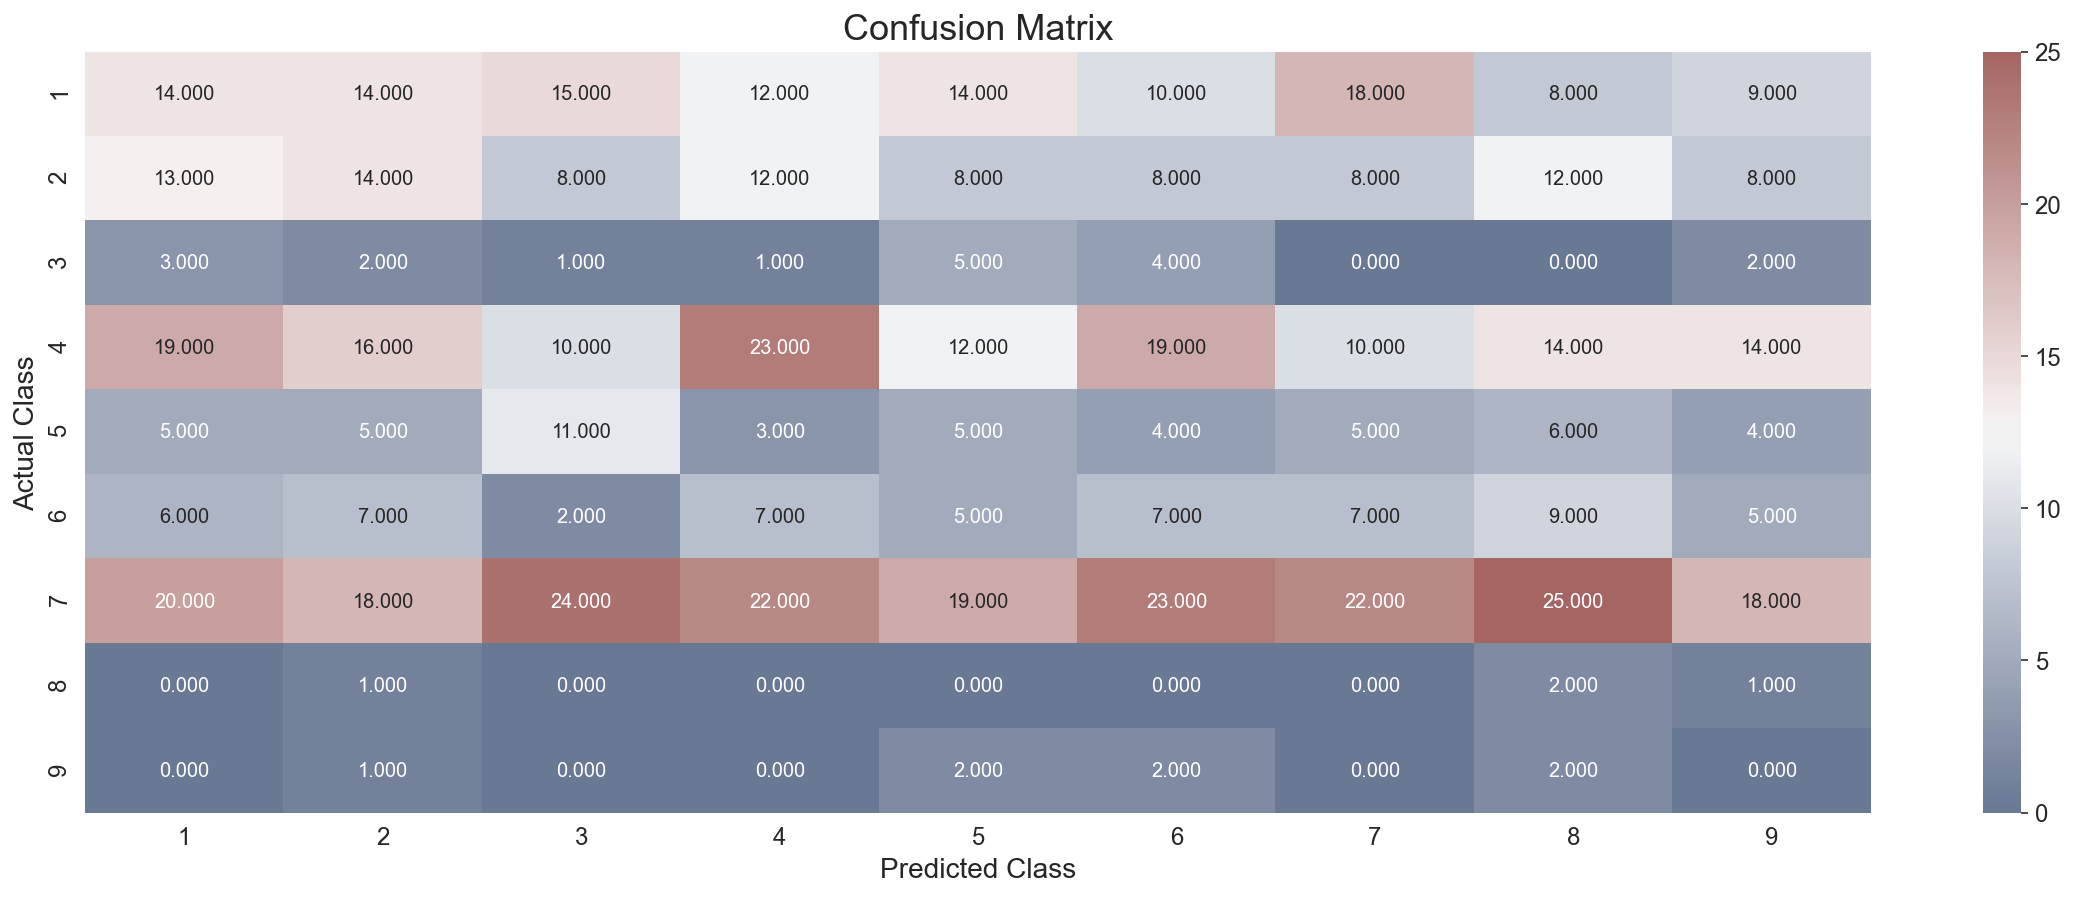

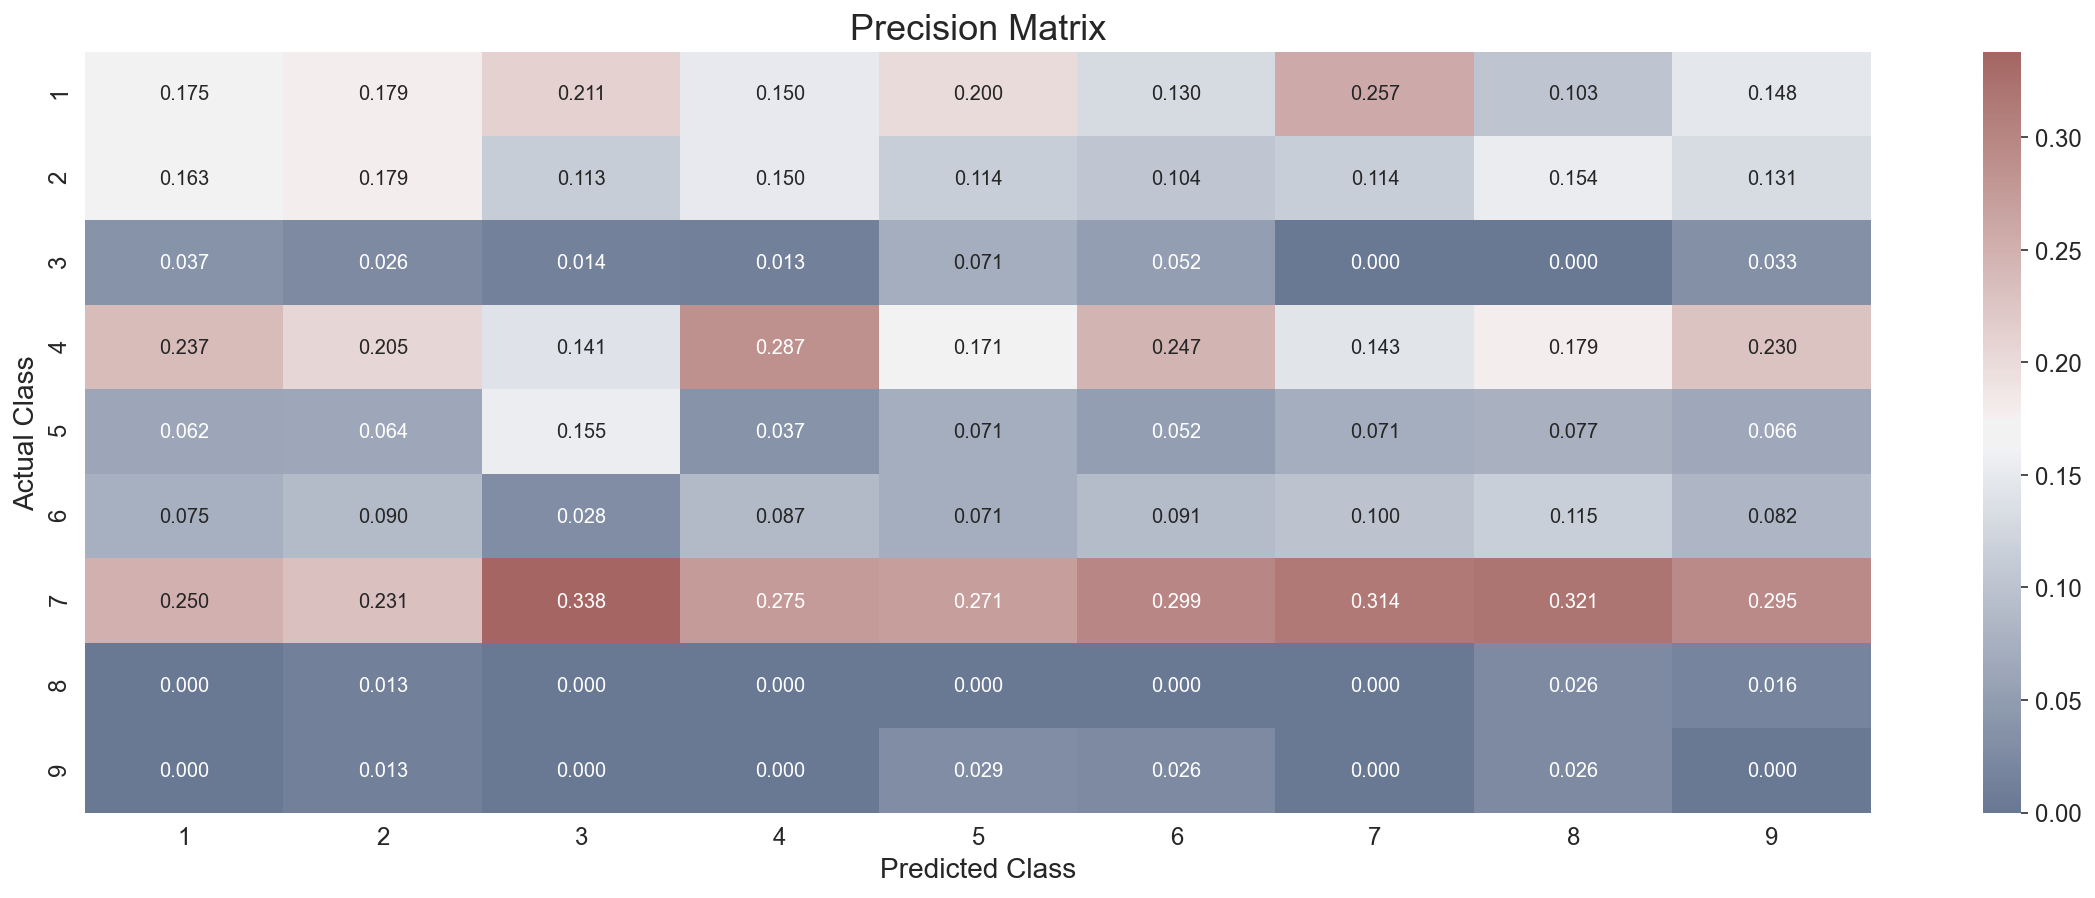

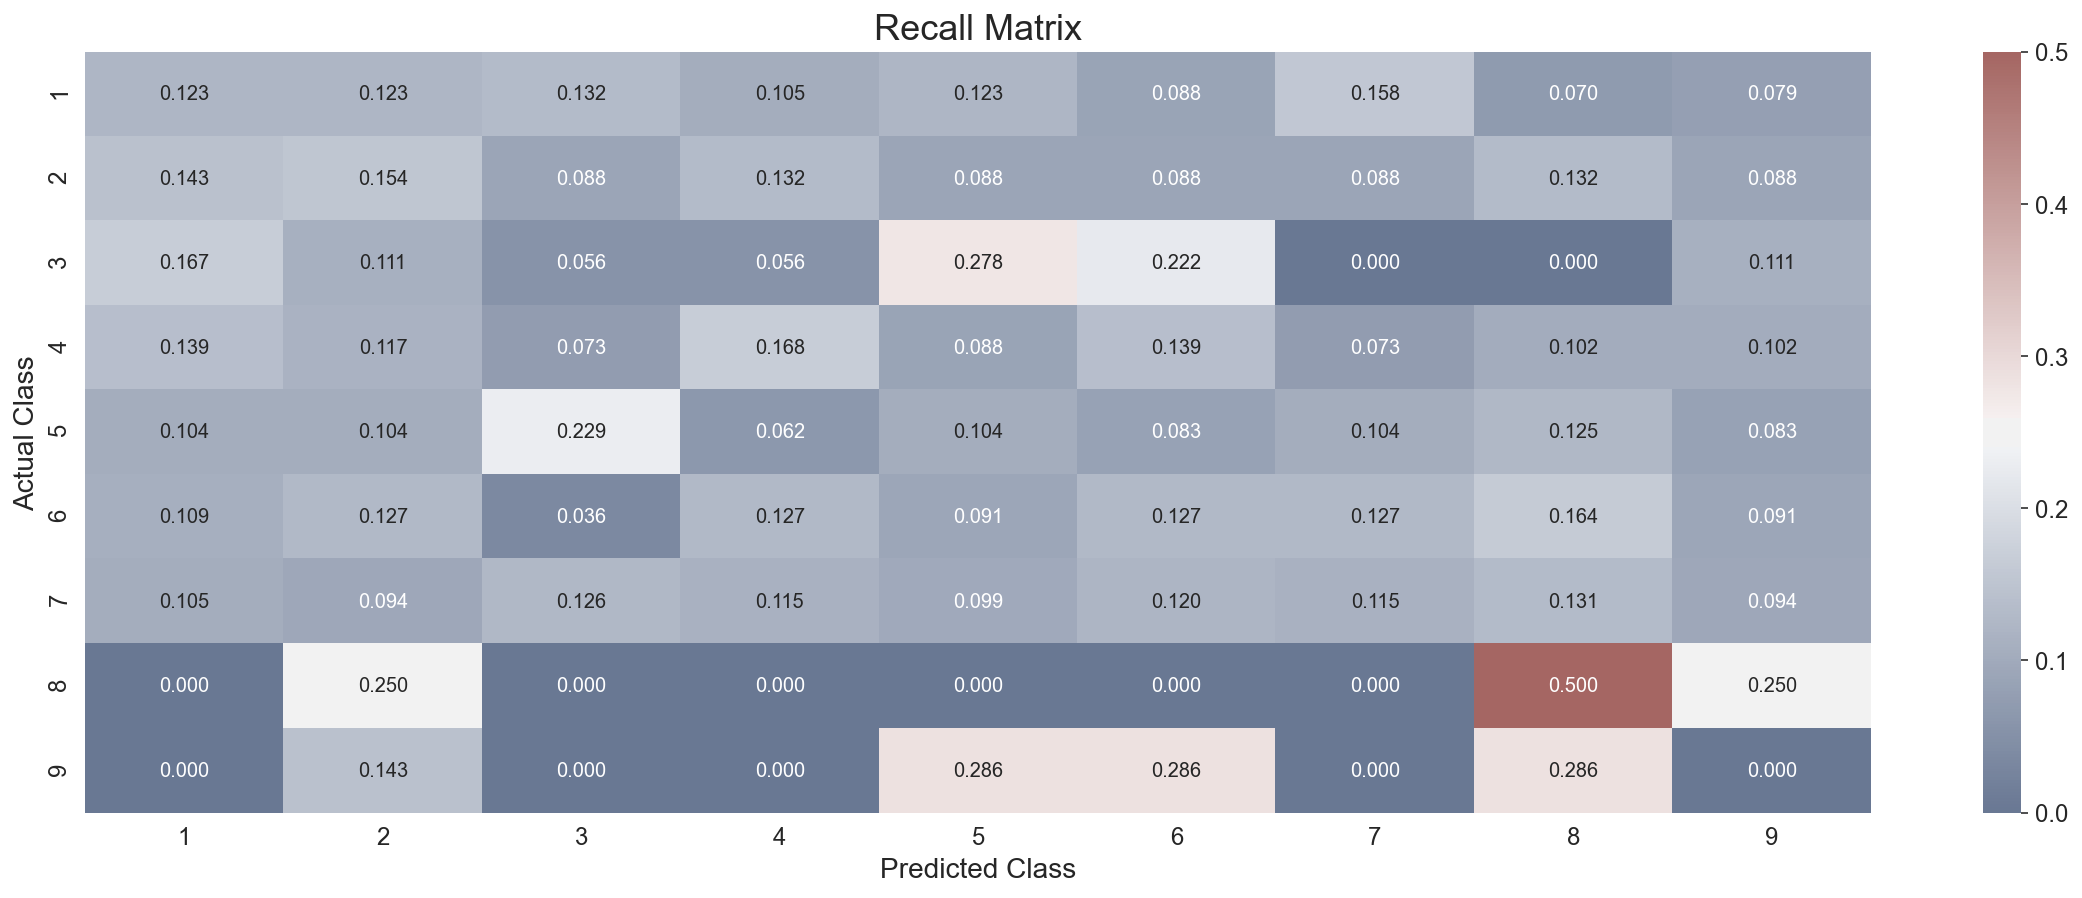

In [15]:
# we need to generate 9 numbers such that sum of all the numbe will be equals to 1..
# one solution : geenerate 9 numbers and divide each of thee number by their sum

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# On cross validation data
# we create a output array that has exaclty same size as the CV data
y_cv_pred = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    y_cv_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(f"[Random Model] cv log loss is   ({log_loss(y_cv, y_cv_pred, eps=1e-15)}")

# On test data
y_test_pred = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    y_test_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(f"[Random Model] test log loss is ({log_loss(y_test, y_test_pred, eps=1e-15)})")

y_predicted = np.argmax(y_test_pred, axis = 1)
plot_confusion_matrix(y_test, y_predicted + 1)

Log loss on cross validation and test dataset is roughly equals to 2.5 when we used random model which means this log-loss can be the worst case.
we know minimum value of log-loss is 0 and maximum can be tends to infinity, means log-loss value on cv and test data on a reasonable model will be in between the range of 0 and 2.5 or in other words we can say that log-loss should be less than 2.5 for a reasonable model.

### Categorical Feature Encoding 

In [16]:
data[["Gene", "Variation"]].head()

Gene             Variation
0  FAM58A  Truncating_Mutations
1     CBL                 W802*
2     CBL                 Q249E
3     CBL                 N454D
4     CBL                 L399V

Feature **Gene**:
    
    - Gene feature contains [264] unique categories.
    
Feature **Variation**:
    
    - Variation Feature contain [2996] unique categories.


In [17]:
# Response Encoding
def get_gv_feat_dict(alpha, feature, data):
    """
    1. Consider all unique values of a feature and occurance of every value
    2. Build a vector (1*9), ith element = (# occurance of value in class i + alpha*10) / (# ocurance of value in whole data + 90*alpha)
    3. gv_dict : Is like a look up table contains, for every category it store (1*9) vector representation 
    return : gv_dict
    """
    value_count = X_train[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = X_train.loc[(data['Class'] == k) & (X_train[feature] == i)]
            vec.append((cls_cnt.shape[0] + alpha*10) / (denominator + 90*alpha))
        gv_dict[i] = vec
    return gv_dict

def get_gv_feature(alpha, feature, data):
    """
    For a value of feature in df
    if it is in train data:
    we add the vector that was stored in gv_dict to gv_feat
    else we add 1/9 to every cell of (1*9) vector
    return : gv_feat
    """
    gv_dict = get_gv_feat_dict(alpha, feature, data)
    value_count = X_train[feature].value_counts()
    gv_feat = []
    
    for index, row in data.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_feat.append(gv_dict[row[feature]])
        else:
            gv_feat.append([[1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]])
    return gv_feat

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(data):
    text_feature_responsecoding = np.zeros((data.shape[0], 9))
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responsecoding

In [18]:
alpha = 1

train_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_train))
test_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_test))
cv_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_cv))
print("OK")

OK


In [19]:
train_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
test_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_test))
cv_var_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))
print("OK")

OK


In [20]:
# one hot encode
gene_vectorizer = CountVectorizer()
train_gene_one_hot_encode = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_one_hot_encode = gene_vectorizer.transform(X_test['Gene'])
cv_gene_one_hot_encode = gene_vectorizer.transform(X_cv['Gene'])

variation_vectorizer = CountVectorizer()
train_variation_one_hot_encode = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_one_hot_encode = variation_vectorizer.transform(X_test['Variation'])
cv_variation_one_hot_encode = variation_vectorizer.transform(X_cv['Variation'])


# KDD orange (a simple extention of one hot encoding)
def kdd_ohe_ok(data, feature):
    kdd_one_hot_encode = pd.DataFrame()  
    top_labels = [x for x in data[feature].value_counts().sort_values(ascending=False).head(10).index]
    for label in top_labels:
        kdd_one_hot_encode[feature+'_'+label] = np.where(data[feature] == label, 1, 0)
    return kdd_one_hot_encode

train_kdd_gene_one_hot_encode = kdd_ohe_ok(X_train, 'Gene')
test_kdd_gene_one_hot_encode = kdd_ohe_ok(X_test, 'Gene')
cv_kdd_gene_one_hot_encode = kdd_ohe_ok(X_cv, 'Gene')

train_kdd_variation_one_hot_encode = kdd_ohe_ok(X_train, 'Variation')
test_kdd_variation_one_hot_encode = kdd_ohe_ok(X_test, 'Variation')
tcv_kdd_variation_one_hot_encode = kdd_ohe_ok(X_cv, 'Variation')


# Mean Encoding
train_gene_mean_encode = pd.DataFrame()
test_gene_mean_encode = pd.DataFrame()
cv_gene_mean_encode = pd.DataFrame()
train_variation_mean_encode = pd.DataFrame()
test_variation_mean_encode = pd.DataFrame()
cv_variation_mean_encode = pd.DataFrame()

train_gene_dict_values = X_train.groupby(['Gene'])['Class'].mean().to_dict()
test_gene_dict_values = X_test.groupby(['Gene'])['Class'].mean().to_dict()
cv_gene_dict_values = X_cv.groupby(['Gene'])['Class'].mean().to_dict()

train_gene_mean_encode['Gene'] = X_train['Gene'].map(train_gene_dict_values)
test_gene_mean_encode['Gene'] = X_test['Gene'].map(test_gene_dict_values)
cv_gene_mean_encode['Gene'] = X_cv['Gene'].map(cv_gene_dict_values)

train_variation_dict_values = X_train.groupby(['Variation'])['Class'].mean().to_dict()
test_variation_dict_values = X_test.groupby(['Variation'])['Class'].mean().to_dict()
cv_variation_dict_values = X_cv.groupby(['Variation'])['Class'].mean().to_dict()

train_variation_mean_encode['Variation'] = X_train['Variation'].map(train_variation_dict_values)
test_variation_mean_encode['Variation'] = X_test['Variation'].map(test_variation_dict_values)
cv_variation_mean_encode['Variation'] = X_cv['Variation'].map(cv_variation_dict_values)

# Count / Frequency encoding
train_gene_freq_encode = pd.DataFrame()
test_gene_freq_encode = pd.DataFrame()
cv_gene_freq_encode = pd.DataFrame()
train_variation_freq_encode = pd.DataFrame()
test_variation_freq_encode = pd.DataFrame()
cv_variation_freq_encode = pd.DataFrame()

train_gene_freq_count = X_train['Gene'].value_counts().to_dict()
test_gene_freq_count = X_test['Gene'].value_counts().to_dict()
cv_gene_freq_count = X_cv['Gene'].value_counts().to_dict()

train_gene_freq_encode['Gene'] = X_train['Gene'].map(train_gene_freq_count)
test_gene_freq_encode['Gene'] = X_test['Gene'].map(test_gene_freq_count)
cv_gene_freq_encode['Gene'] = X_cv['Gene'].map(cv_gene_freq_count)

train_var_freq_count = X_train['Variation'].value_counts().to_dict()
test_var_freq_count = X_test['Variation'].value_counts().to_dict()
cv_var_freq_count = X_cv['Variation'].value_counts().to_dict()

train_variation_freq_encode['Variation'] = X_train['Variation'].map(train_var_freq_count)
test_variation_freq_encode['Variation'] = X_test['Variation'].map(test_var_freq_count)
cv_variation_freq_encode['Variation'] = X_cv['Variation'].map(cv_var_freq_count)


    
Feature **TEXT**:

    - Text feature is a set of sequential words.

In [21]:
# Bag of words
text_vect_bow = CountVectorizer(min_df = 3)

train_text_bow = text_vect_bow.fit_transform(X_train['TEXT'])
test_text_bow = text_vect_bow.transform(X_test['TEXT'])
cv_text_bow = text_vect_bow.transform(X_cv['TEXT'])
# train_text_features = train_text_bow.get_feature_names()
# train_text_feature_counts = train_text_bow.sum(axis=0).A1
# text_feat_dict = dict(zip(list(train_text_features), train_text_feature_counts))
# print("Total Number of unique words in train data:", len(train_text_features))
print("BOW Done!")

train_text_bow = normalize(train_text_bow, axis=0)
test_text_bow = normalize(test_text_bow, axis=0)
cv_text_bow = normalize(cv_text_bow, axis=0)
print("Bag of words features for each dataset normalized!")

# getting all the feature names
train_text_bow_features = text_vect_bow.get_feature_names()
# this will sum every row and returns (1*number of features vector)
train_text_bow_count = train_text_bow.sum(axis=0).A1
print("Total Number of unique words in text data", len(train_text_bow_features))
print("="*40)

# bi-grmas bow
text_vect_bi = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 3)

train_bi_text_bow = text_vect_bi.fit_transform(X_train['TEXT'])
test_bi_text_bow = text_vect_bi.transform(X_test['TEXT'])
cv_bi_text_bow = text_vect_bi.transform(X_cv['TEXT'])
print("Bi gram based BOW Done!")

train_text_bi_bow = normalize(train_bi_text_bow, axis=0)
test_text_bi_bow = normalize(test_bi_text_bow, axis=0)
cv_text_bi_bow = normalize(cv_bi_text_bow, axis=0)
print("Bi grams based BOW features for each dataset normalized!")
print("="*40)

# uni + bi grams bow
text_vect_uni_bi = CountVectorizer(ngram_range=(1, 2), min_df = 3)

train_uni_bi_text_bow = text_vect_uni_bi.fit_transform(X_train['TEXT'])
test_uni_bi_text_bow = text_vect_uni_bi.transform(X_test['TEXT'])
cv_uni_bi_text_bow = text_vect_uni_bi.transform(X_cv['TEXT'])
print("Unigrams + Bi grams based BOW Done!")

train_uni_bi_text_bow = normalize(train_uni_bi_text_bow, axis=0)
test_uni_bi_text_bow = normalize(test_uni_bi_text_bow, axis=0)
cv_uni_bi_text_bow = normalize(cv_uni_bi_text_bow, axis=0)
print("Uni+Bi grams based BOW features for each dataset normalized!")
print("="*40)

# tf-idf 
text_vect_tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5)

train_text_tfidf = text_vect_tfidf.fit_transform(X_train['TEXT'])
test_text_tfidf = text_vect_tfidf.transform(X_test['TEXT'])
cv_text_tfidf = text_vect_tfidf.transform(X_cv['TEXT'])
print("Tf-idf Done!")

train_text_tfidf = normalize(train_text_tfidf, axis=0)
test_text_tfidf = normalize(test_text_tfidf, axis=0)
cv_text_tfidf = normalize(cv_text_tfidf, axis=0)
print("tf-idf features for each dataset normalized!")
print("="*40)

BOW Done!
Bag of words features for each dataset normalized!
Total Number of unique words in text data 53778
Bi gram based BOW Done!
Bi grams based BOW features for each dataset normalized!
Unigrams + Bi grams based BOW Done!
Uni+Bi grams based BOW features for each dataset normalized!
Tf-idf Done!
tf-idf features for each dataset normalized!


## Gene

Gene is a categorical feature having 229 unique categories.
I have used simple one hot encoding using countvectorizer for this instance, but i will try multiple vectorizer technique and 'll see how my model improves or not.

### How good ( gene ) feature predicting output class?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i

In [22]:
print("Simple Bag of Words!")
print("====================")
print(f"Shape of gene feature in [X_Train] {train_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [y_Train] {y_train.shape}")
print(f"Shape of gene feature in [Test]    {test_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [X_test]  {y_test.shape}")
print(f"Shape of gene feature in [CV]      {cv_gene_one_hot_encode.shape}")
print(f"Shape of gene feature in [X_cv]    {y_cv.shape}")

Simple Bag of Words!
Shape of gene feature in [X_Train] (2124, 235)
Shape of gene feature in [y_Train] (2124,)
Shape of gene feature in [Test]    (665, 235)
Shape of gene feature in [X_test]  (665,)
Shape of gene feature in [CV]      (532, 235)
Shape of gene feature in [X_cv]    (532,)


log_loss (1.2256266149214154) alpha [1e-05]
log_loss (1.1973138591188046) alpha [0.0001]
log_loss (1.2422405245032675) alpha [0.001]
log_loss (1.3438359137594669) alpha [0.01]
log_loss (1.4134270178790524) alpha [0.1]
log_loss (1.4523580339224043) alpha [1]


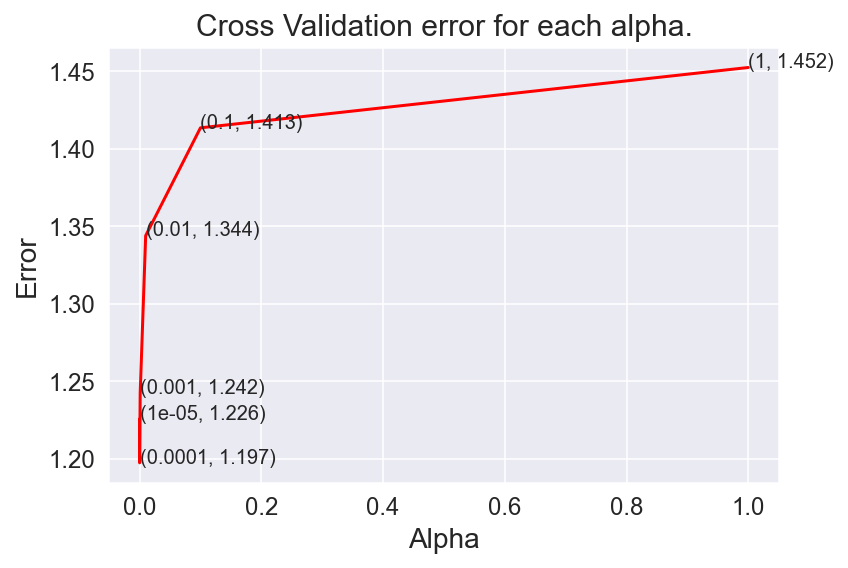

Best alpha is (0.0001)
[Train log_loss] 0.9832046778755618
[CV log_loss]    1.1973138591188046
[Test log_loss]  1.1894413460381446


In [23]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_gene_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_gene_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_gene_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_gene_one_hot_encode)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_gene_one_hot_encode)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_gene_one_hot_encode)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

As we can see that cross validation and test log loss is better than my random model. that means this model can be useful for us.

### Is the gene feature is stable across all the dataset's?

In [24]:
print("How many data points in test and cv dataset's are covered by 229 genes in train dataset?")
print("")
test_coverage = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage = X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print("In test data", test_coverage, 'out of', X_test.shape[0], "covered :", np.round((test_coverage/X_test.shape[0]),2)*100,"%")
print("In CV data", cv_coverage, 'out of', X_cv.shape[0], "covered :", np.round((cv_coverage/X_cv.shape[0]), 2)*100, "%")

How many data points in test and cv dataset's are covered by 229 genes in train dataset?

In test data 644 out of 665 covered : 97.0 %
In CV data 511 out of 532 covered : 96.0 %


## Variation

Variation is categorical features having 2996 unique categories.
I have used simple one hot encoding using countvectorizer for this instance, but i will try multiple vectorizer technique and 'll see how my model improves or not.

log_loss (1.726297993897468) alpha [1e-05]
log_loss (1.7187671494219425) alpha [0.0001]
log_loss (1.717418917719875) alpha [0.001]
log_loss (1.724747823872629) alpha [0.01]
log_loss (1.7361076613479218) alpha [0.1]
log_loss (1.7375757257020386) alpha [1]


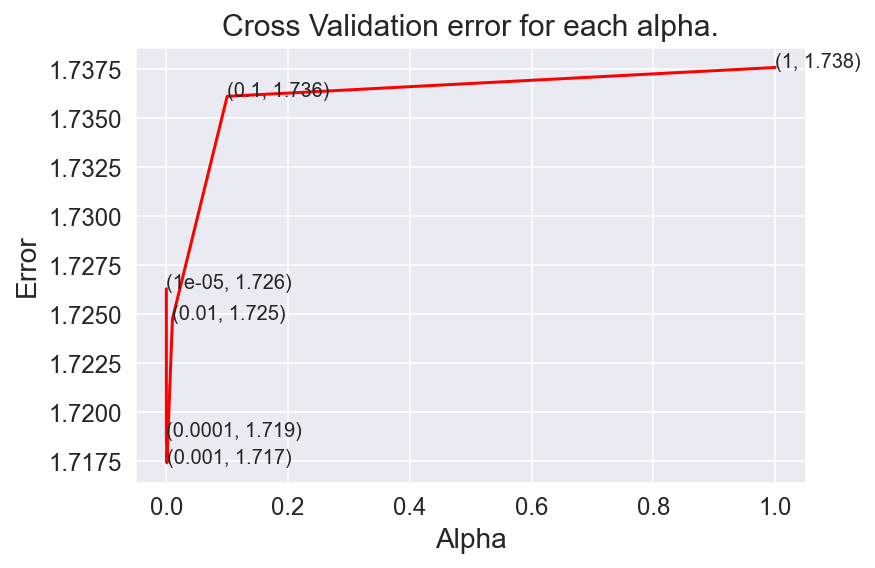

Best alpha is (0.001)
[Train log_loss] 1.0658028876470493
[CV log_loss]    1.717418917719875
[Test log_loss]  1.7060680299494018


In [25]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_variation_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_variation_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_variation_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_variation_one_hot_encode)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_variation_one_hot_encode)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

### Is the gene feature is stable across all the dataset's?

In [26]:
print("How many data points in test and cv dataset's are covered by 2996 varaince in train dataset?")
print("")
test_coverage = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage = X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print("In test data", test_coverage, 'out of', X_test.shape[0], "covered :", np.round((test_coverage/X_test.shape[0]),2)*100,"%")
print("In CV data", cv_coverage, 'out of', X_cv.shape[0], "covered :", np.round((cv_coverage/X_cv.shape[0]), 2)*100, "%")

How many data points in test and cv dataset's are covered by 2996 varaince in train dataset?

In test data 61 out of 665 covered : 9.0 %
In CV data 58 out of 532 covered : 11.0 %


As we can clearly see that the difference between train and cross validation loss is more than gene feature. and it seem's that model is overfitting but
we can't say this directly.

log loss of train and cv better than my random model that means this feature 
is also useful for us to build the model.

## TEXT

Sequence of words, simple using bag of words for now, will try different vectorizer in future to test.

Number of unique words in training dataset is [53778]

log_loss (1.345083589319785) alpha [1e-05]
log_loss (1.1867828828111076) alpha [0.0001]
log_loss (1.1913393708905893) alpha [0.001]
log_loss (1.3451999722557444) alpha [0.01]
log_loss (1.4551230755718734) alpha [0.1]
log_loss (1.6345128083817566) alpha [1]


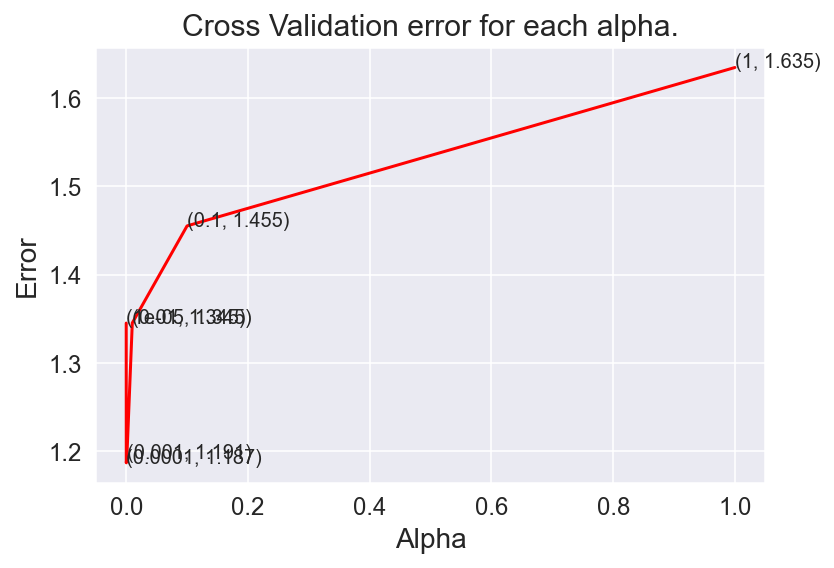

Best alpha is (0.0001)
[Train log_loss] 0.6692143813793385
[CV log_loss]    1.1867828828111076
[Test log_loss]  1.2085131844192978


In [27]:
# tunnning logistic regression on gene feature
alpha = [10**x for x in range(-5, 1)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, loss='log', penalty='l2', random_state=1)
    clf.fit(train_text_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_bow, y_train)
    y_pred = sig_clf.predict_proba(cv_text_bow)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{i}]")
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)),
                (alpha[i], cv_log_error[i]))
plt.title("Cross Validation error for each alpha.")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error)
print(f"Best alpha is ({alpha[best_alpha]})")
print("======================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(train_text_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_text_bow, y_train)
y_pred = sig_clf.predict_proba(train_text_bow)
print(f"[Train log_loss] {log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(cv_text_bow)
print(f"[CV log_loss]    {log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}")
y_pred = sig_clf.predict_proba(test_text_bow)
print(f"[Test log_loss]  {log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)}")

By the common sense, that feature [TEXT] should be most useful feature in our dataset and that is.By seeing the score it is better than both gene and variation as well as very better than random model.

log_loss [1.7353409695009387] alpha [1e-05]
log_loss [1.7274886012514088] alpha [0.0001]
log_loss [1.7468827087352896] alpha [0.001]
log_loss [1.7818856399713965] alpha [0.01]
log_loss [1.8303536180980648] alpha [0.1]
log_loss [1.8303536157958085] alpha [1]
log_loss [1.830353615786093] alpha [10]
log_loss [1.830353615785909] alpha [100]
log_loss [1.8303536157858975] alpha [1000]


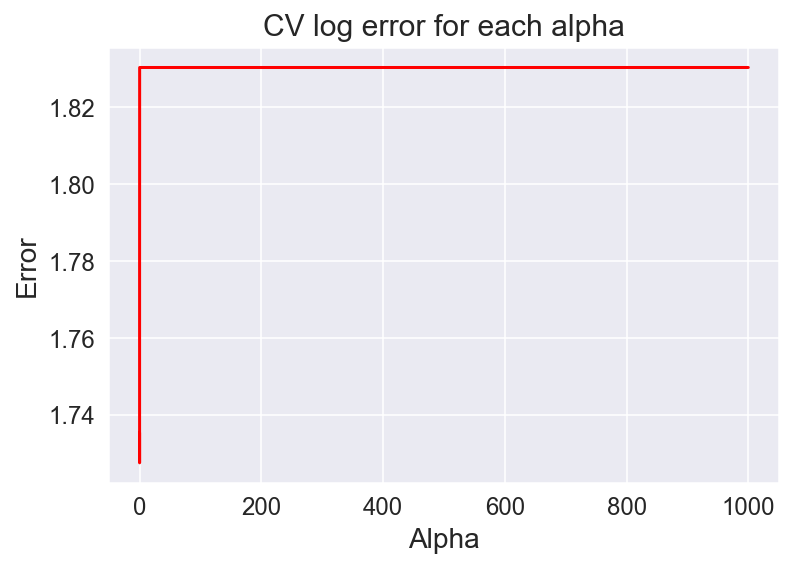

[Train log_loss] (0.5842907503256072)
[CV log_loss] (1.7296922265267307)
[TEst log_loss] (1.7166805021270048)


In [28]:
alpha = [10**x for x in range(-5, 4)]

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=1)
    clf.fit(train_variation_one_hot_encode, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_one_hot_encode, y_train)
    y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
    cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print(f"log_loss [{log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}] alpha [{i}]")
          
          
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
plt.title("CV log error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()
          
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='hinge', random_state=1)
clf.fit(train_variation_one_hot_encode, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_one_hot_encode, y_train)
y_pred = sig_clf.predict_proba(train_variation_one_hot_encode)
print(f'[Train log_loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})')
y_pred = sig_clf.predict_proba(cv_variation_one_hot_encode)
print(f'[CV log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})')
y_pred = sig_clf.predict_proba(test_variation_one_hot_encode)
print(f"[TEst log_loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")

### Helper Functions for ML models

In [29]:
def predict_and_plot_confusion_matrix(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict(X_test)
    print(f"[Test Log loss] ({log_loss(y_test, sig_clf.predict_proba(X_test))})")
    print(f"Number of missclassified points : {np.count_nonzero((y_pred - y_test))/y_test.shape[0]}")
    plot_confusion_matrix(y_test, y_pred)
    
def report_log_loss(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifier(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_test)
    return log_loss(y_test, y_pred, eps=1e-15)

## Stacking up three type of features

     TEXT      : BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [30]:
X_train_ohe_bow = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_bow)).tocsr()
X_test_ohe_bow = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_bow)).tocsr()
X_cv_ohe_bow = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_bow)).tocsr()

X_train_kdd_bow = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_bow)).tocsr()
X_test_kdd_bow = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_bow)).tocsr()
X_cv_kdd_bow = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_bow)).tocsr()

X_train_mean_bow = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_bow)).tocsr()
X_test_mean_bow = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_bow)).tocsr()
X_cv_mean_bow = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_bow)).tocsr()

X_train_freq_bow = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_bow)).tocsr()
X_test_freq_bow = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_bow)).tocsr()
X_cv_freq_bow = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_bow)).tocsr()

     TEXT      : 2-gram based BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [31]:
X_train_ohe_bi = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_bi_bow)).tocsr()
X_test_ohe_bi = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_bi_bow)).tocsr()
X_cv_ohe_bi = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_bi_bow)).tocsr()

X_train_kdd_bi = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_bi_bow)).tocsr()
X_test_kdd_bi = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_bi_bow)).tocsr()
X_cv_kdd_bi = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_bi_bow)).tocsr()

X_train_mean_bi = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_bi_bow)).tocsr()
X_test_mean_bi = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_bi_bow)).tocsr()
X_cv_mean_bi = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_bi_bow)).tocsr()

X_train_freq_bi = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_bi_bow)).tocsr()
X_test_freq_bi = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_bi_bow)).tocsr()
X_cv_freq_bi = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_bi_bow)).tocsr()

     TEXT      : uni+bi gram based BOW
     ===============
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [32]:
X_train_ohe_uni_bi = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_uni_bi_text_bow)).tocsr()
X_test_ohe_uni_bi = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_uni_bi_text_bow)).tocsr()
X_cv_ohe_uni_bi = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_uni_bi_text_bow)).tocsr()

X_train_kdd_uni_bi = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_uni_bi_text_bow)).tocsr()
X_test_kdd_uni_bi = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_uni_bi_text_bow)).tocsr()
X_cv_kdd_uni_bi = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_uni_bi_text_bow)).tocsr()

X_train_mean_uni_bi = hstack((train_gene_mean_encode, train_variation_mean_encode, train_uni_bi_text_bow)).tocsr()
X_test_mean_uni_bi = hstack((test_gene_mean_encode, test_variation_mean_encode, test_uni_bi_text_bow)).tocsr()
X_cv_mean_uni_bi = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_uni_bi_text_bow)).tocsr()

X_train_freq_uni_bi = hstack((train_gene_freq_encode, train_variation_freq_encode, train_uni_bi_text_bow)).tocsr()
X_test_freq_uni_bi = hstack((test_gene_freq_encode, test_variation_freq_encode, test_uni_bi_text_bow)).tocsr()
X_cv_freq_uni_bi = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_uni_bi_text_bow)).tocsr()

     TEXT      : Tf-idf
     ==================
     Gene      : one hot encode, Responsecoing, kdd, mean, frequency
     variation : one hot encode, Responsecoing, kdd, mean, frequency
     

In [33]:
X_train_ohe_tfidf = hstack((train_gene_one_hot_encode, train_variation_one_hot_encode, train_text_tfidf)).tocsr()
X_test_ohe_tfidf = hstack((test_gene_one_hot_encode, test_variation_one_hot_encode, test_text_tfidf)).tocsr()
X_cv_ohe_tfidf = hstack((cv_gene_one_hot_encode, cv_variation_one_hot_encode, cv_text_tfidf)).tocsr()

X_train_kdd_tfidf = hstack((train_kdd_gene_one_hot_encode, train_kdd_variation_one_hot_encode, train_text_tfidf)).tocsr()
X_test_kdd_tfidf = hstack((test_kdd_gene_one_hot_encode, test_kdd_variation_one_hot_encode, test_text_tfidf)).tocsr()
X_cv_kdd_tfidf = hstack((cv_kdd_gene_one_hot_encode, tcv_kdd_variation_one_hot_encode, cv_text_tfidf)).tocsr()

X_train_mean_tfidf = hstack((train_gene_mean_encode, train_variation_mean_encode, train_text_tfidf)).tocsr()
X_test_mean_tfidf = hstack((test_gene_mean_encode, test_variation_mean_encode, test_text_tfidf)).tocsr()
X_cv_mean_tfidf = hstack((cv_gene_mean_encode, cv_variation_mean_encode, cv_text_tfidf)).tocsr()

X_train_freq_tfidf = hstack((train_gene_freq_encode, train_variation_freq_encode, train_text_tfidf)).tocsr()
X_test_freq_tfidf = hstack((test_gene_freq_encode, test_variation_freq_encode, test_text_tfidf)).tocsr()
X_cv_freq_tfidf = hstack((cv_gene_freq_encode, cv_variation_freq_encode, cv_text_tfidf)).tocsr()

## Model Building

### Baseline model : Naive Bayes

In [34]:
vect_method = ['BOW', 'Bi-gram', 'Uni + bi gram', 'Tf-idf']
encode_method = ['ohe', 'kdd', 'mean', 'freq']
data_instance = {
                "ohe":[[X_train_ohe_bow, X_cv_ohe_bow, X_test_ohe_bow],
                       [X_train_ohe_bi, X_cv_ohe_bi, X_test_ohe_bi],
                       [X_train_ohe_uni_bi, X_cv_ohe_uni_bi, X_test_ohe_uni_bi],
                       [X_train_ohe_tfidf, X_cv_ohe_tfidf, X_test_ohe_tfidf]],
                "kdd":[[X_train_kdd_bow, X_cv_kdd_bow, X_test_kdd_bow],
                       [X_train_kdd_bi, X_cv_kdd_bi, X_test_kdd_bi],
                       [X_train_kdd_uni_bi, X_cv_kdd_uni_bi, X_test_kdd_uni_bi],
                       [X_train_kdd_tfidf, X_cv_kdd_tfidf, X_test_kdd_tfidf]],
                "mean":[[X_train_mean_bow, X_cv_mean_bow, X_test_mean_bow],
                        [X_train_mean_bi, X_cv_mean_bi, X_test_mean_bi],
                        [X_train_mean_uni_bi, X_cv_mean_uni_bi, X_test_mean_uni_bi],
                        [X_train_mean_tfidf, X_cv_mean_tfidf, X_test_mean_tfidf]],
                "freq":[[X_train_freq_bow, X_cv_freq_bow, X_test_freq_bow],
                        [X_train_freq_bi, X_cv_freq_bi, X_test_freq_bi],
                        [X_train_freq_uni_bi, X_cv_freq_uni_bi, X_test_freq_uni_bi],
                        [X_train_freq_tfidf, X_cv_freq_tfidf, X_test_freq_tfidf]]
                }


for a, b in enumerate(data_instance):
    print(f"================TEXT : {vect_method[a]} ================")
    for o in range(len(encode_method)):
        print("=======")
        print(f"Gene : {encode_method[o]} Encoding")
        print(f"Variation : {encode_method[o]} Encoding")
        print("=======")
        alpha = [10**x for x in range(-5, 4)]
        cv_log_error = []
        for k in alpha:
            clf = MultinomialNB(alpha=k)
            clf.fit(data_instance[b][o][0], y_train)
            sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
            sig_clf.fit(data_instance[b][o][0], y_train)
            y_pred = sig_clf.predict_proba(data_instance[b][o][1])
            cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
            print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

        fig, ax = plt.subplots()
        ax.plot(alpha, cv_log_error, c='r')
        for i, txt in enumerate(np.round(cv_log_error,2)):
            ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
        plt.xticks(np.log10(alpha))
        plt.title("Cross validation error for each alpha")
        plt.xlabel("Alpha")
        plt.ylabel("Error")
        plt.show()

#       
print(a)

        best_alpha = np.argmin(cv_log_error)
        print("=====================")
        print(f"[ Best alpha : {alpha[best_alpha]} ]")
        print("=====================")
        clf = MultinomialNB(alpha=alpha[best_alpha])
        clf.fit(data_instance[b][o][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(data_instance[b][o][0], y_train)
        y_pred = sig_clf.predict_proba(data_instance[b][o][0])
        print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
        y_pred = sig_clf.predict_proba(data_instance[b][o][1])
        print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
        y_pred = sig_clf.predict_proba(data_instance[b][o][2])
        print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
        print("="*53)
        predict_and_plot_confusion_matrix(data_instance[b][o][0], data_instance[b][o][2], y_train, y_test, clf=MultinomialNB(alpha=alpha[best_alpha]))

        cv_log_error.clear()
        print("="*70)

In [35]:
from prettytable import PrettyTable
bow = PrettyTable()
bi = PrettyTable()
uni_bi = PrettyTable()
tfidf = PrettyTable()

bow.field_names = ["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]
bi.field_names = ["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]
uni_bi.field_names = ["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]
tfidf.field_names = ["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]

bow.add_rows(
    [
        ["BOW", "One Hot Encoding", 0.1, 0.85, 1.31, 1.34, str(41)+"%", "OK 1P"],
        ["BOW", "KDD Encoding", 1000, 1.09, 1.27, 1.28, str(43)+"%", "OK 1P"],
        ["BOW", "Mean Encoding", 1000, 1.09, 1.09, 1.29, str(44)+"%", "OK 1P"],
        ["BOW", "Count Encoding", 1000, 1.09, 1.25, 1.26, str(42.4)+"%", "OK 1P"],
    ]
)

bi.add_rows(
    [
        ["Bi-Gram", "One Hot Encoding", 0.1, 0.88, 1.32, 1.34, str(42.1)+"%", "OK 1P"],
        ["Bi-Gram", "KDD Encoding", 1000, 1.10, 1.27, 1.29, str(43.1)+"%", "OK 1P"],
        ["Bi-Gram", "Mean Encoding", 1000, 1.10, 1.28, 1.29, str(44)+"%", "OK 1P"],
        ["Bi-Gram", "Count Encoding", 1000, 1.09, 1.25, 1.26, str(43)+"%", "OK 1P"], 
    ]
)

uni_bi.add_rows(
    [
        ["Uni-Bi Gram", "One Hot Encoding", 1000, 1.16, 1.18, 1.17, str(36)+"%", "Worst"],
        ["Uni-Bi Gram", "KDD Encoding", 1000, 1.27, 1.31, 1.30, str(37)+"%", "Worst"],
        ["Uni-Bi Gram", "Mean Encoding", 0.1, 0.93, 1.32, 1.34, str(42.4)+"%", "OK 1P"],
        ["Uni-Bi Gram", "Count Encoding", 0.01, 0.87, 1.34, 1.30, str(41)+"%", "OK 1P"],
    ]
)

tfidf.add_rows(
    [
        ["Tf-idf", "One Hot Encoding", 0.01, 0.94, 1.36, 1.31, str(40.3)+"%", "OK 1P"],
        ["Tf-idf", "KDD Encoding", 0.1, 0.93, 1.33, 1.33, str(42.4)+"%", "OK 2P"],
        ["Tf-idf", "Mean Encoding", 0.1, 0.93, 1.33, 1.33, str(41.6)+"%", "OK 1P"],
        ["Tf-idf", "Count Encoding", 0.1, 0.89, 1.33, 1.31, str(43)+"%", "OK 1P"],
    ]
)

print(bow.get_string(fields=["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]))
print(bi.get_string(fields=["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]))
print(uni_bi.get_string(fields=["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]))
print(tfidf.get_string(fields=["Vect Method", "Encoding Method", "best alpha", "Train loss", "CV loss", "Test loss", "MisClassified %", "Performance"]))

+-------------+------------------+------------+------------+---------+-----------+-----------------+-------------+
| Vect Method | Encoding Method  | best alpha | Train loss | CV loss | Test loss | MisClassified % | Performance |
+-------------+------------------+------------+------------+---------+-----------+-----------------+-------------+
|     BOW     | One Hot Encoding |    0.1     |    0.85    |   1.31  |    1.34   |       41%       |    OK 1P    |
|     BOW     |   KDD Encoding   |    1000    |    1.09    |   1.27  |    1.28   |       43%       |    OK 1P    |
|     BOW     |  Mean Encoding   |    1000    |    1.09    |   1.09  |    1.29   |       44%       |    OK 1P    |
|     BOW     |  Count Encoding  |    1000    |    1.09    |   1.25  |    1.26   |      42.4%      |    OK 1P    |
+-------------+------------------+------------+------------+---------+-----------+-----------------+-------------+
+-------------+------------------+------------+------------+---------+----------

    picking up Simple BOW vectorized features having 
    
    [Train loss] : 0.85
     [Test loss] : 1.34
    [Miss point] : 41 %

In [36]:
query_index = 1
no_feature = 100

clf = MultinomialNB(alpha = 0.1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_ohe_bow, y_train)

predicted_class = sig_clf.predict(X_test_ohe_bow[query_index])
print("Actual Class :", y_test[query_index])
print("Predicted Class :", predicted_class[0])
print("Predicted class probabilities :", np.round(sig_clf.predict_proba(X_test_ohe_bow[query_index]), 3))

## Logistic Regression

### Balanced Classe's

Gene : ohe Encoding
Variation : ohe Encoding
TEXT : BOW
[log_loss] (1.3636385844411227) alpha [1e-06]
[log_loss] (1.3255417267955394) alpha [1e-05]
[log_loss] (1.1606399622887937) alpha [0.0001]
[log_loss] (1.1254267665036128) alpha [0.001]
[log_loss] (1.22794188968852) alpha [0.01]
[log_loss] (1.5203156996359752) alpha [0.1]
[log_loss] (1.715752853979421) alpha [1]
[log_loss] (1.73993566832611) alpha [10]
[log_loss] (1.7424551803117092) alpha [100]
[log_loss] (1.7427754579816293) alpha [1000]


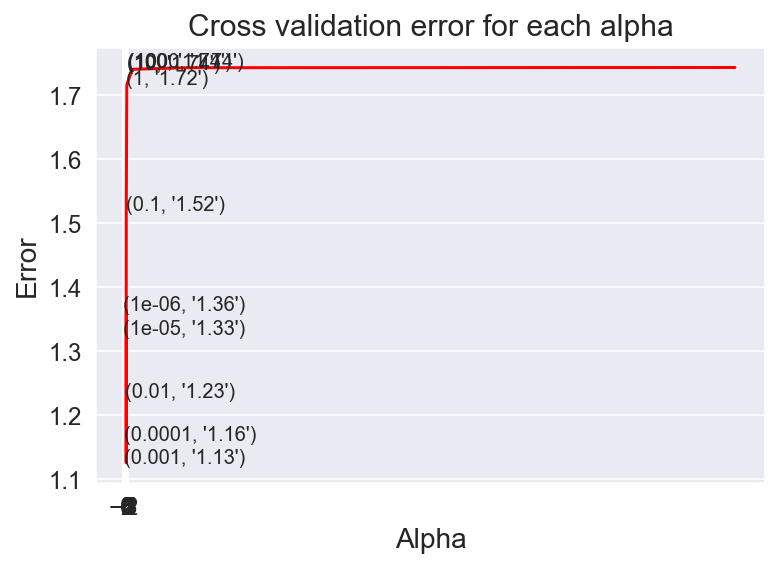

[ Best alpha : 0.001 ]
[Train loss] (0.5234781138439686)
[CV loss] (1.1254267665036128)
[Test loss] (1.1216960307635777)
[Test Log loss] (1.1216960307635777)
Number of missclassified points : 0.3533834586466165


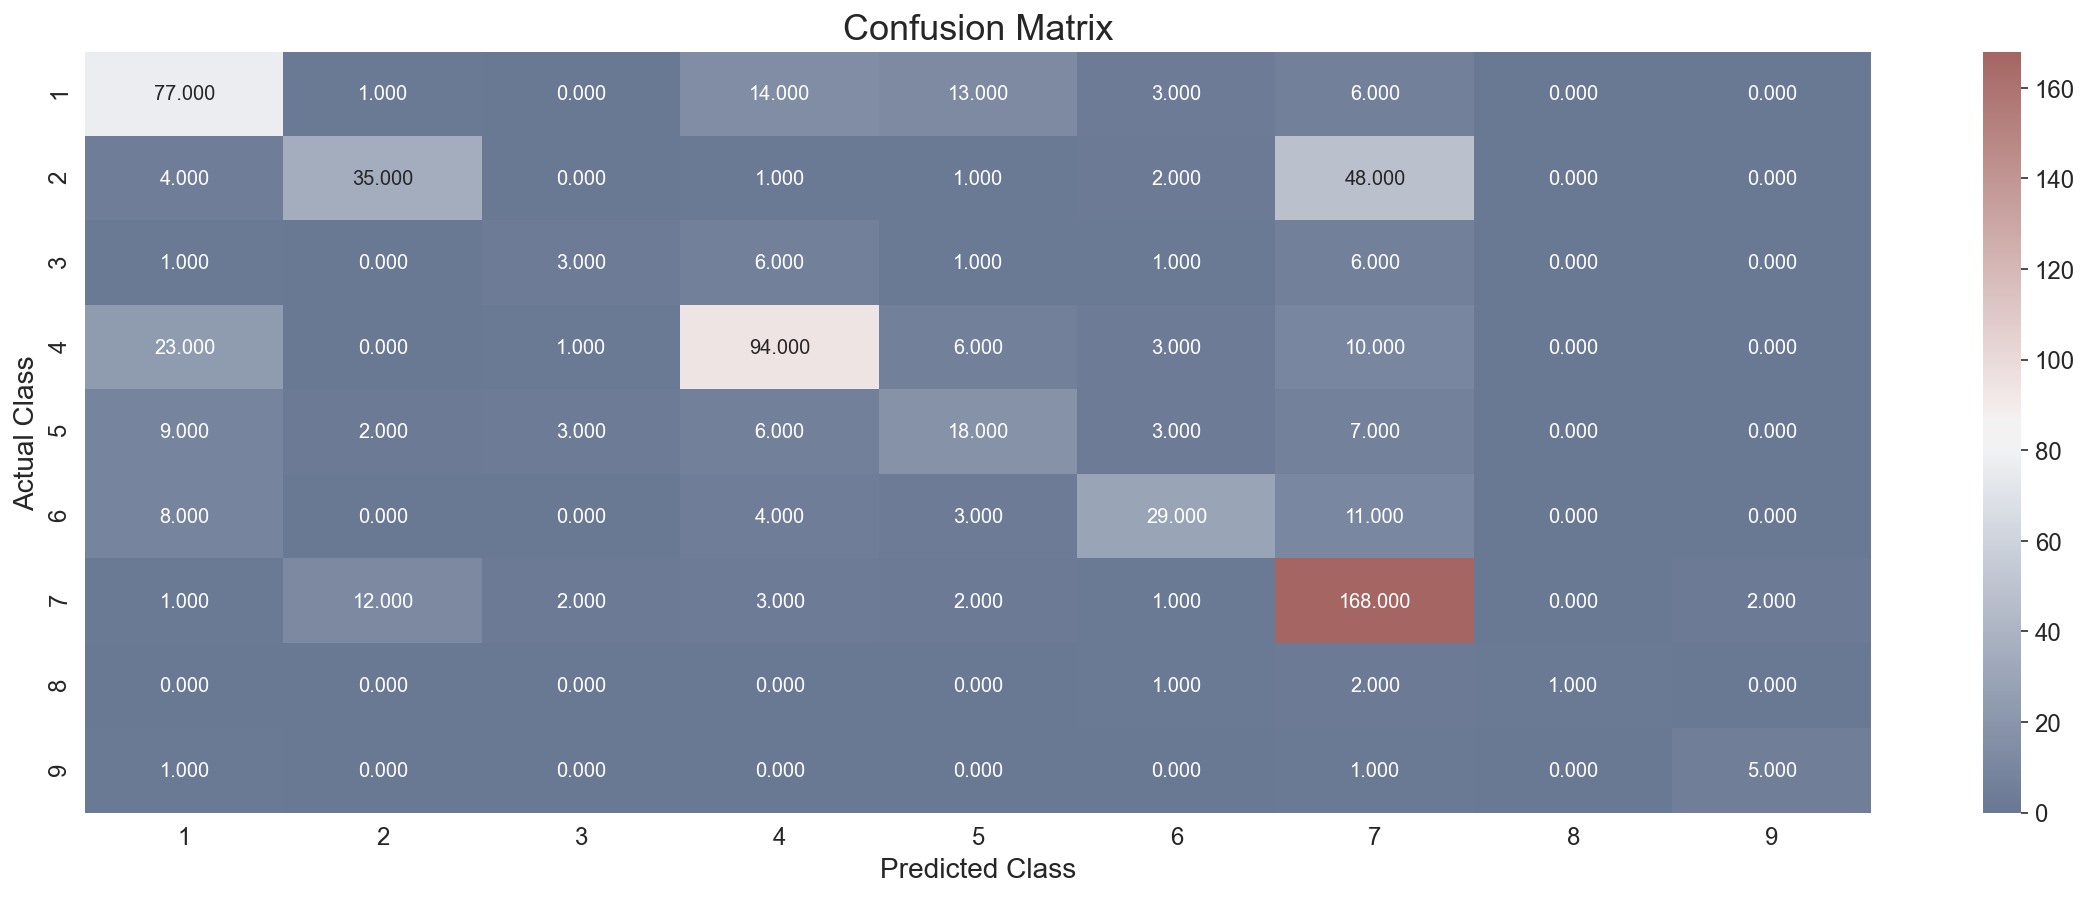

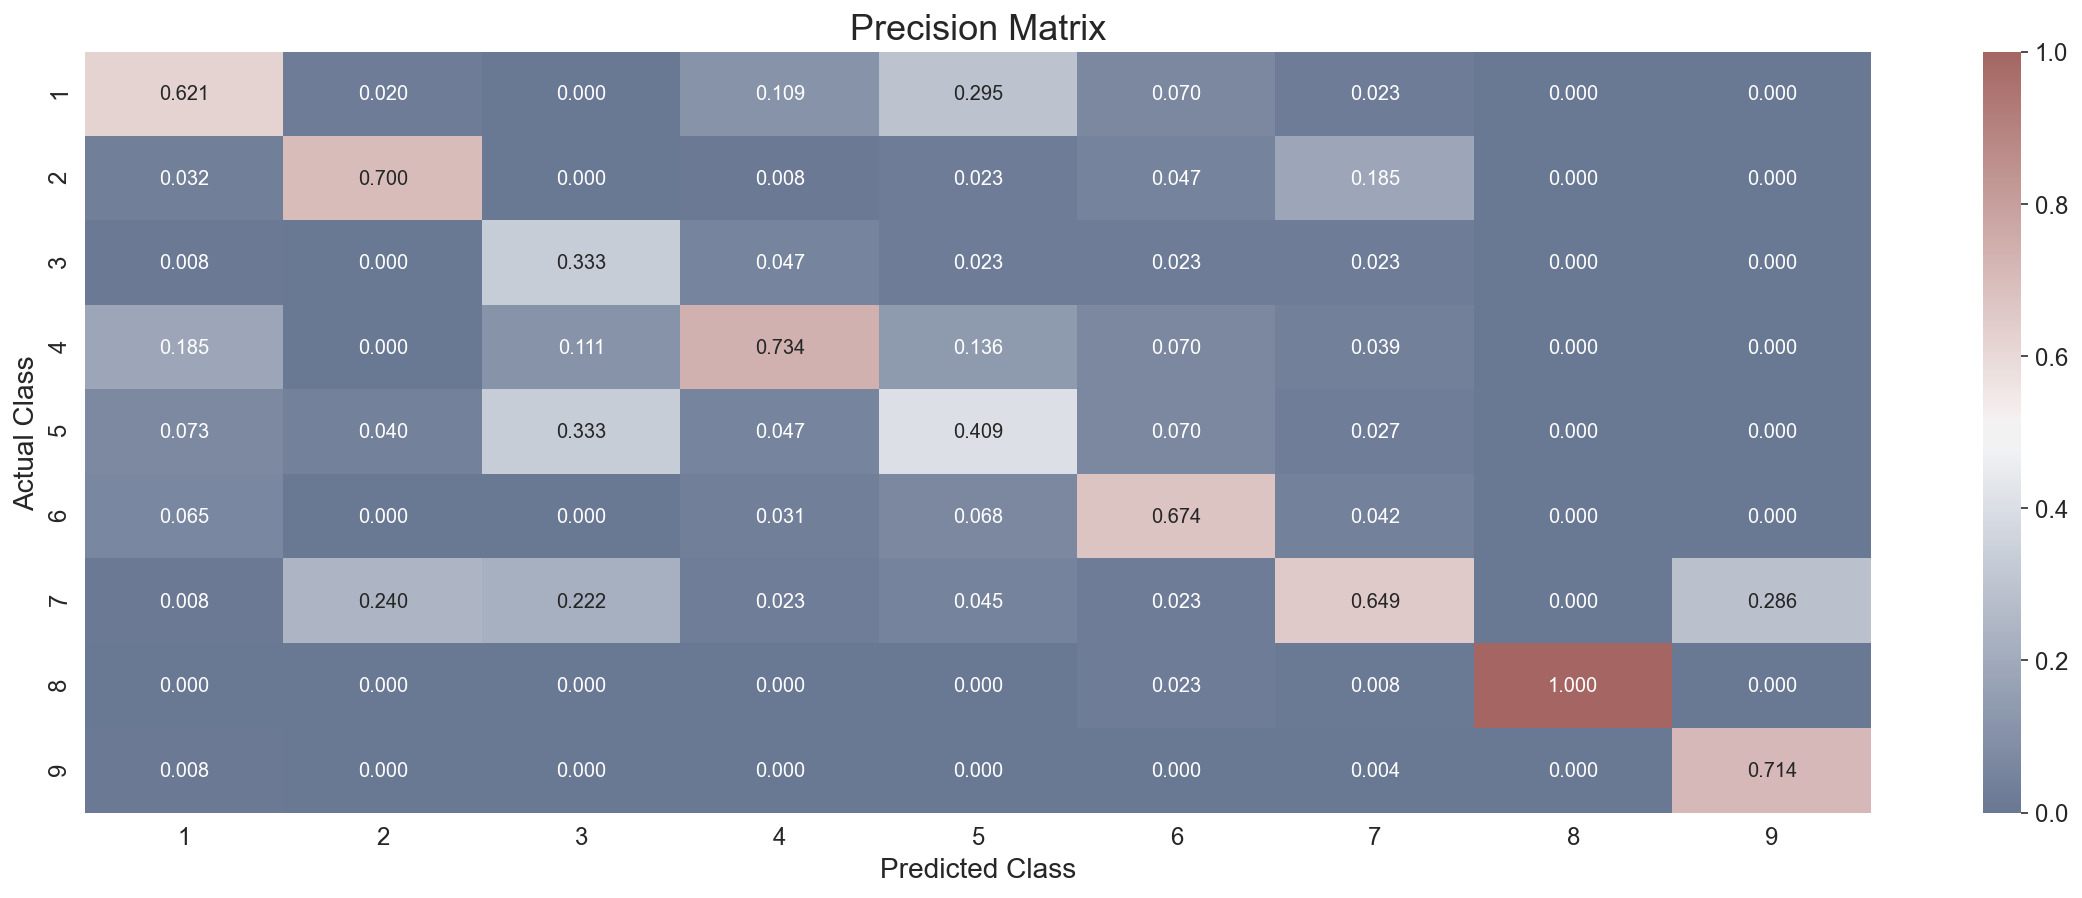

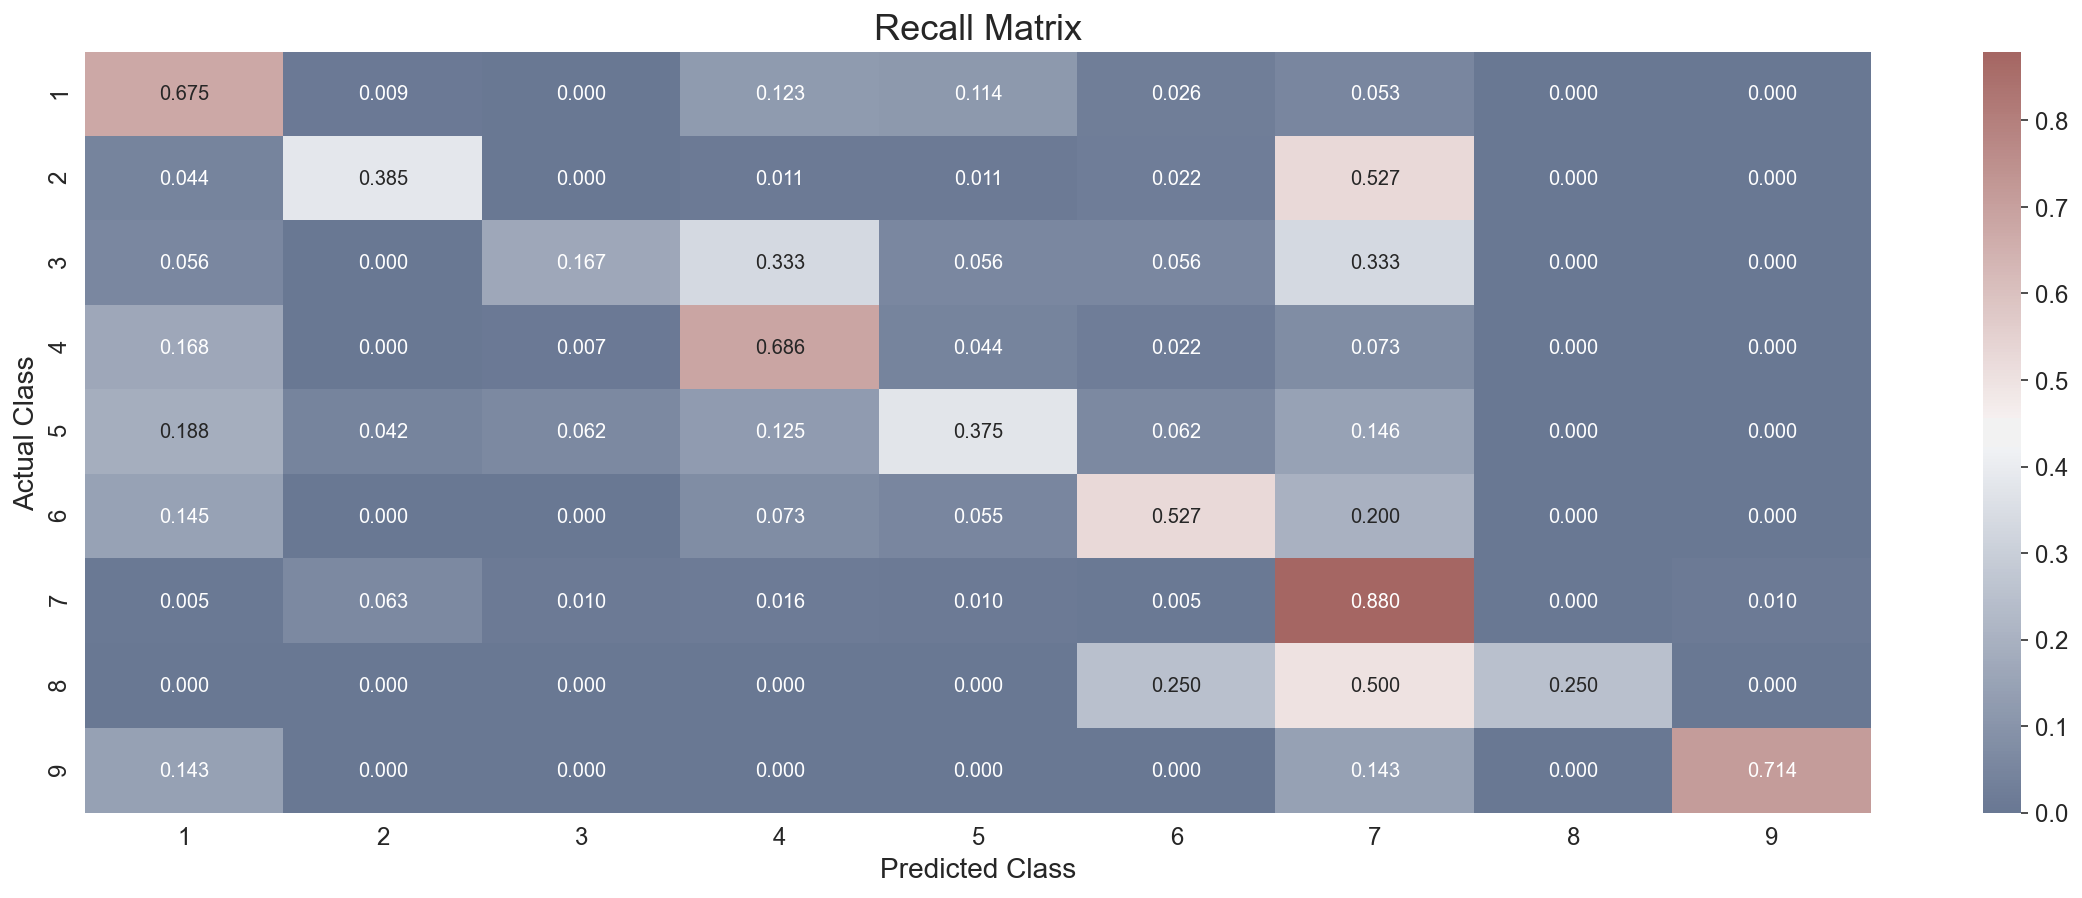

Gene : freq Encoding
Variation : freq Encoding
TEXT : Uni+Bi gram
[log_loss] (1.8308894970074714) alpha [1e-06]
[log_loss] (1.3975739550630668) alpha [1e-05]
[log_loss] (1.3002114568457757) alpha [0.0001]
[log_loss] (1.3000402651779155) alpha [0.001]
[log_loss] (1.2211256610807706) alpha [0.01]
[log_loss] (1.2809236832252964) alpha [0.1]
[log_loss] (1.6833557954229579) alpha [1]
[log_loss] (1.8313891808492846) alpha [10]
[log_loss] (1.8429774477851832) alpha [100]
[log_loss] (1.8416937629572496) alpha [1000]


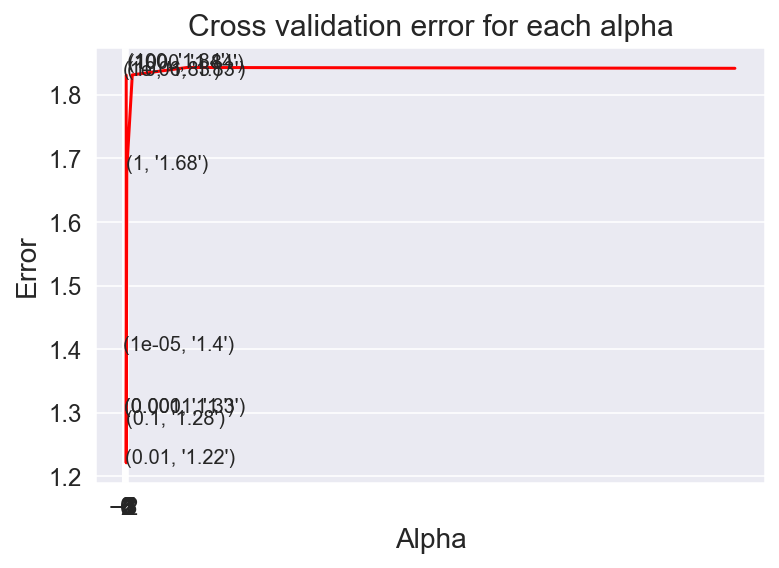

[ Best alpha : 0.01 ]
[Train loss] (0.9386531879284514)
[CV loss] (1.2211256610807706)
[Test loss] (1.231988020822841)
[Test Log loss] (1.231988020822841)
Number of missclassified points : 0.38345864661654133


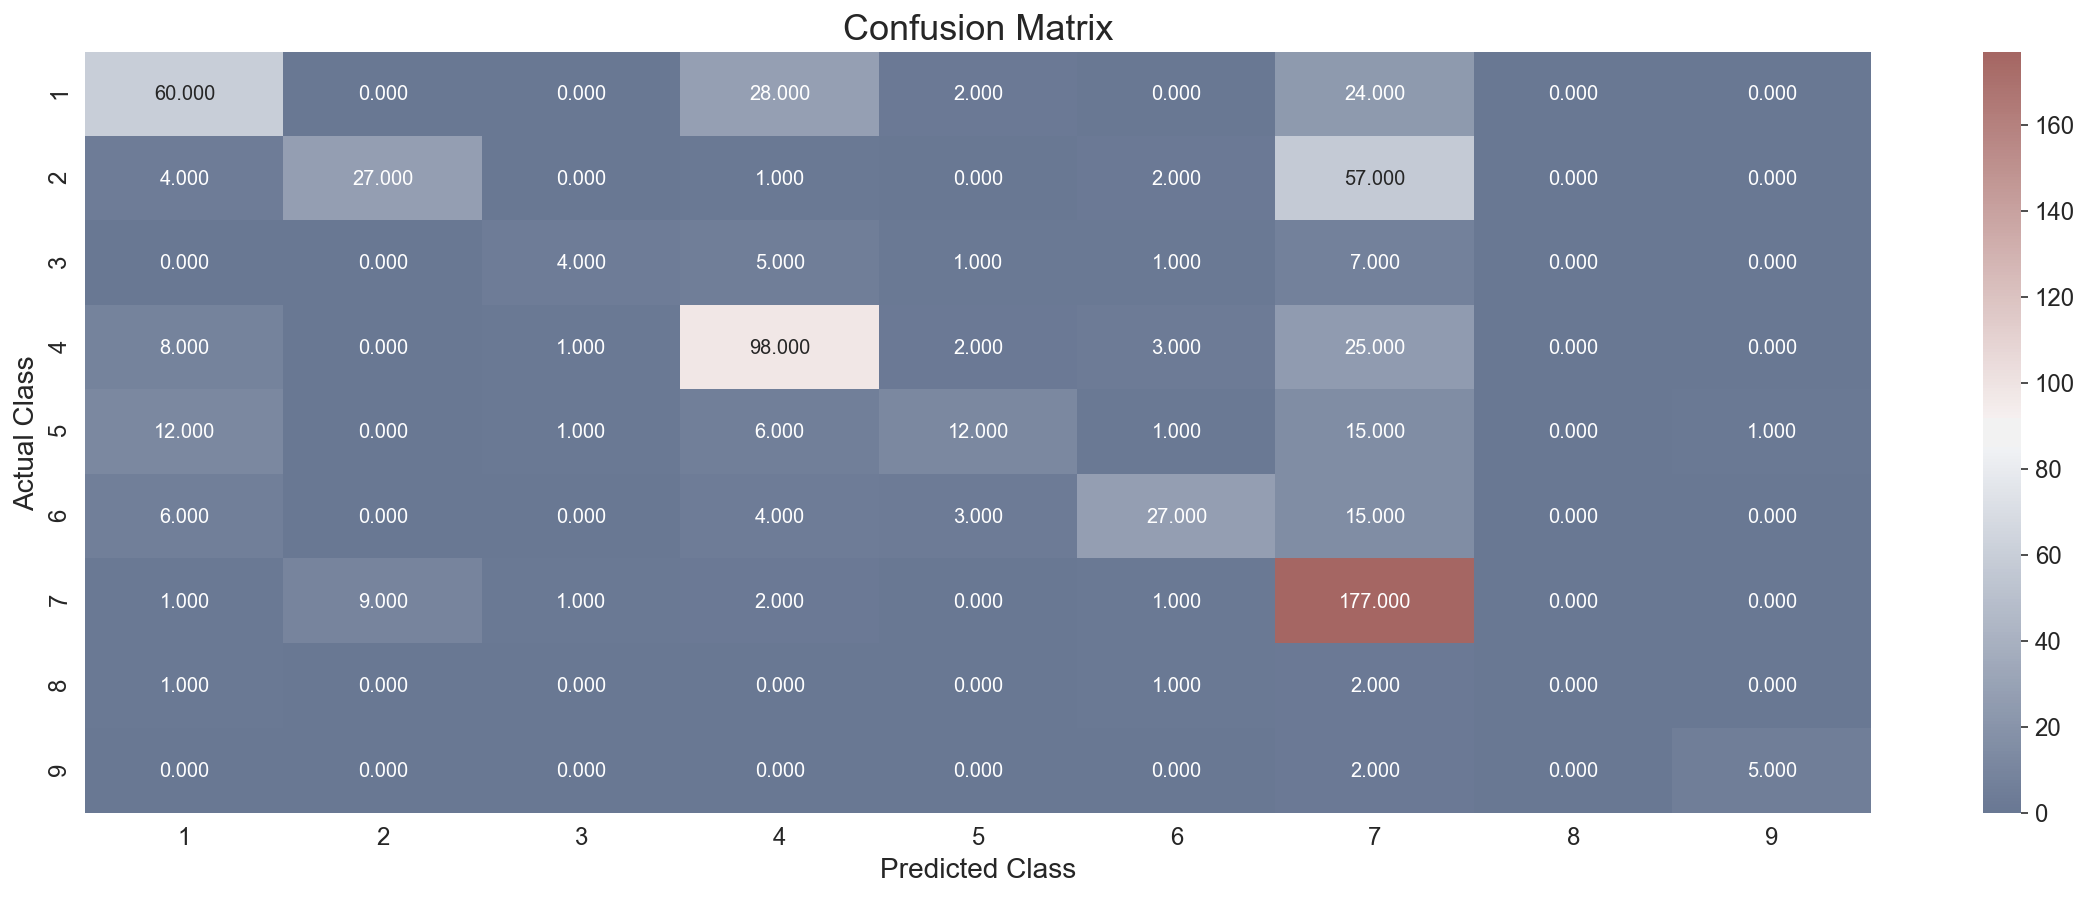

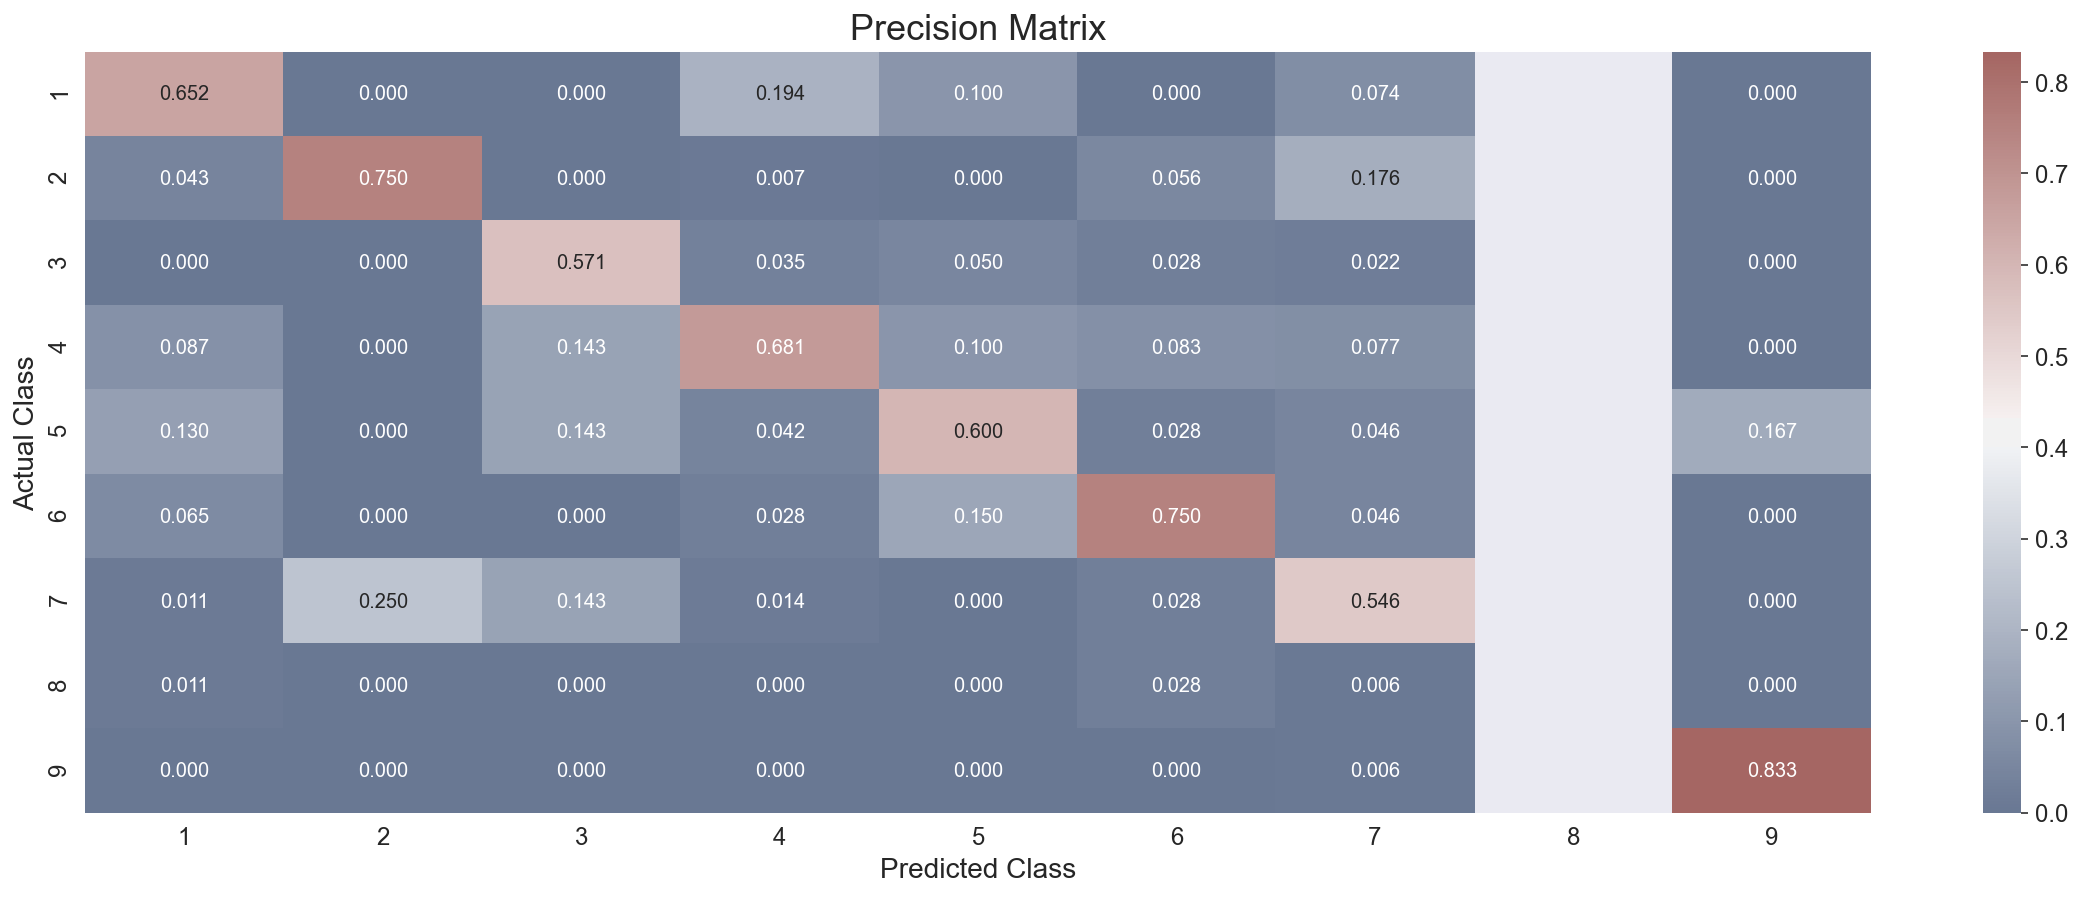

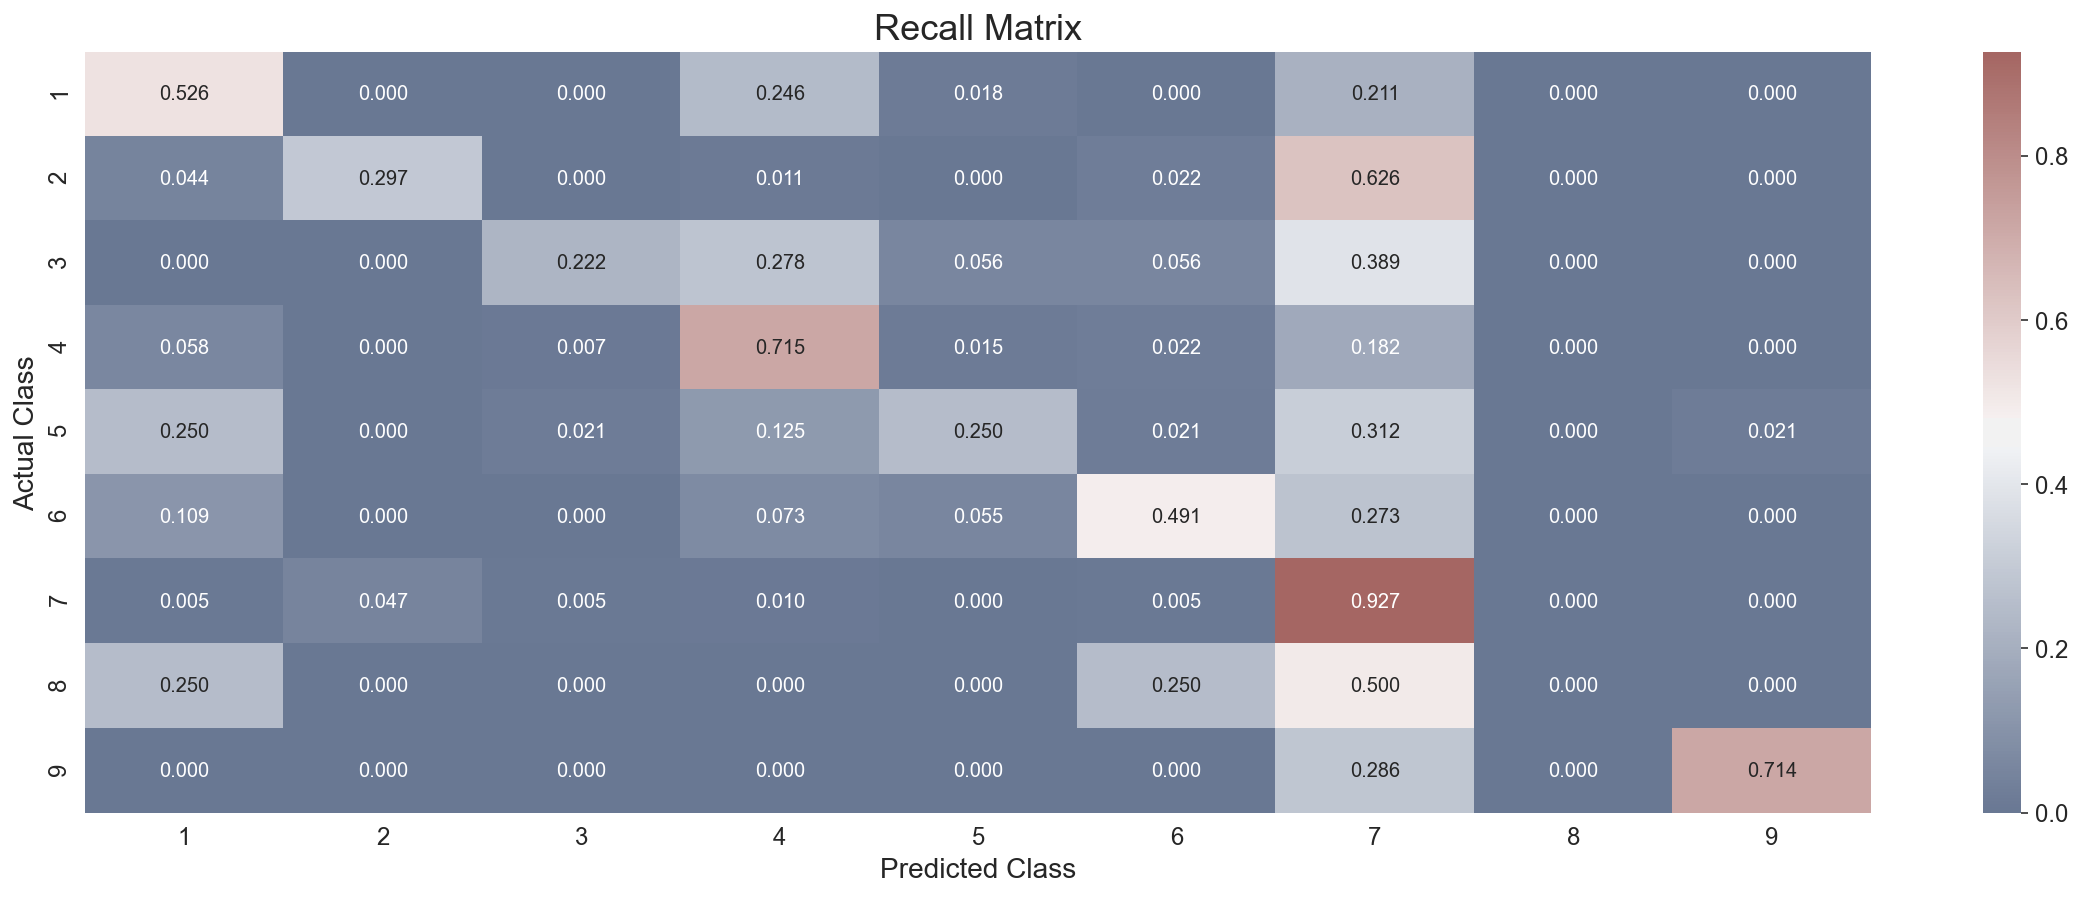

In [37]:
vect_method = ['BOW', 'Uni+Bi gram']
encode_method = ['ohe', 'freq']
data_instance =[[X_train_ohe_bow, X_cv_ohe_bow, X_test_ohe_bow],
                [X_train_freq_uni_bi, X_cv_freq_uni_bi, X_test_freq_uni_bi]]


for o in range(len(encode_method)):
    print("=======")
    print(f"Gene : {encode_method[o]} Encoding")
    print(f"Variation : {encode_method[o]} Encoding")
    print(f"TEXT : {vect_method[o]}")
    print("=======")
    alpha = [10**x for x in range(-6, 4)]
    cv_log_error = []
    for k in alpha:
        clf = SGDClassifier(class_weight='balanced', alpha = k, penalty='l2', loss='log', random_state=1)
        clf.fit(data_instance[o][0], y_train)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(data_instance[o][0], y_train)
        y_pred = sig_clf.predict_proba(data_instance[o][1])
        cv_log_error.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
        print(f"[log_loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)}) alpha [{k}]")

    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error, c='r')
    for i, txt in enumerate(np.round(cv_log_error,2)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
    plt.xticks(np.log10(alpha))
    plt.title("Cross validation error for each alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error")
    plt.show()

    best_alpha = np.argmin(cv_log_error)
    print("=====================")
    print(f"[ Best alpha : {alpha[best_alpha]} ]")
    print("=====================")
    clf = SGDClassifier(class_weight='balanced', alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
    clf.fit(data_instance[o][0], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(data_instance[o][0], y_train)
    y_pred = sig_clf.predict_proba(data_instance[o][0])
    print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(data_instance[o][1])
    print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
    y_pred = sig_clf.predict_proba(data_instance[o][2])
    print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
    print("="*53)
    predict_and_plot_confusion_matrix(data_instance[o][0], data_instance[o][2], y_train, y_test, clf=SGDClassifier(class_weight='balanced', alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1))

    cv_log_error.clear()
    print("="*70)

In [40]:
## feature importance

def get_feature_importance(indices, text, removed_ind = []):
    word_present = 0
    tabulate_list = []
    increasingorder_ind = 0
    for i in indices:
        if i < X_train_ohe_bow.shape[1]:
            tabulate_list.append([increasingorder_ind, "Gene", "Yes"])
        elif i < 18:
            tabulate_list.append([increasingorder_ind, "Variation", "Yes"])
        if (i > 17) & (i not in removed_ind):
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            
            if yes_no:
                word_present += 1
            tabulate.append([increasingorder_ind, train_text_features[i], yes_no])
        increasingorder_ind += 1
        
    print(word_present, "Most important feature are present in our query point.")
    print("="*50)
    print("Features that are most important of the ", predicted_cls[0], "class")
    print(tabulate(taulate_list, headers=['index', 'Feature name', "Present or Not"]))

In [43]:
## Correctly classified points

test_point_index = 1
no_feature = 100

clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted class probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]), 2))
print("Actual class:",y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]

Predicted Class: 6
Predicted class probabilities: [[0.01 0.   0.   0.01 0.12 0.85 0.   0.   0.  ]]
Actual class: 6


In [46]:
## Incorrectly classified point

test_point_index = 102
no_feature = 100

clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted class probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]), 2))
print("Actual class:",y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]

Predicted Class: 7
Predicted class probabilities: [[0.1  0.17 0.02 0.07 0.05 0.09 0.49 0.01 0.01]]
Actual class: 2



#### without balancing the classe's : logistic regression

[Log loss] is (1.189) alpha (0.0001)
[Log loss] is (1.142) alpha (0.001)
[Log loss] is (1.283) alpha (0.01)
[Log loss] is (1.391) alpha (0.1)
[Log loss] is (1.574) alpha (1)
[Log loss] is (1.618) alpha (10)
[Log loss] is (1.623) alpha (100)


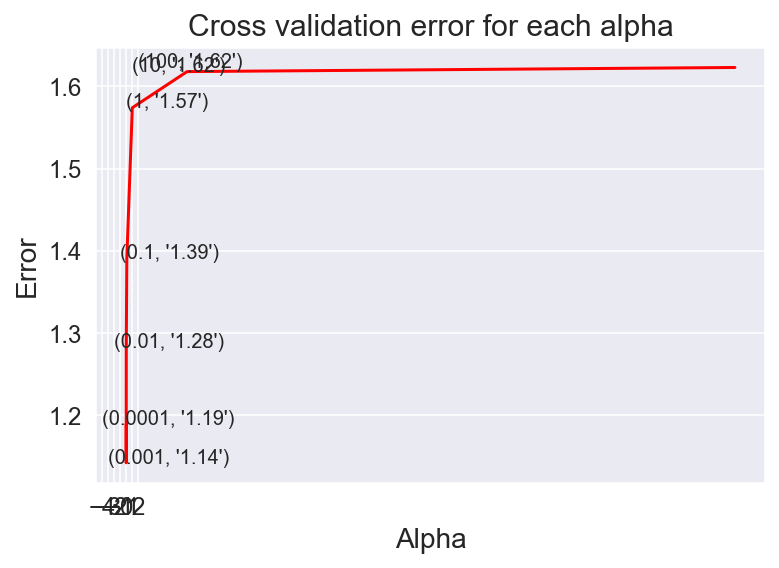

[ Best alpha : 0.001 ]
[Train loss] (0.5236958608494189)
[CV loss] (1.1420096002110975)
[Test loss] (1.137583436510005)
[Test Log loss] (1.1216960307635777)
Number of missclassified points : 0.3533834586466165


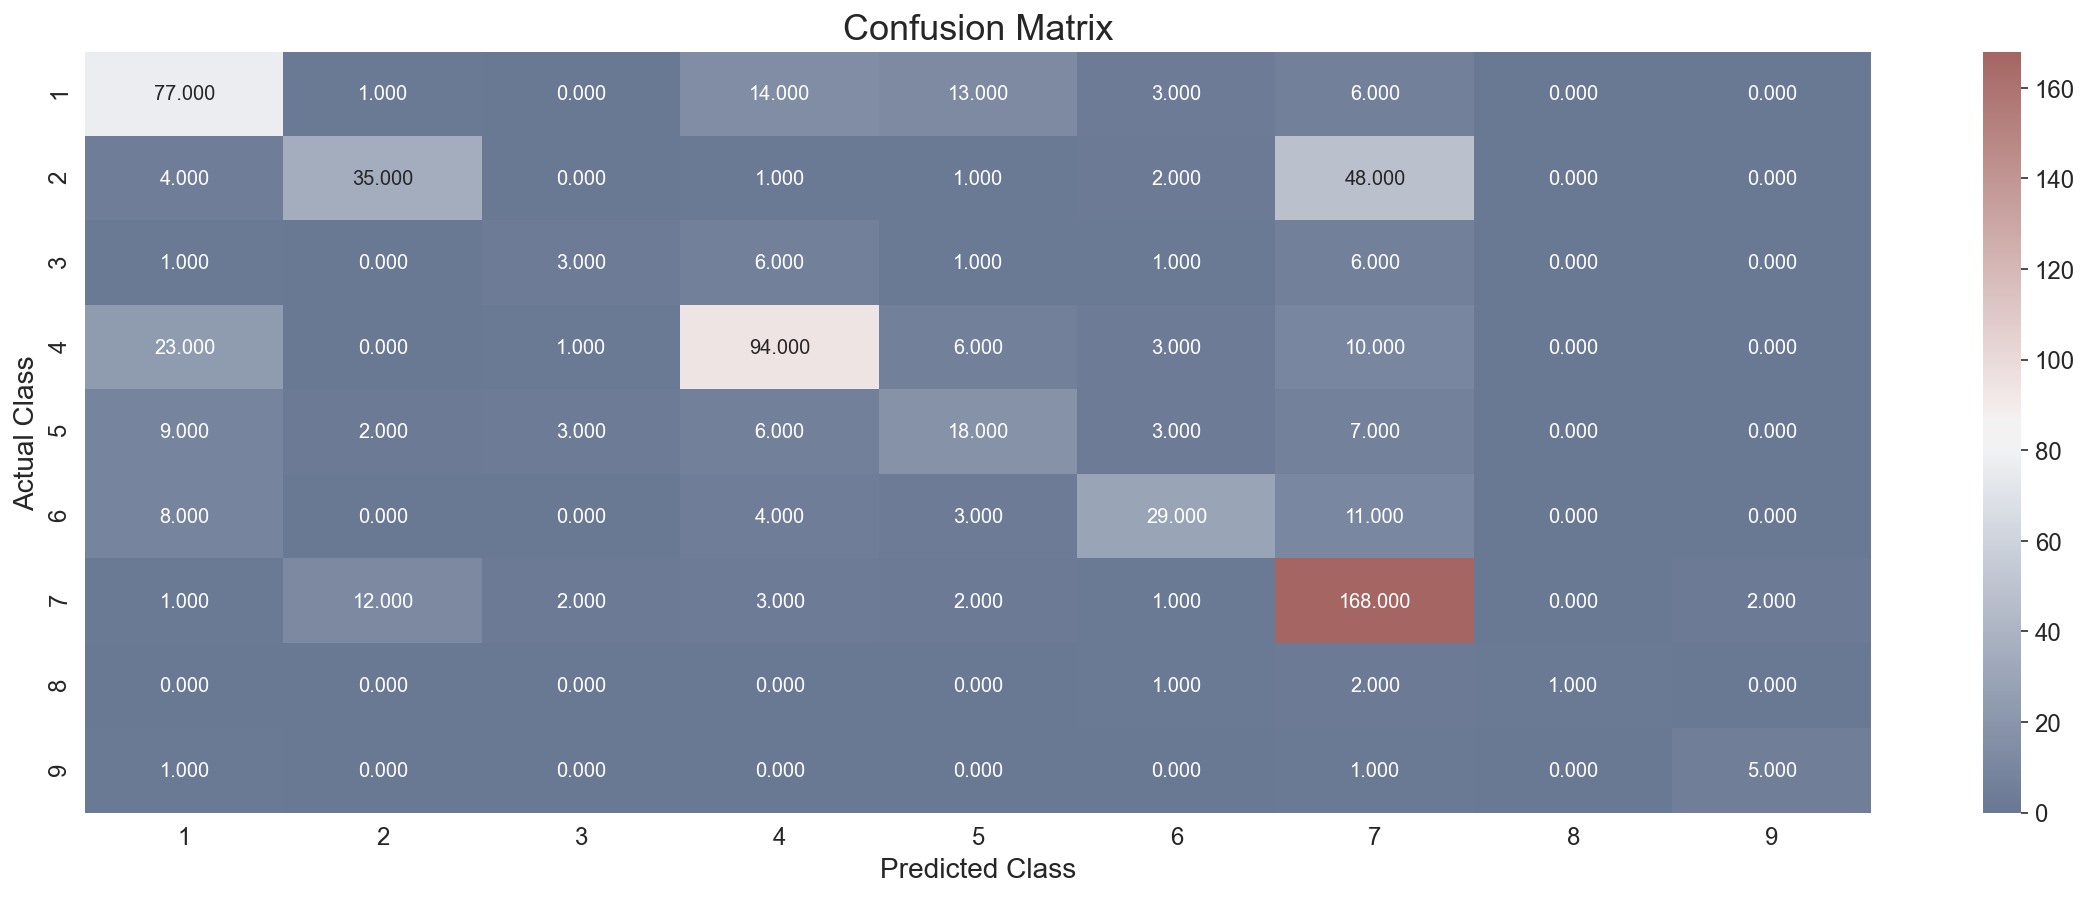

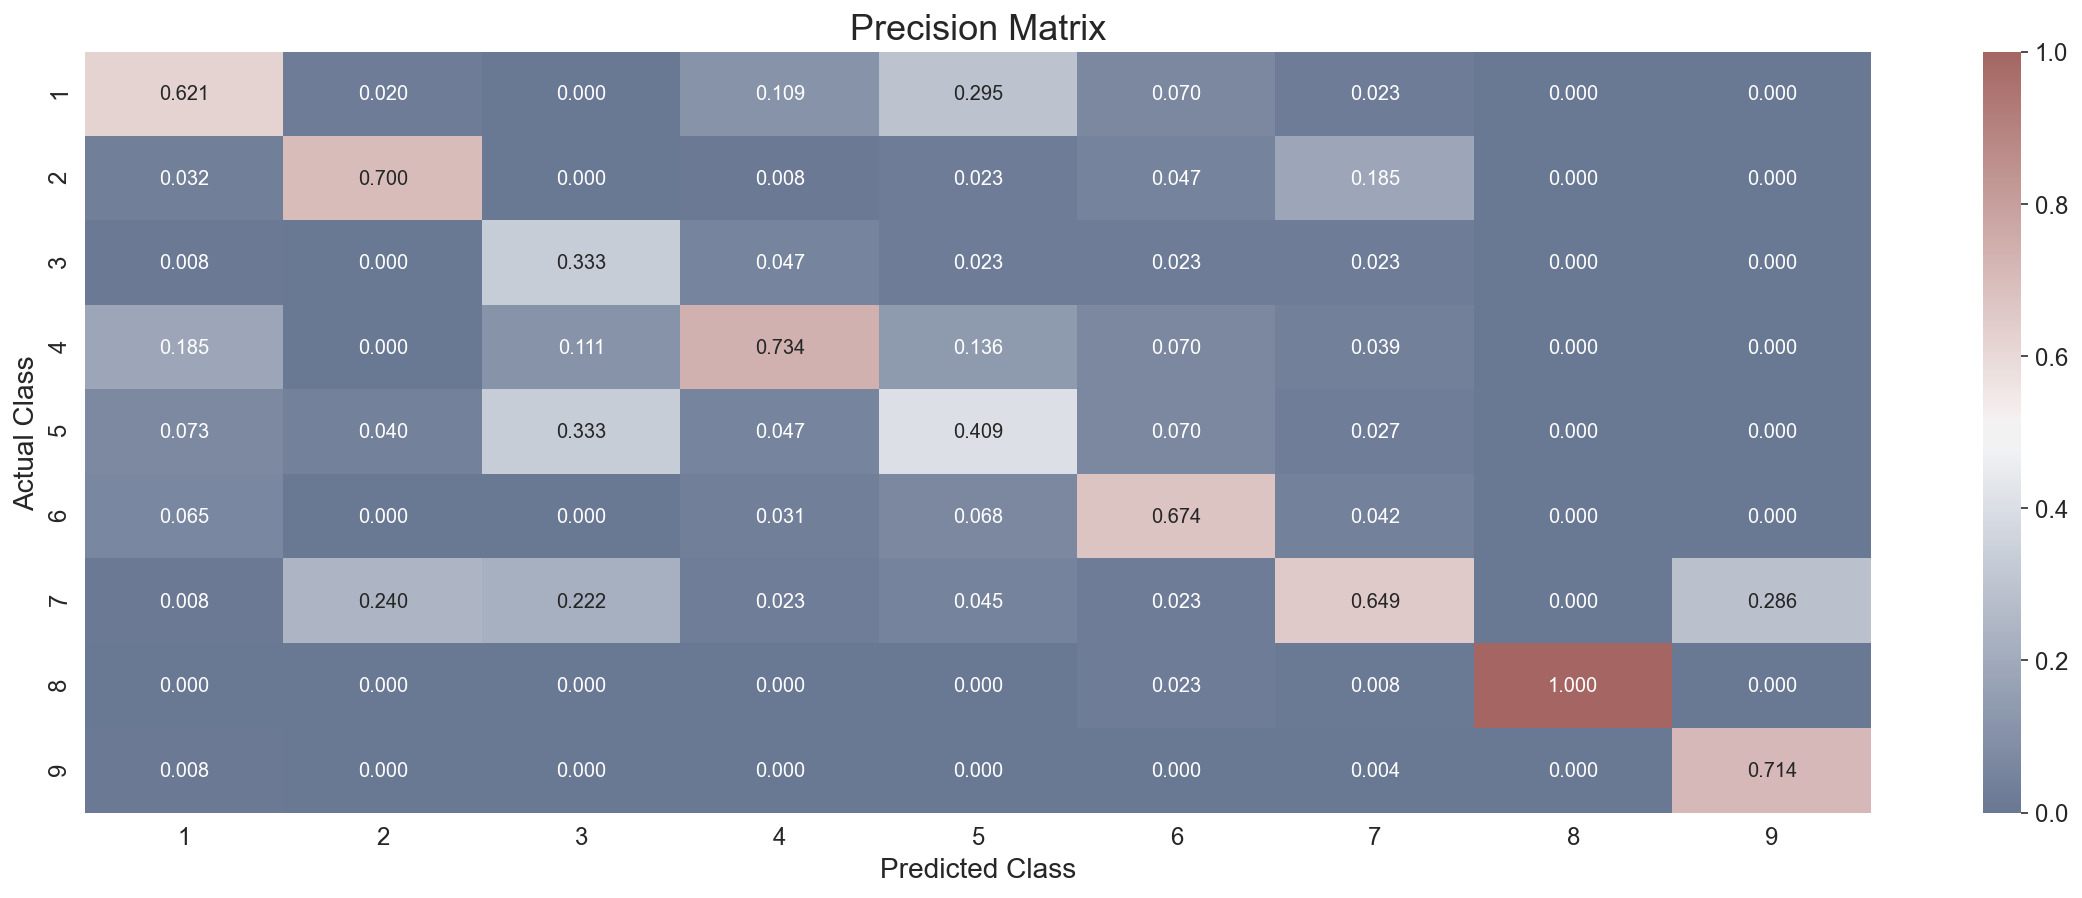

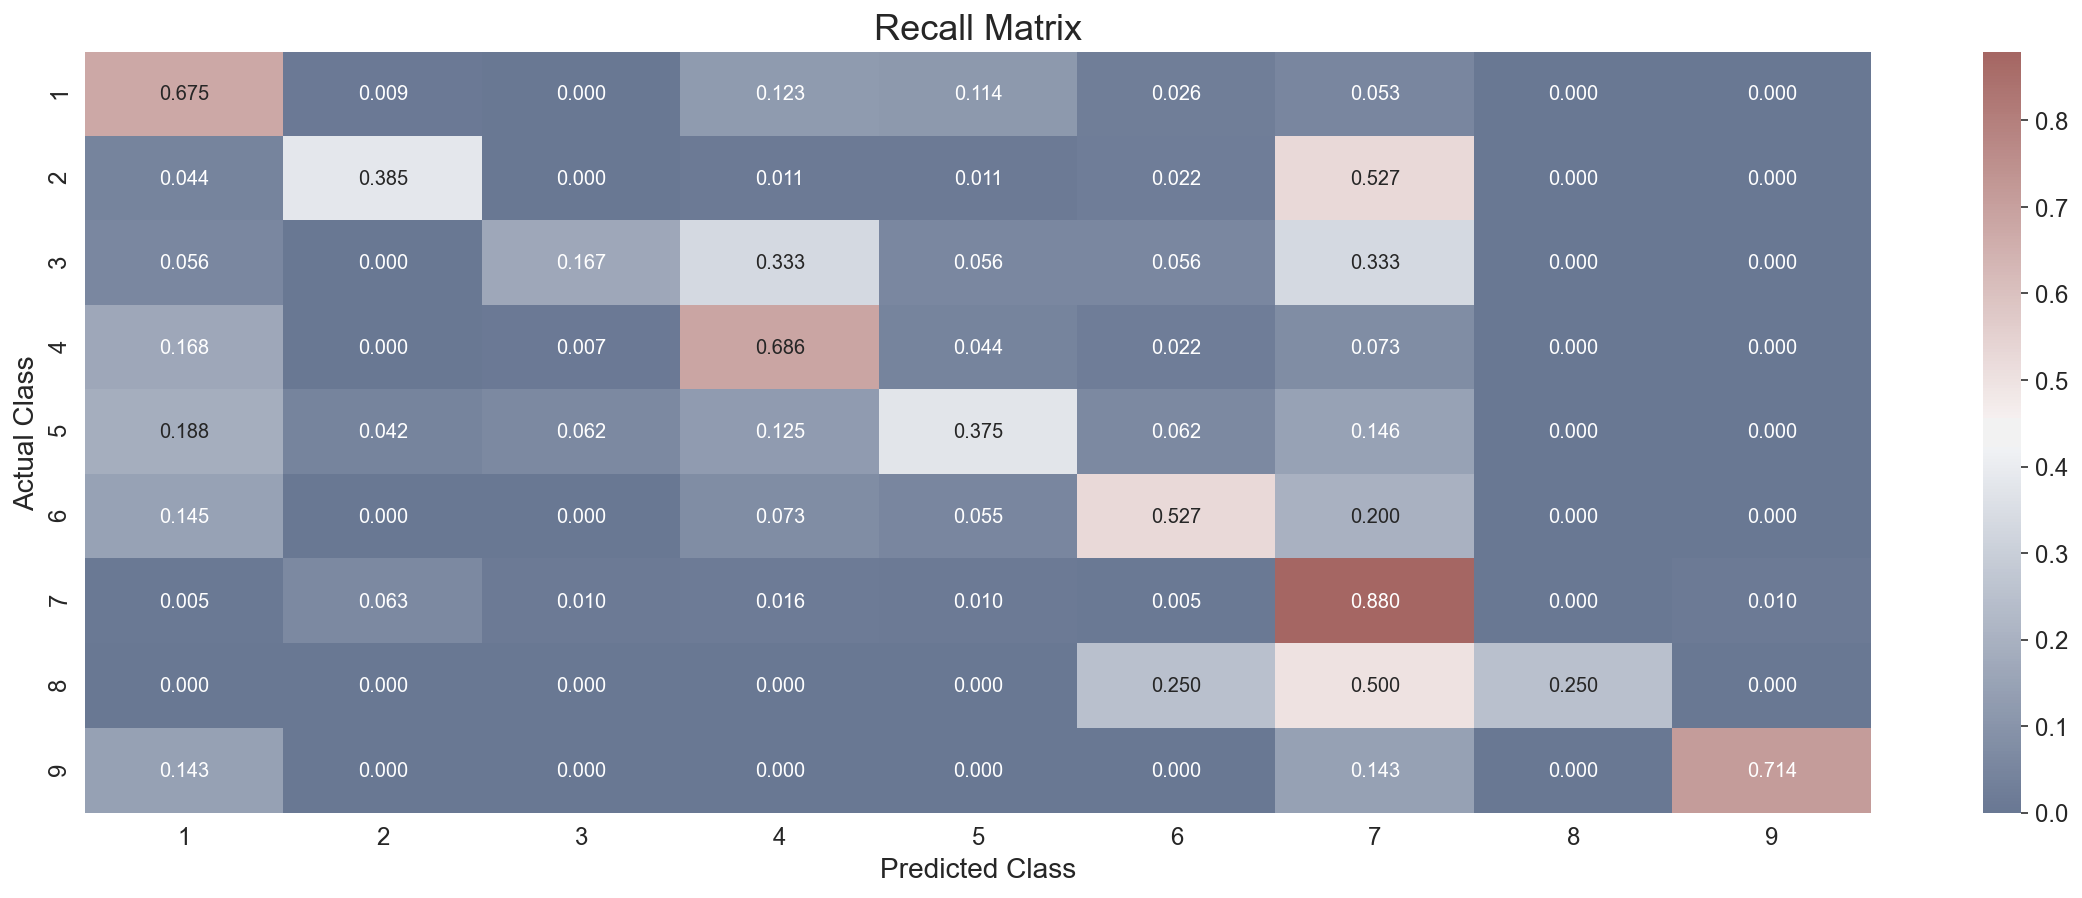

In [48]:
alpha = [10**x for x in range(-4, 3)]
cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1)
    clf.fit(X_train_ohe_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_ohe_bow, y_train)
    y_pred = sig_clf.predict_proba(X_cv_ohe_bow)
    loss = np.round(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15), 3)
    cv_log_error.append(loss)
    print(f"[Log loss] is ({loss}) alpha ({i})")

    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='r')
for i, txt in enumerate(np.round(cv_log_error,2)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
plt.xticks(np.log10(alpha))
plt.title("Cross validation error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error)
print("=====================")
print(f"[ Best alpha : {alpha[best_alpha]} ]")
print("=====================")
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_ohe_bow, y_train)
y_pred = sig_clf.predict_proba(X_train_ohe_bow)
print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
y_pred = sig_clf.predict_proba(X_cv_ohe_bow)
print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
y_pred = sig_clf.predict_proba(X_test_ohe_bow)
print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
print("="*53)
predict_and_plot_confusion_matrix(X_train_ohe_bow, X_test_ohe_bow, y_train, y_test, clf=SGDClassifier(class_weight='balanced', alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=1))


In [49]:
## correctly classified points
print("Correctly classified points...")
test_point_index = 1
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)
## incorrectly classified points
print("Inorrectly classified points...")
test_point_index = 101
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)

Correctly classified points...
Predicted Class : 6
Predicted Class Probabilities: [[0.006 0.004 0.002 0.01  0.101 0.87  0.003 0.004 0.   ]]
Actual Class : 6
Inorrectly classified points...
Predicted Class : 7
Predicted Class Probabilities: [[0.22  0.302 0.014 0.058 0.047 0.026 0.31  0.019 0.004]]
Actual Class : 8


In [56]:
bow = PrettyTable()
bow.field_names = ["clf", "Classe's", "Encoding Method", "best alpha", "Test loss", "MisClassified %"]

bow.add_rows(
    [
        ["Logistic Reg", "Balanced", "One Hot Encoding",0.01, 1.23, str(0.38)+"%"],
        ["Logistic Reg", "Imbalanced", "One Hot Encoding",0.001, 1.12, str(0.35)+"%"],
    ]
)

print(bow.get_string(fields=["clf", "Classe's", "Encoding Method", "best alpha", "Test loss", "MisClassified %"]))

+--------------+------------+------------------+------------+-----------+-----------------+
|     clf      |  Classe's  | Encoding Method  | best alpha | Test loss | MisClassified % |
+--------------+------------+------------------+------------+-----------+-----------------+
| Logistic Reg |  Balanced  | One Hot Encoding |    0.01    |    1.23   |      0.38%      |
| Logistic Reg | Imbalanced | One Hot Encoding |   0.001    |    1.12   |      0.35%      |
+--------------+------------+------------------+------------+-----------+-----------------+


### Linear Support Vector Machine

[Log Loss] (1.3294708697731779) alpha (C = 1e-05)
[Log Loss] (1.2482398817258218) alpha (C = 0.0001)
[Log Loss] (1.1551307627722587) alpha (C = 0.001)
[Log Loss] (1.1675584216557502) alpha (C = 0.01)
[Log Loss] (1.430345553868251) alpha (C = 0.1)
[Log Loss] (1.7279785027857157) alpha (C = 1)
[Log Loss] (1.7428514464179683) alpha (C = 10)
[Log Loss] (1.7428312516815179) alpha (C = 100)


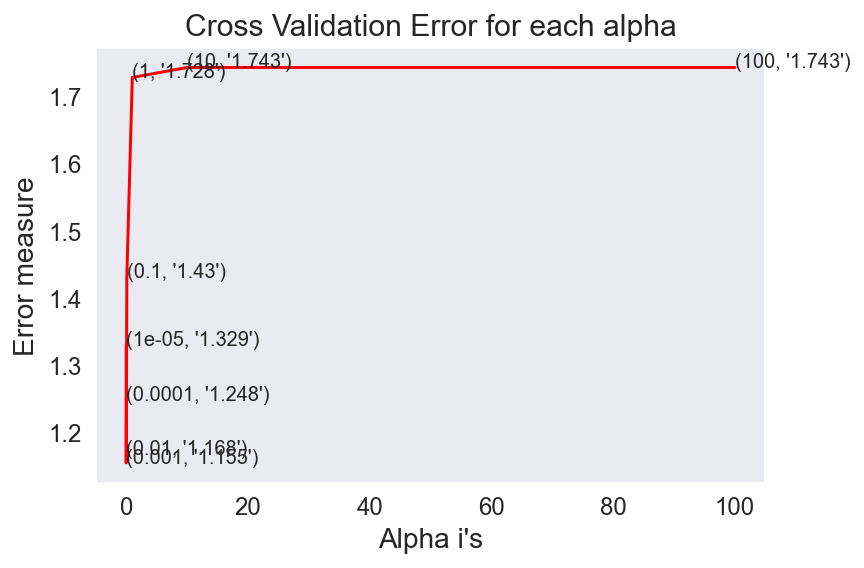

[ Best alpha : 0.001 ]
[Train loss] (0.5296074689641738)
[CV loss] (1.1551307627722587)
[Test loss] (1.2136706499346084)
[Test Log loss] (1.2136706499346084)
Number of missclassified points : 0.35639097744360904


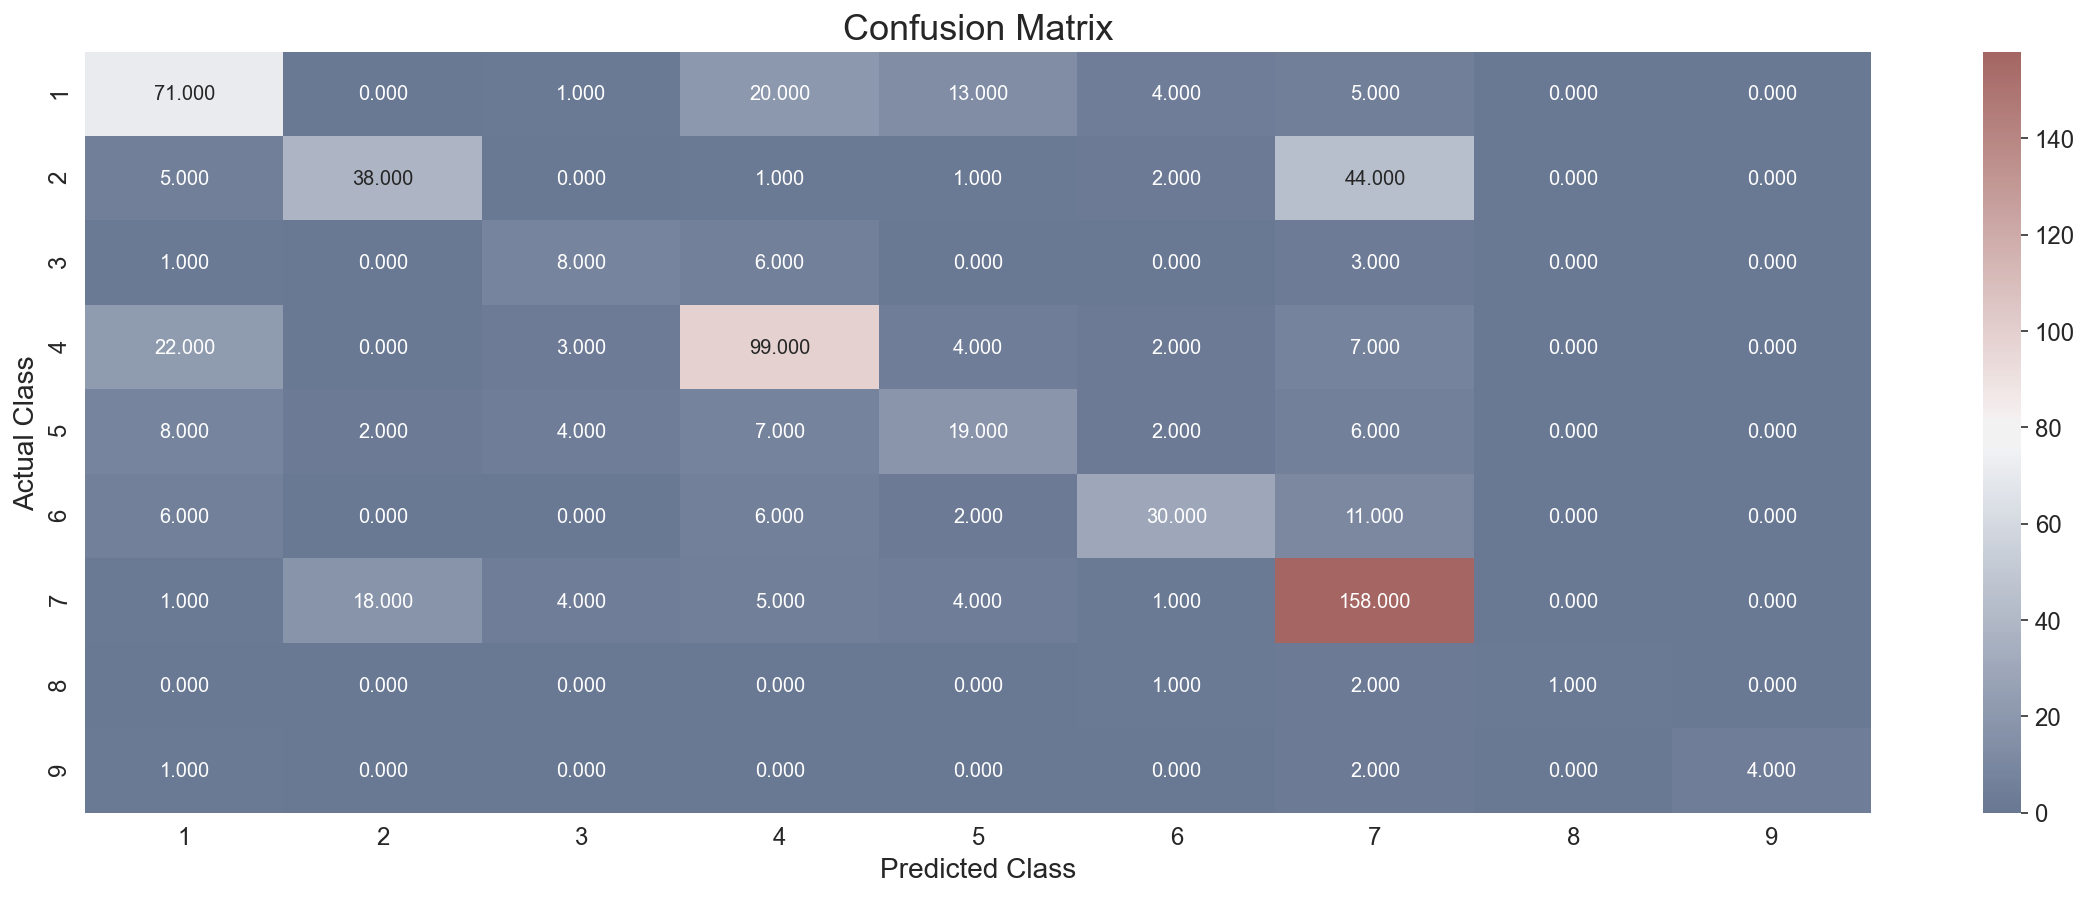

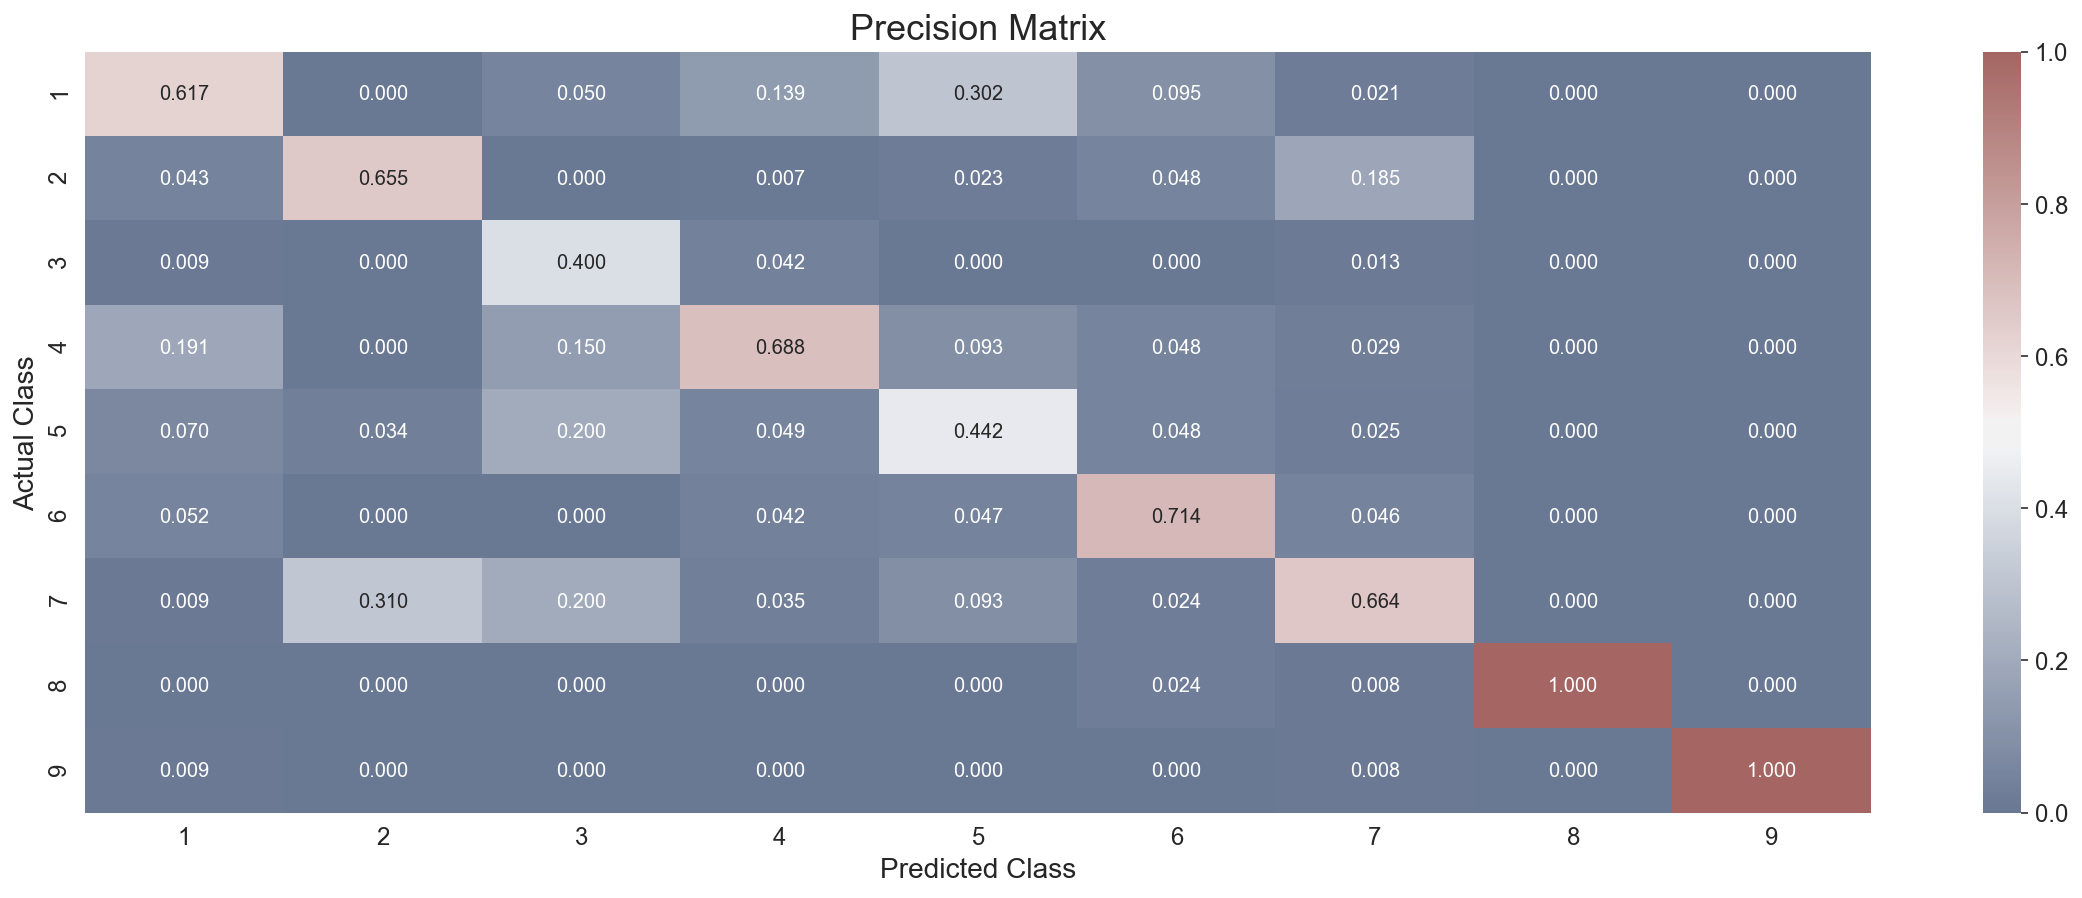

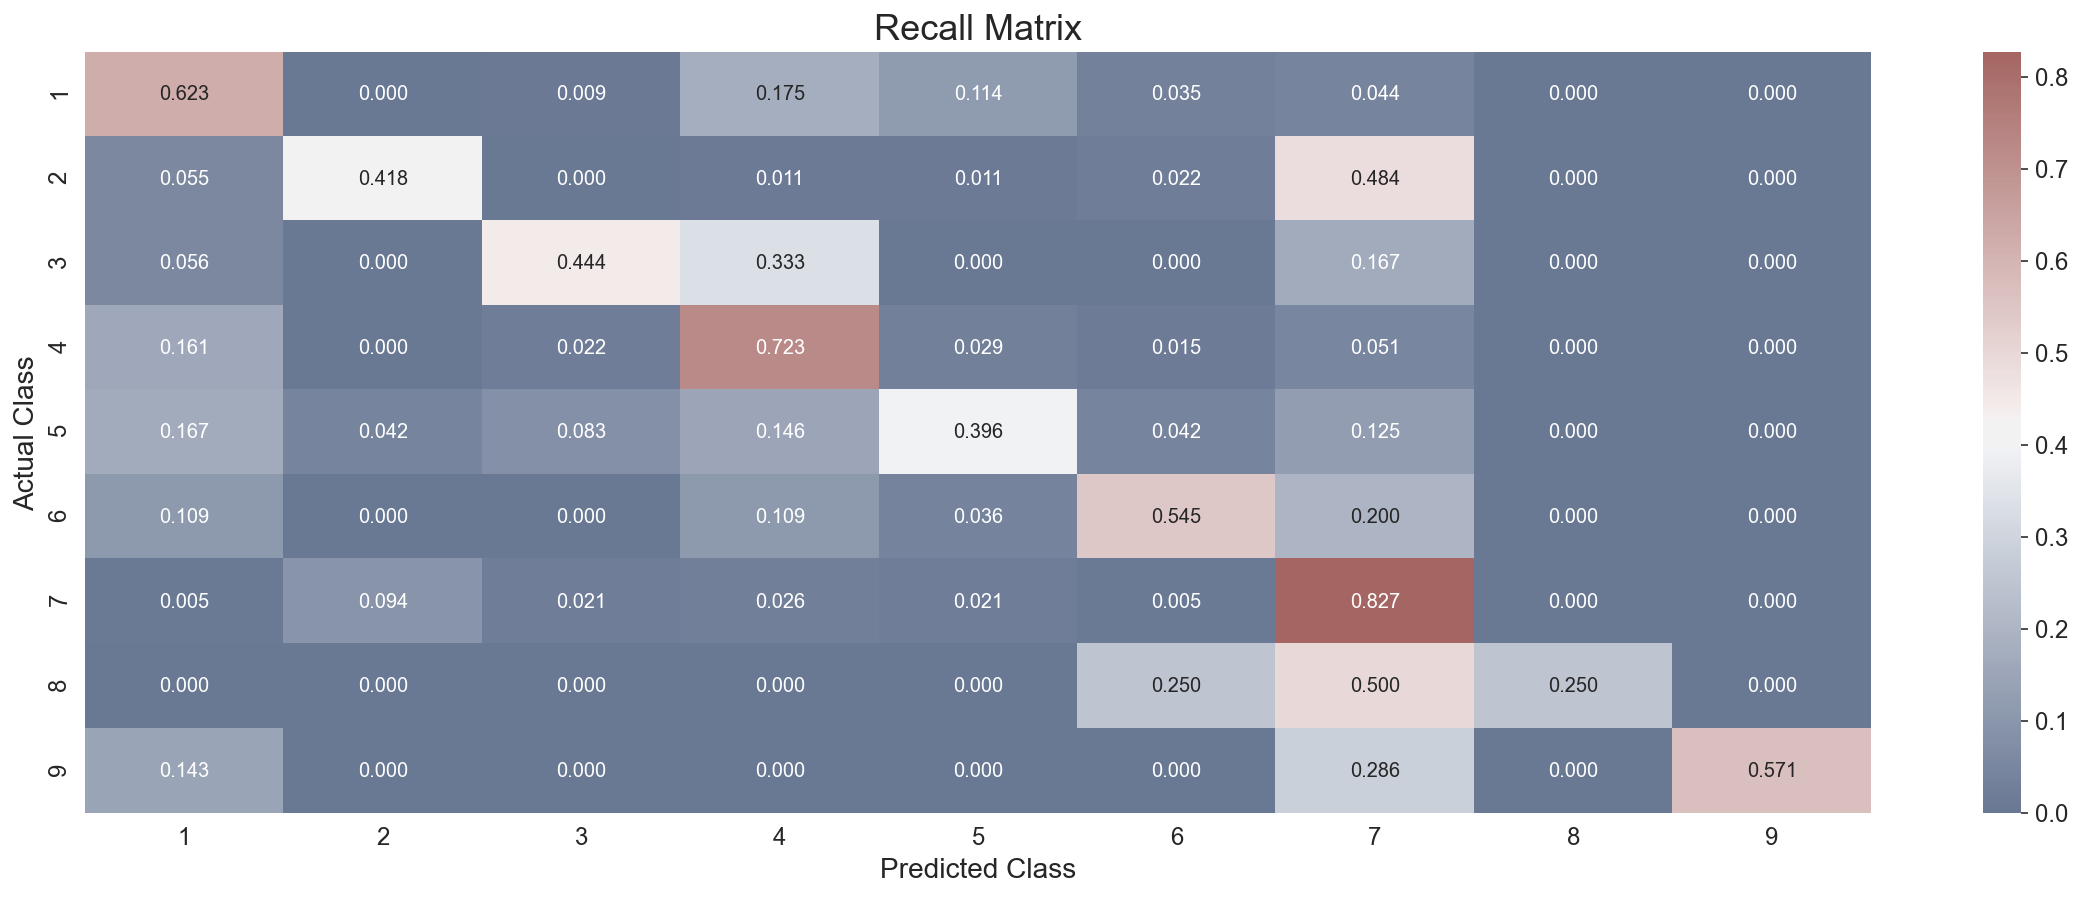

In [52]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error = []
for i in alpha:
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=1)
    clf.fit(X_train_ohe_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_ohe_bow, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_ohe_bow)
    cv_log_error.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print(f"[Log Loss] ({log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15)}) alpha (C = {i})" ) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='r')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
print("=====================")
print(f"[ Best alpha : {alpha[best_alpha]} ]")
print("=====================")
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_ohe_bow, y_train)

y_pred = sig_clf.predict_proba(X_train_ohe_bow)
print(f"[Train loss] ({log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15)})")
y_pred = sig_clf.predict_proba(X_cv_ohe_bow)
print(f"[CV loss] ({log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15)})")
y_pred = sig_clf.predict_proba(X_test_ohe_bow)
print(f"[Test loss] ({log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15)})")
print("="*53)
predict_and_plot_confusion_matrix(X_train_ohe_bow, X_test_ohe_bow, y_train, y_test, clf=clf)

In [53]:
## correctly classified points
print("Correctly classified points...")
test_point_index = 1
clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='hinge', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)
## incorrectly classified points
print("Inorrectly classified points...")
test_point_index = 101
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)

Correctly classified points...
Predicted Class : 6
Predicted Class Probabilities: [[0.031 0.058 0.008 0.062 0.172 0.555 0.103 0.005 0.006]]
Actual Class : 6
Inorrectly classified points...
Predicted Class : 7
Predicted Class Probabilities: [[0.199 0.182 0.02  0.094 0.078 0.042 0.286 0.082 0.016]]
Actual Class : 8


In [55]:
bow = PrettyTable()
bow.field_names = ["clf", "Classe's", "Encoding Method", "best alpha", "Test loss", "MisClassified %"]

bow.add_rows(
    [
        ["Linear SVM", "Balanced", "One Hot Encoding",0.001, 1.21, str(0.36)+"%"],
    ]
)

print(bow.get_string(fields=["clf", "Classe's", "Encoding Method", "best alpha", "Test loss", "MisClassified %"]))

+------------+----------+------------------+------------+-----------+-----------------+
|    clf     | Classe's | Encoding Method  | best alpha | Test loss | MisClassified % |
+------------+----------+------------------+------------+-----------+-----------------+
| Linear SVM | Balanced | One Hot Encoding |   0.001    |    1.21   |      0.36%      |
+------------+----------+------------------+------------+-----------+-----------------+


### Random Forest Classifier

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

In [69]:

rf = RandomForestClassifier(random_state = 1)
param_grid = {'n_estimators': [50, 150, 300, 450, 700],
              'criterion': ['entropy', 'gini'],
              'bootstrap': [True],
              'max_depth': [3, 5, 10]
             }

clf_rf = GridSearchCV(rf, param_grid = param_grid, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_ohe_bow, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.2min finished


In [70]:
print(best_clf_rf.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300}


[Train loss] (0.7808639132625365)
[CV loss] (1.2837506177049565)
[Test loss] (1.2797658528104394)
[Test Log loss] (1.1787768314523996)
Number of missclassified points : 0.3819548872180451


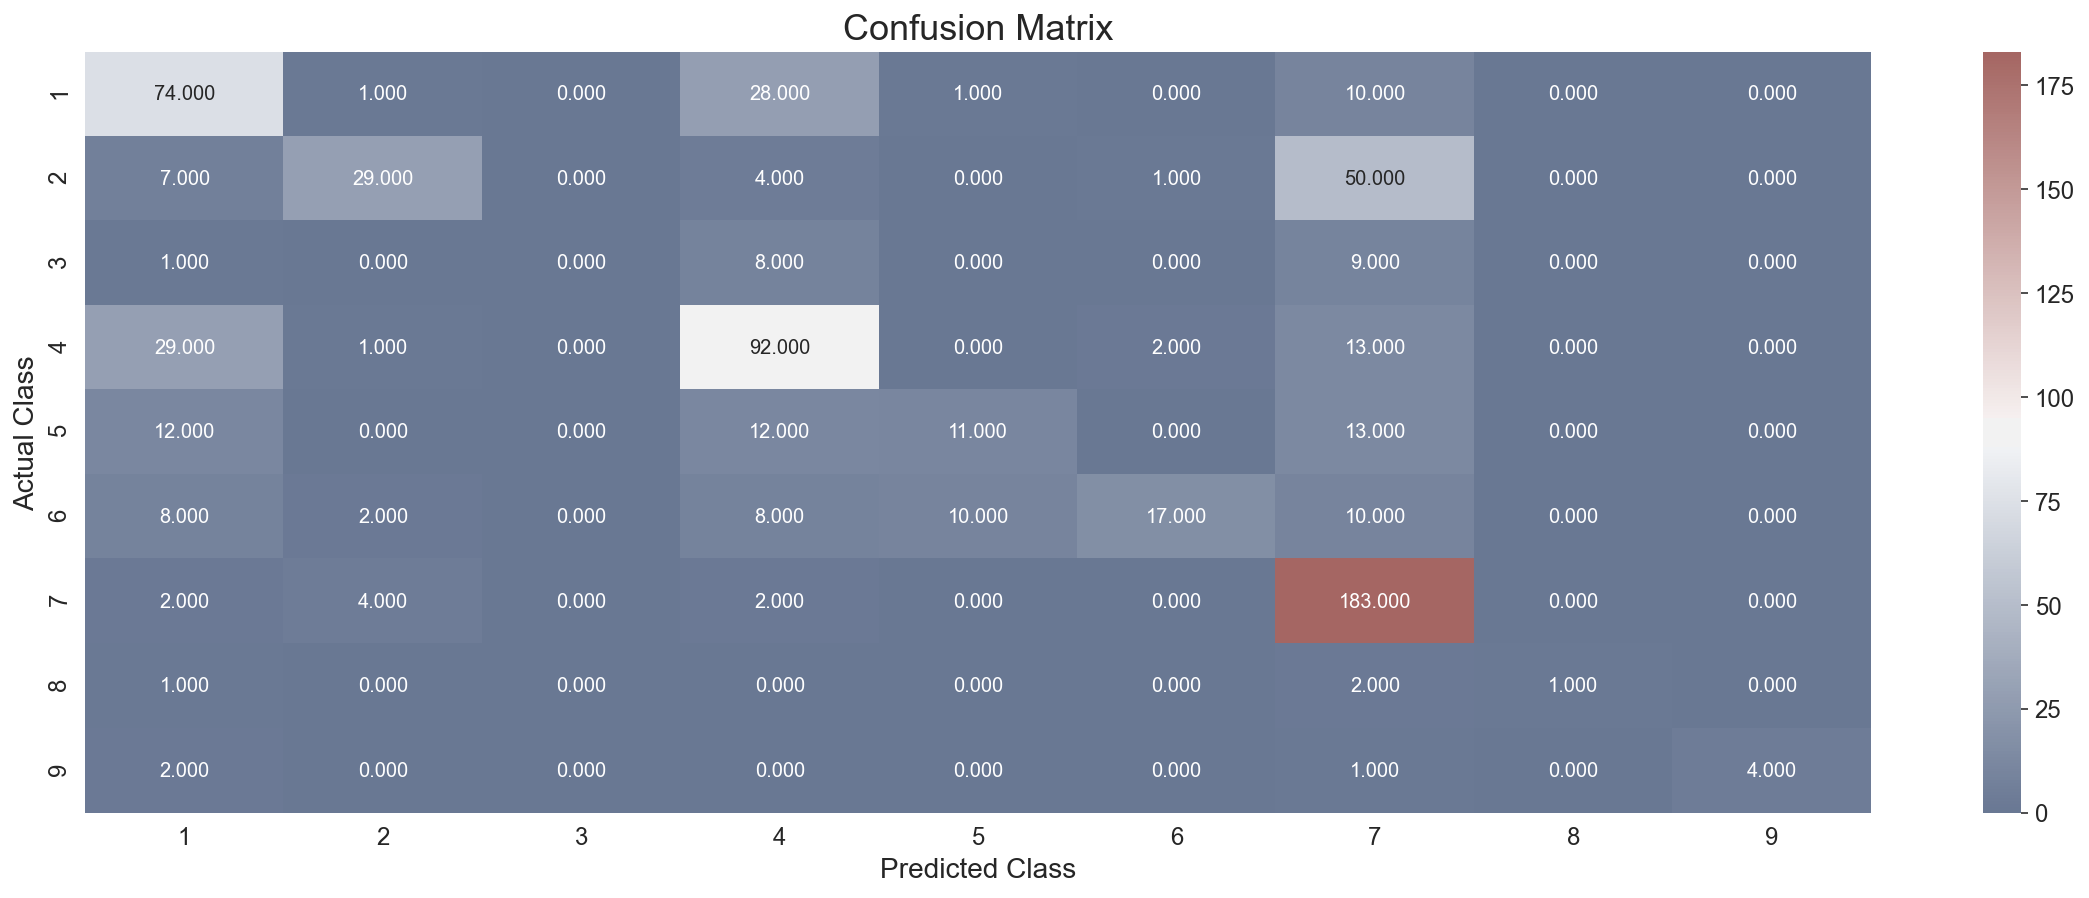

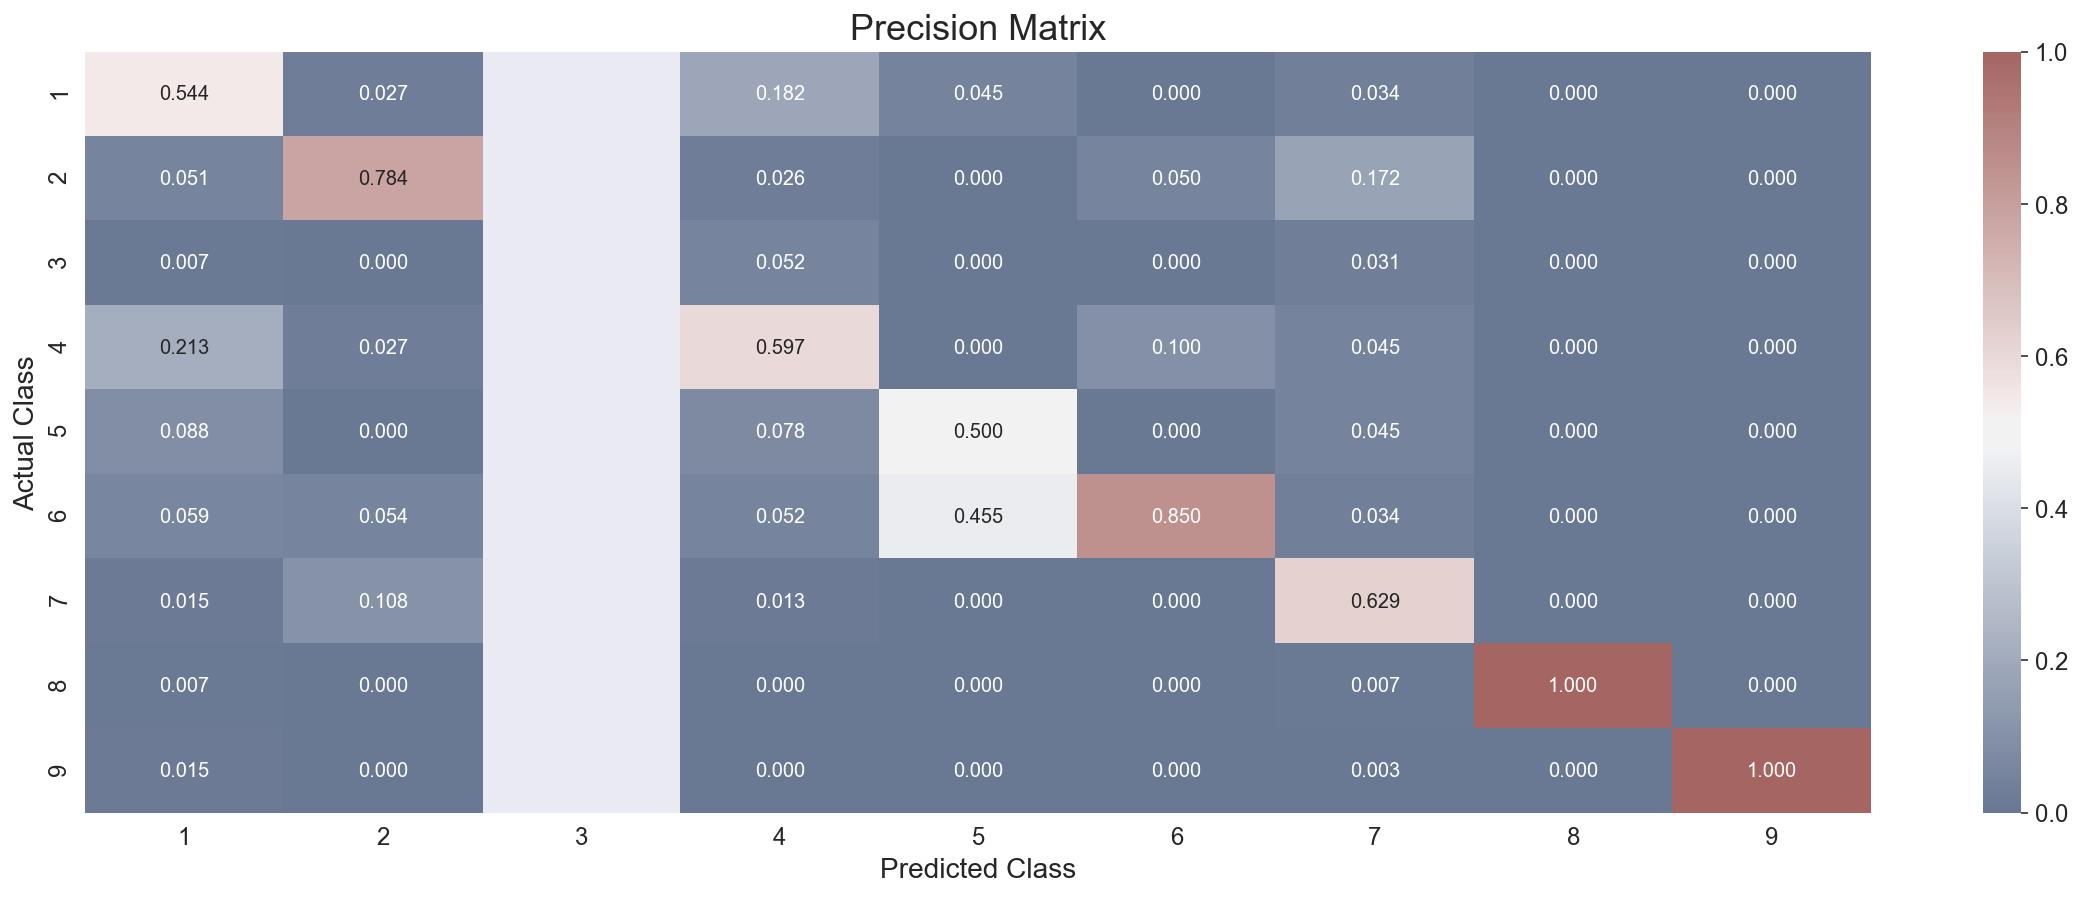

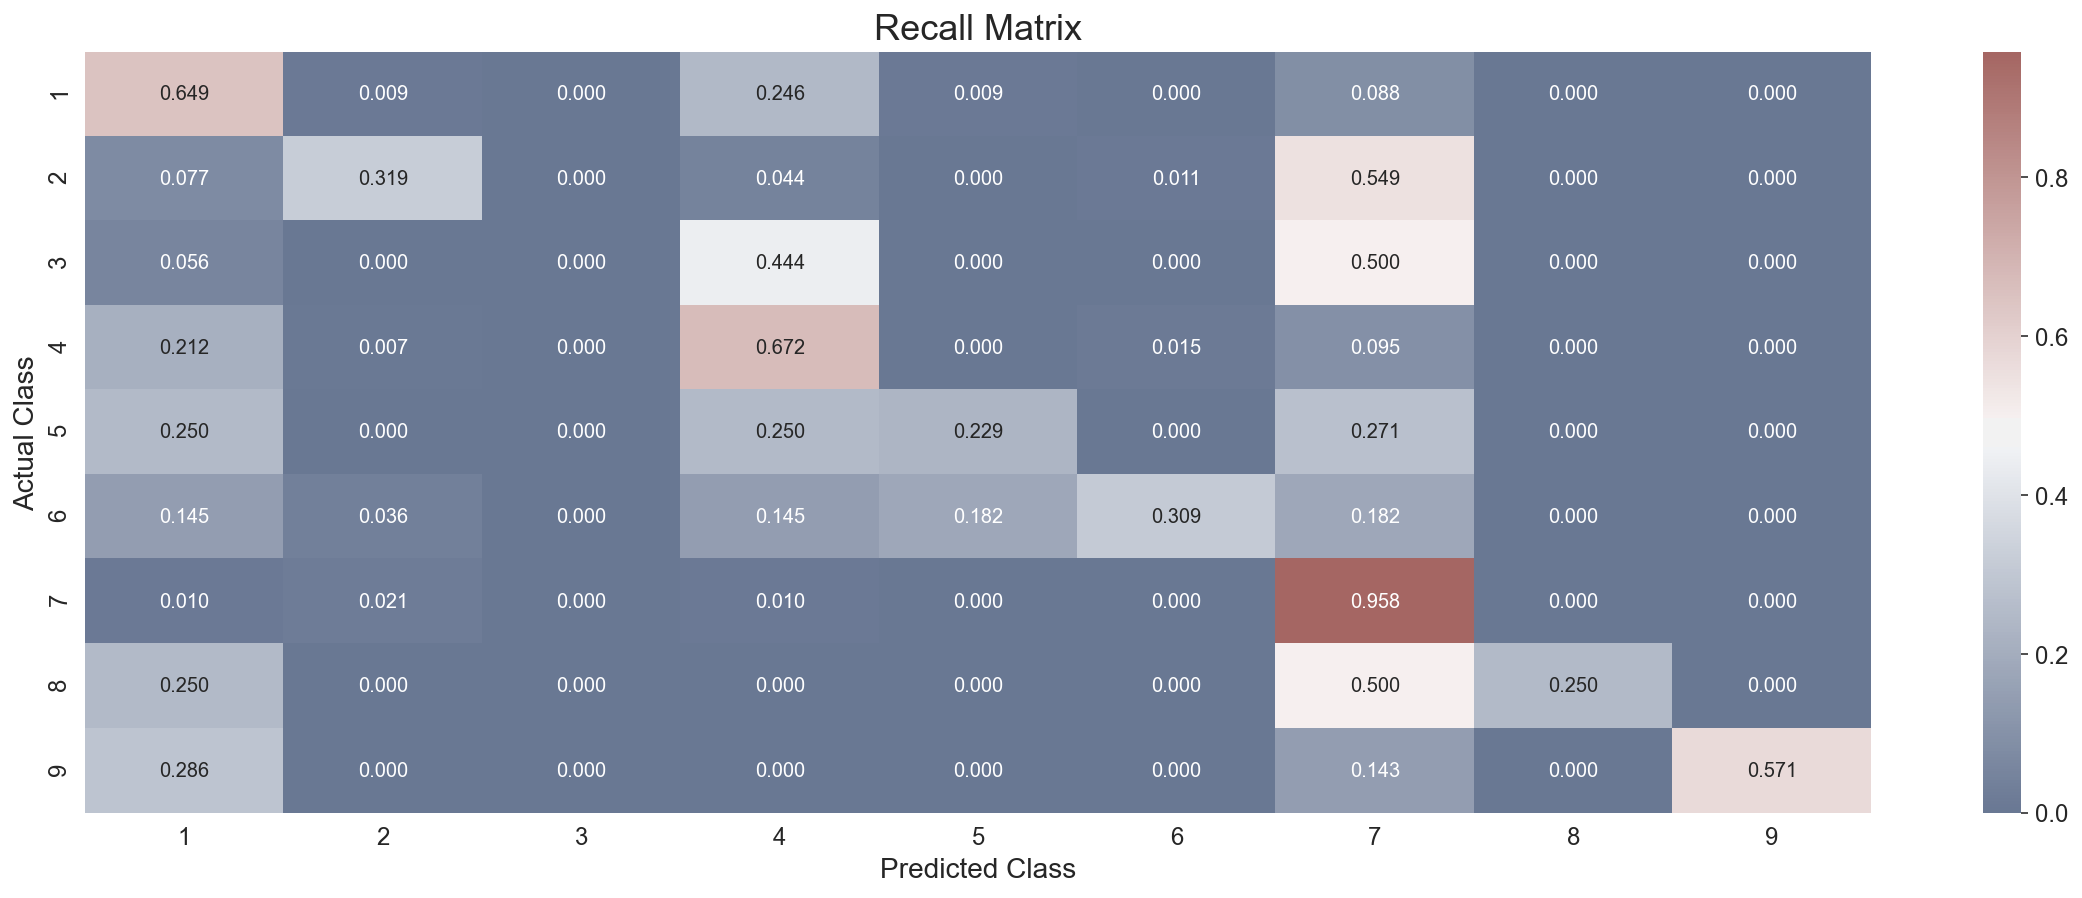

In [73]:
rf_clf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth= 10, n_estimators= 300)
rf_clf.fit(X_train_ohe_bow, y_train)
sig_rf_clf = CalibratedClassifierCV(rf_clf, method='sigmoid')
sig_rf_clf.fit(X_train_ohe_bow, y_train)
y_pred = best_clf_rf.predict_proba(X_train_ohe_bow)
print(f"[Train loss] ({log_loss(y_train, y_pred, eps=1e-15)})")
y_pred = best_clf_rf.predict_proba(X_cv_ohe_bow)
print(f"[CV loss] ({log_loss(y_cv, y_pred, eps=1e-15)})")
y_pred = best_clf_rf.predict_proba(X_test_ohe_bow)
print(f"[Test loss] ({log_loss(y_test, y_pred, eps=1e-15)})")
predict_and_plot_confusion_matrix(X_train_ohe_bow, X_test_ohe_bow, y_train, y_test, clf=rf_clf)

In [75]:
## correctly classified points
print("Correctly classified points...")
test_point_index = 2
clf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth= 10, n_estimators= 300)
clf.fit(X_train_ohe_bow, y_train)
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)
## incorrectly classified points
print("Inorrectly classified points...")
test_point_index = 101
predicted_cls = sig_clf.predict(X_test_ohe_bow[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(X_test_ohe_bow[test_point_index]),3))
print("Actual Class :", y_test[test_point_index])
print("="*80)

Correctly classified points...
Predicted Class : 7
Predicted Class Probabilities: [[0.08  0.108 0.017 0.074 0.043 0.038 0.631 0.005 0.004]]
Actual Class : 6
Inorrectly classified points...
Predicted Class : 1
Predicted Class Probabilities: [[0.328 0.155 0.023 0.185 0.071 0.058 0.157 0.013 0.011]]
Actual Class : 8


In [76]:
bow = PrettyTable()
bow.field_names = ["clf", "Encoding Method", "Test loss", "MisClassified %"]

bow.add_rows(
    [
        ["Random Forest", "One Hot Encoding", 1.17, str(0.38)+"%"],
    ]
)

print(bow.get_string(fields=["clf", "Encoding Method", "Test loss", "MisClassified %"]))

+---------------+------------------+-----------+-----------------+
|      clf      | Encoding Method  | Test loss | MisClassified % |
+---------------+------------------+-----------+-----------------+
| Random Forest | One Hot Encoding |    1.17   |      0.38%      |
+---------------+------------------+-----------+-----------------+


## Stacking

In [77]:
clf1 = MultinomialNB(alpha=0.1)
clf1.fit(X_train_ohe_bow, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method='sigmoid')
sig_clf1.fit(X_train_ohe_bow, y_train)
y_pred = sig_clf1.predict_proba(X_cv_ohe_bow)
loss = np.round(log_loss(y_cv, y_pred, labels=clf1.classes_, eps=1e-15), 3)
print(f"[Multi Naive Bayes] [CV Loss] ({loss})")

clf2 = SGDClassifier(alpha = 0.001, penalty='l2', loss='log', random_state=1)
clf2.fit(X_train_ohe_bow, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method='sigmoid')
sig_clf2.fit(X_train_ohe_bow, y_train)
y_pred = sig_clf2.predict_proba(X_cv_ohe_bow)
loss = np.round(log_loss(y_cv, y_pred, labels=clf2.classes_, eps=1e-15), 3)
print(f"[Logistic Regression] [CV Loss] ({loss})")

clf3 = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='hinge', random_state=1)
clf3.fit(X_train_ohe_bow, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method='sigmoid')
sig_clf3.fit(X_train_ohe_bow, y_train)
y_pred = sig_clf3.predict_proba(X_cv_ohe_bow)
loss = np.round(log_loss(y_cv, y_pred, labels=clf3.classes_, eps=1e-15), 3)
print(f"[Linear SVM] [CV Loss] ({loss})")

[Multi Naive Bayes] [CV Loss] (1.316)
[Logistic Regression] [CV Loss] (1.142)
[Linear SVM] [CV Loss] (1.155)


In [82]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(X_train_ohe_bow, y_train)
    loss = np.round(log_loss(y_cv, sclf.predict_proba(X_cv_ohe_bow)), 3)
    print(f"[Stacking classifier] [alpha {i}] [log_loss {loss}]")
    if best_alpha > loss:
        best_alpha = loss

[Stacking classifier] [alpha 0.0001] [log_loss 1.812]
[Stacking classifier] [alpha 0.001] [log_loss 1.679]
[Stacking classifier] [alpha 0.01] [log_loss 1.286]
[Stacking classifier] [alpha 0.1] [log_loss 1.28]
[Stacking classifier] [alpha 1] [log_loss 1.639]
[Stacking classifier] [alpha 10] [log_loss 2.049]
[Stacking classifier] [alpha 100] [log_loss 2.64]


In [86]:
## testing the model with best hyperparameter

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(X_train_ohe_bow, y_train)

train_log_error = np.round(log_loss(y_train, sclf.predict_proba(X_train_ohe_bow), eps=1e-15), 4)
cv_log_error = np.round(log_loss(y_cv, sclf.predict_proba(X_cv_ohe_bow), eps=1e-15), 4)
test_log_error = np.round(log_loss(y_test, sclf.predict_proba(X_test_ohe_bow), eps=1e-15), 4)

print(f"[Train log error] ({train_log_error})")
print(f"[CV log error] ({cv_log_error})")
print(f"[Test log error] ({test_log_error})")

[Train log error] (0.3604)
[CV log error] (1.2798)
[Test log error] (1.2464)


In [90]:
def predicts_and_plot_confusion_matrix(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"[Test Log loss] ({log_loss(y_test, clf.predict_proba(X_test))})")
    print(f"Number of missclassified points : {np.count_nonzero((y_pred - y_test))/y_test.shape[0]}")
    plot_confusion_matrix(y_test, y_pred)

[Test Log loss] (1.2464200801207166)
Number of missclassified points : 0.36541353383458647


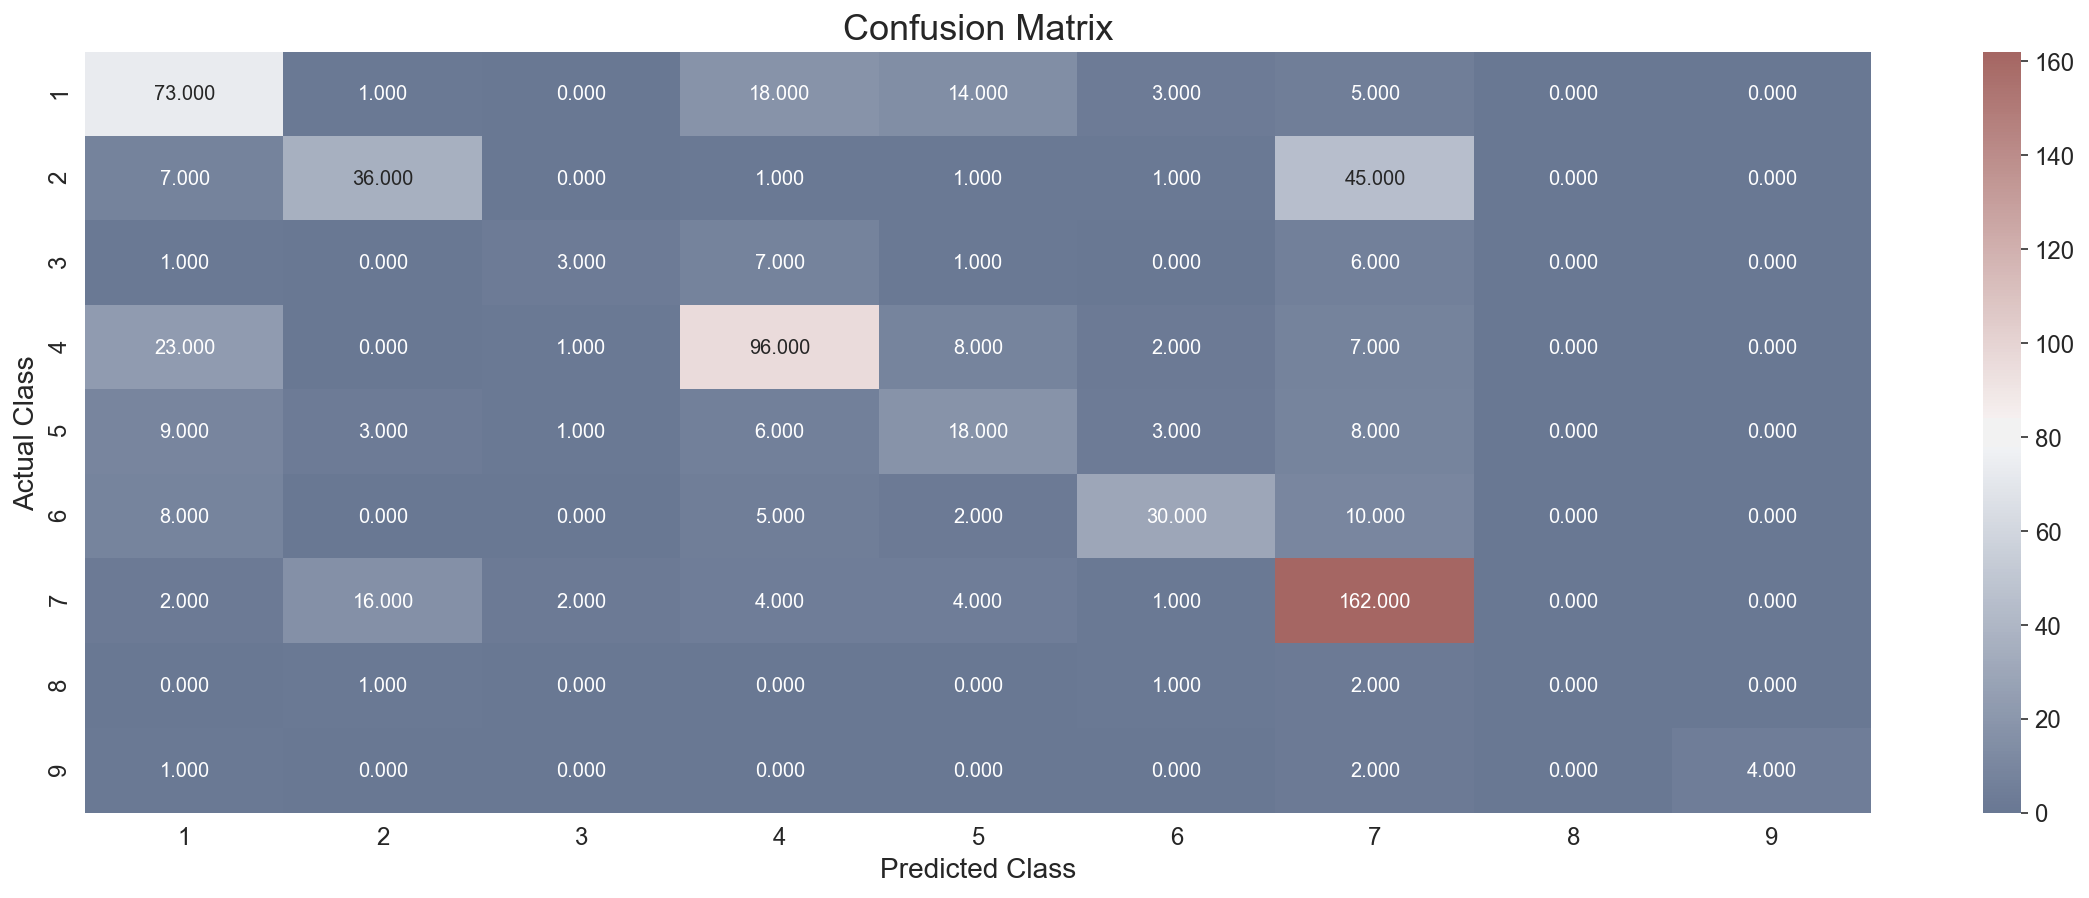

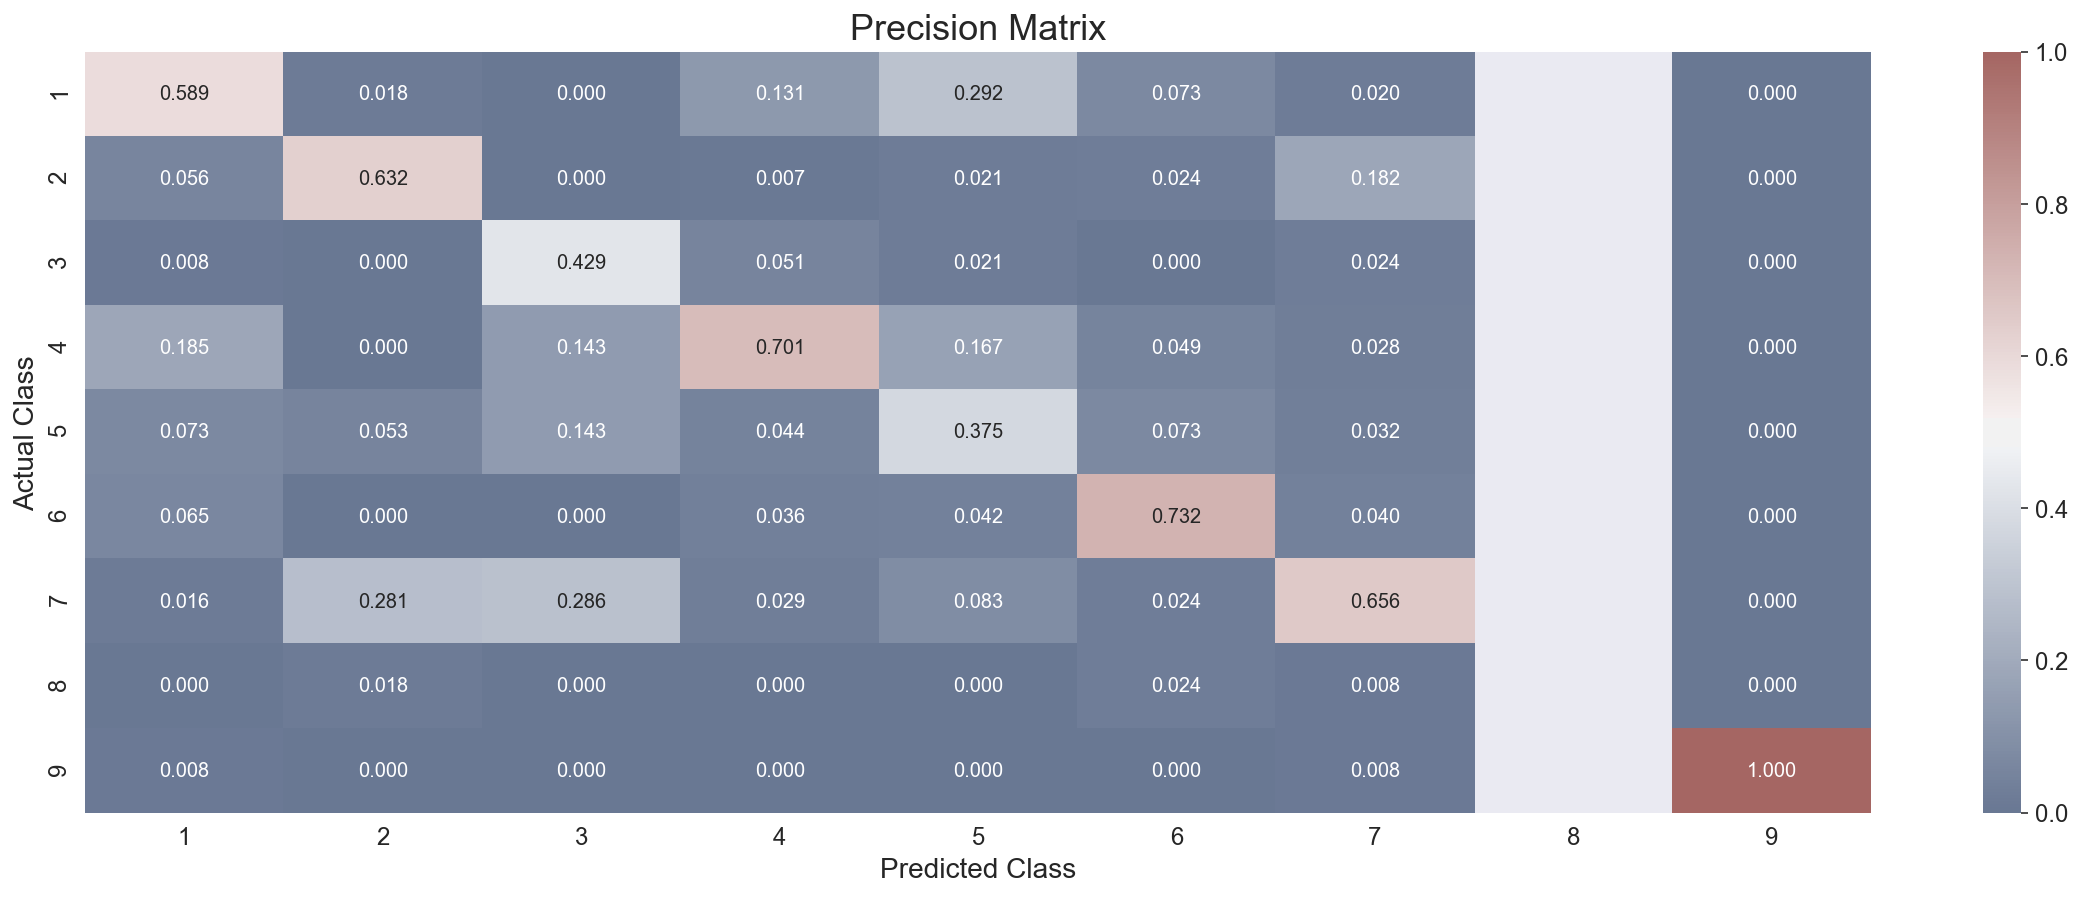

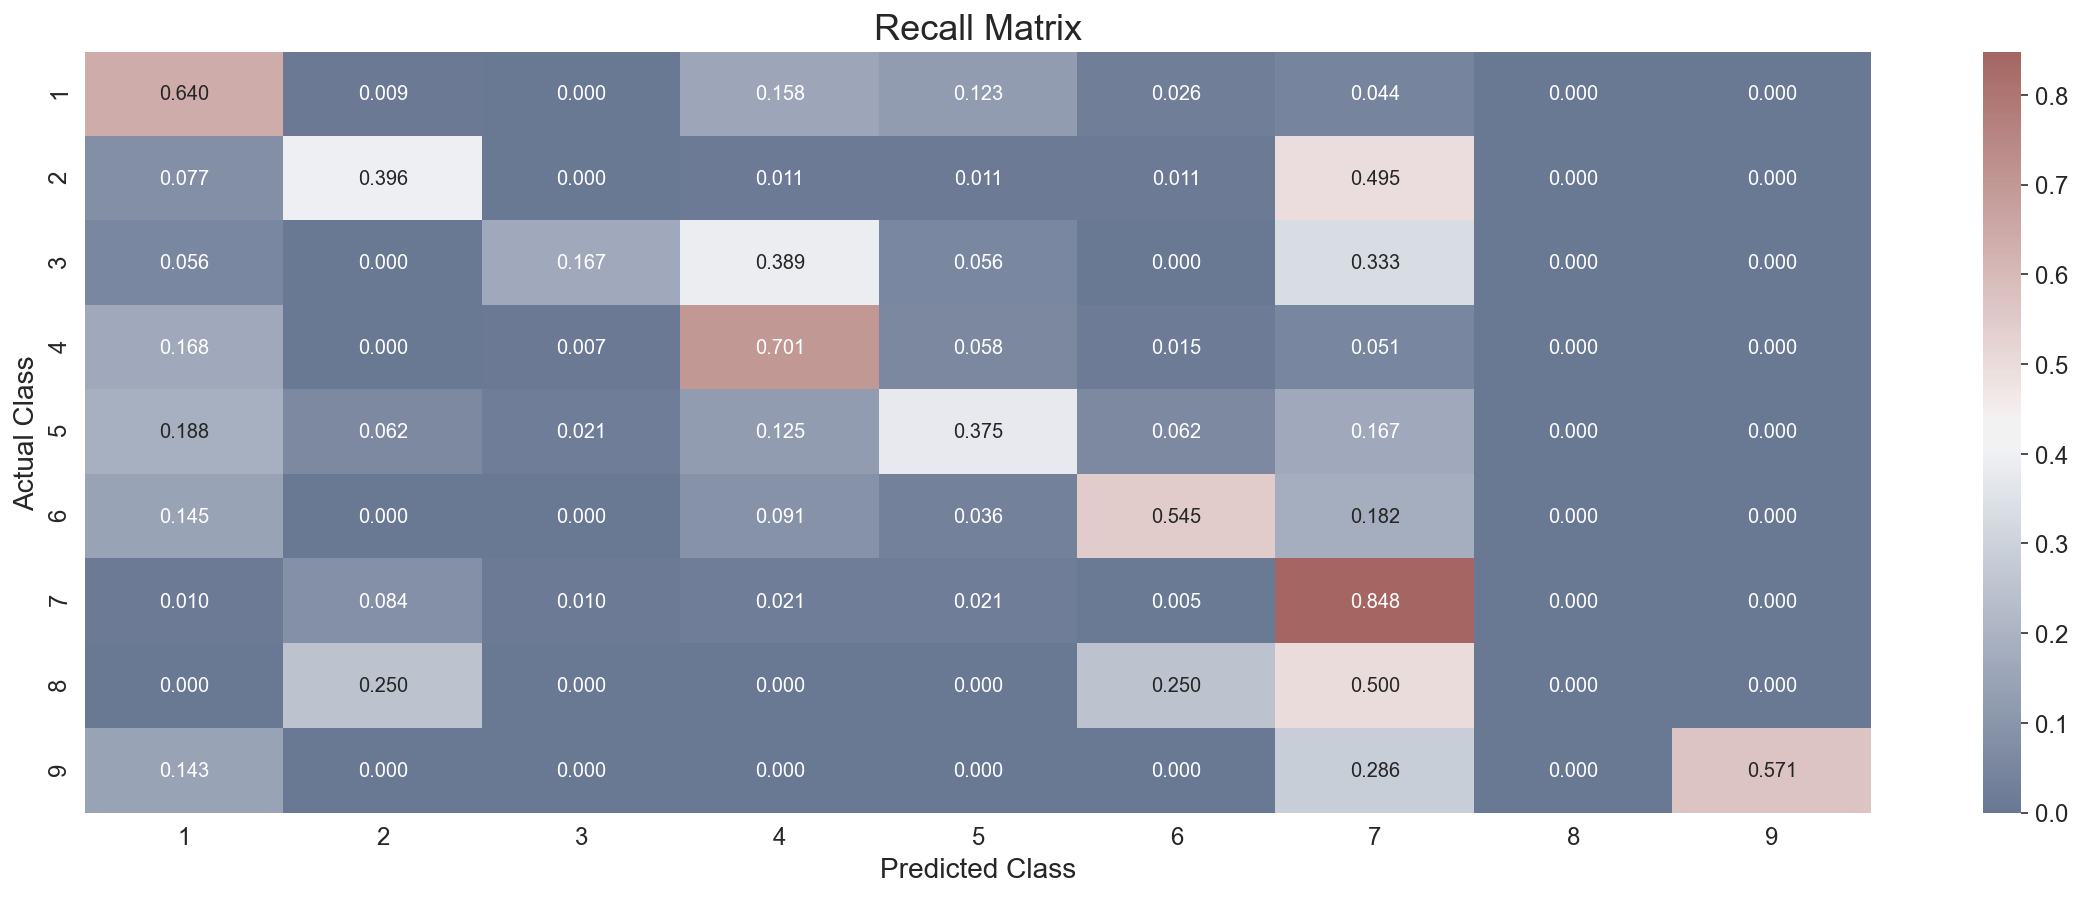

In [91]:
predicts_and_plot_confusion_matrix(X_train_ohe_bow, X_test_ohe_bow, y_train, y_test, clf=sclf)

In [92]:
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[('naive', sig_clf1), ('logistic', sig_clf2), ('svc', sig_clf3)], voting='soft')
vclf.fit(X_train_ohe_bow, y_train)

y_pred = vclf.predict_proba(X_train_ohe_bow) 
loss = np.round(log_loss(y_train, y_pred), 3)
print(f"[Soft Voting] [Train loss] ({loss})")

y_pred = vclf.predict_proba(X_cv_ohe_bow) 
loss = np.round(log_loss(y_cv, y_pred), 3)
print(f"[Soft Voting] [CV loss] ({loss})")

y_pred = vclf.predict_proba(X_test_ohe_bow) 
loss = np.round(log_loss(y_test, y_pred), 3)
print(f"[Soft Voting] [Test loss] ({loss})")

[Soft Voting] [Train loss] (0.599)
[Soft Voting] [CV loss] (1.121)
[Soft Voting] [Test loss] (1.119)


[Test Log loss] (1.1187388945790087)
Number of missclassified points : 0.36541353383458647


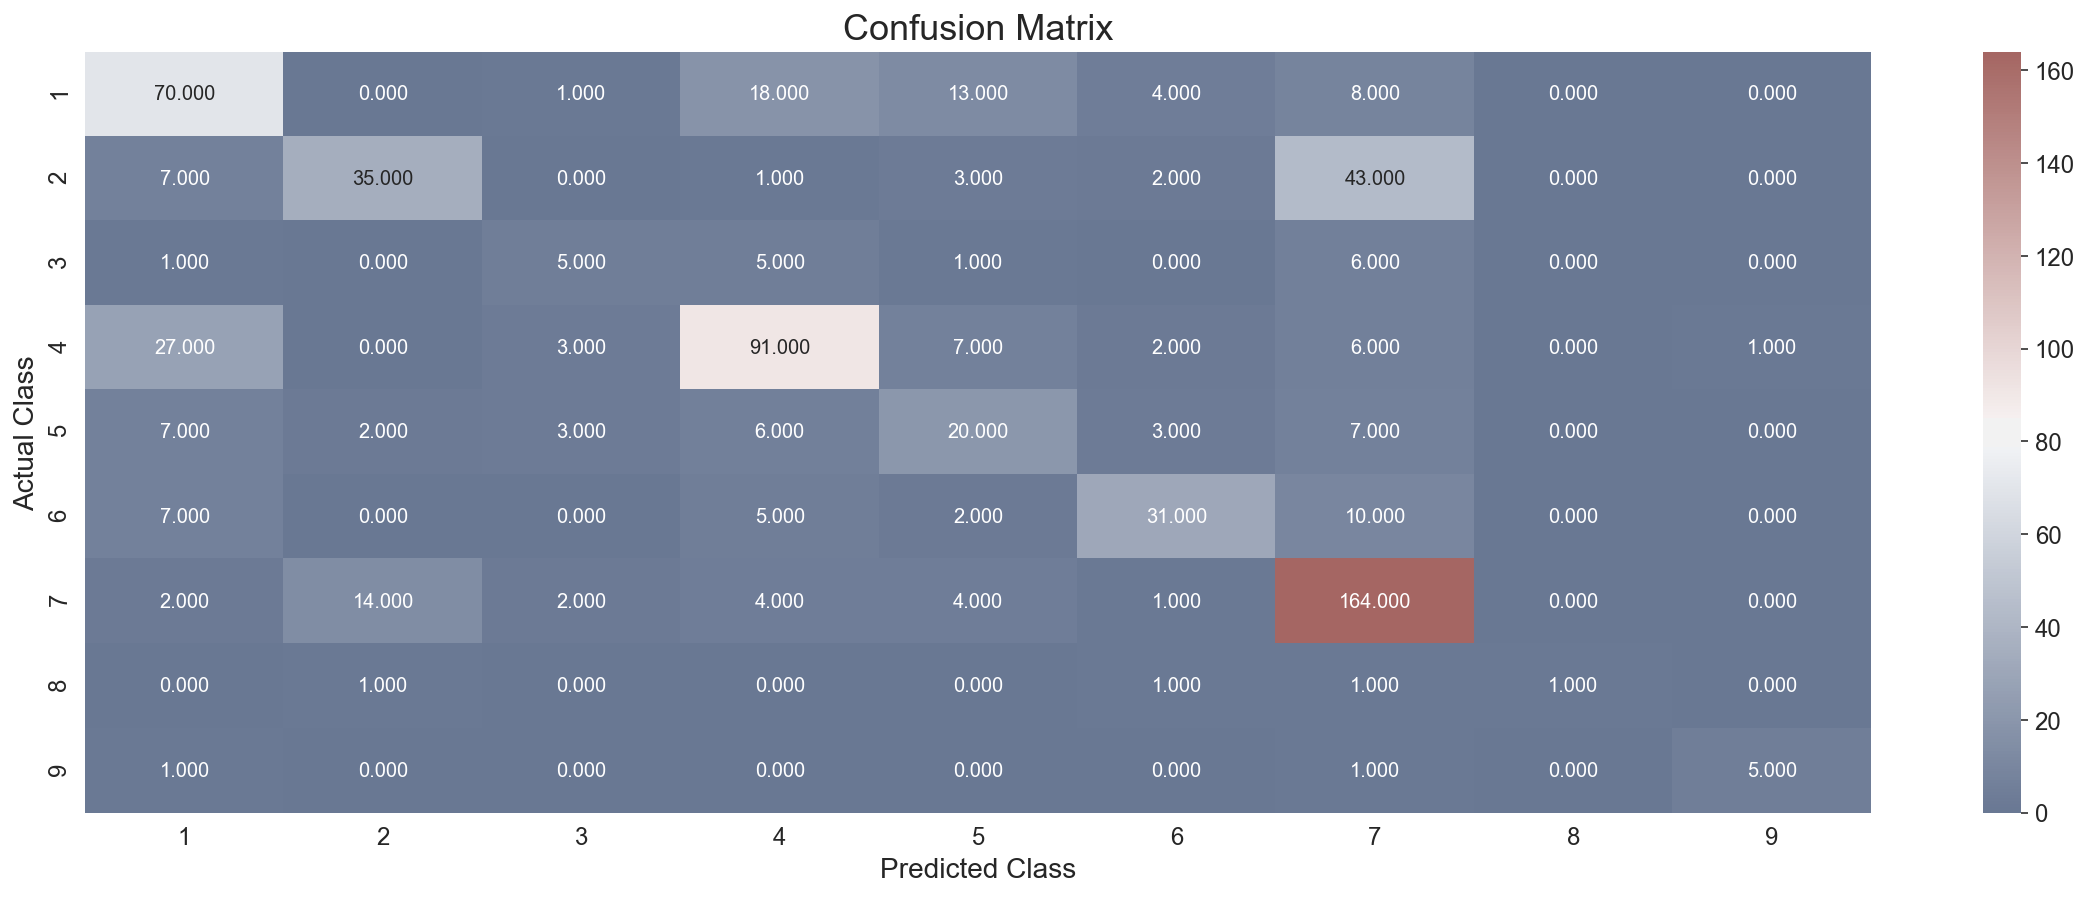

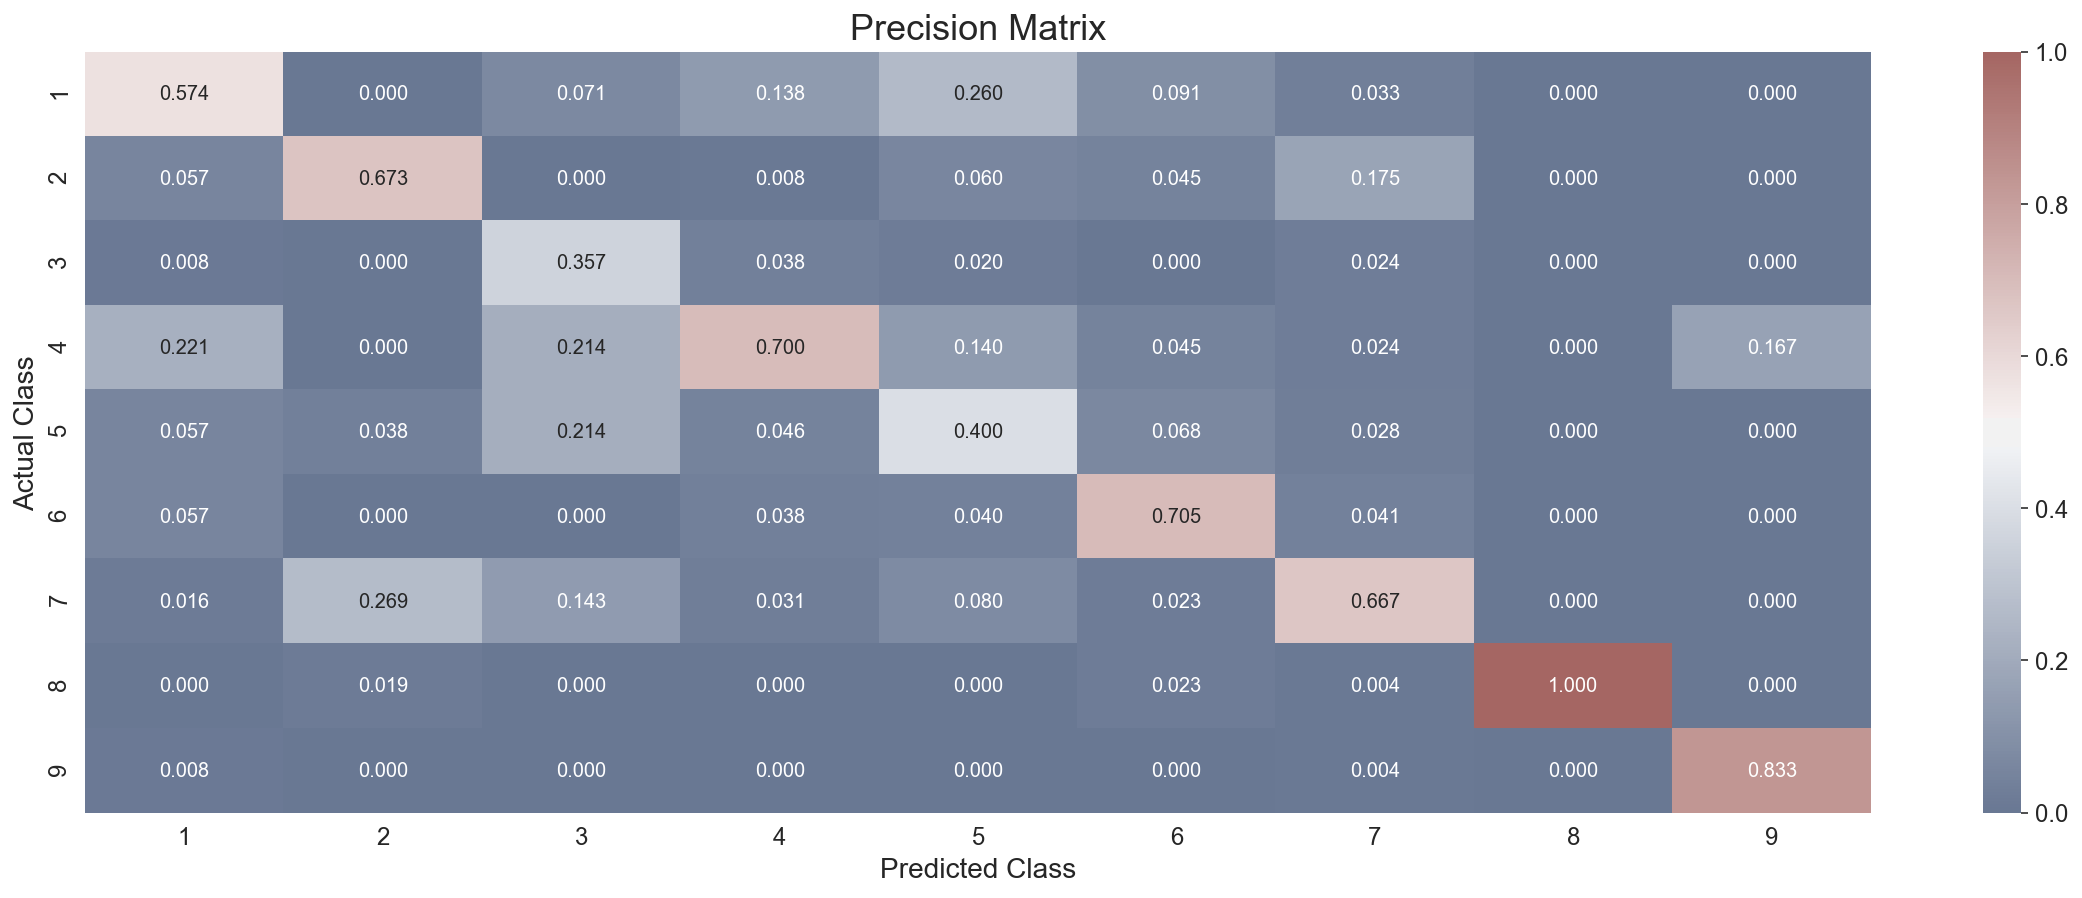

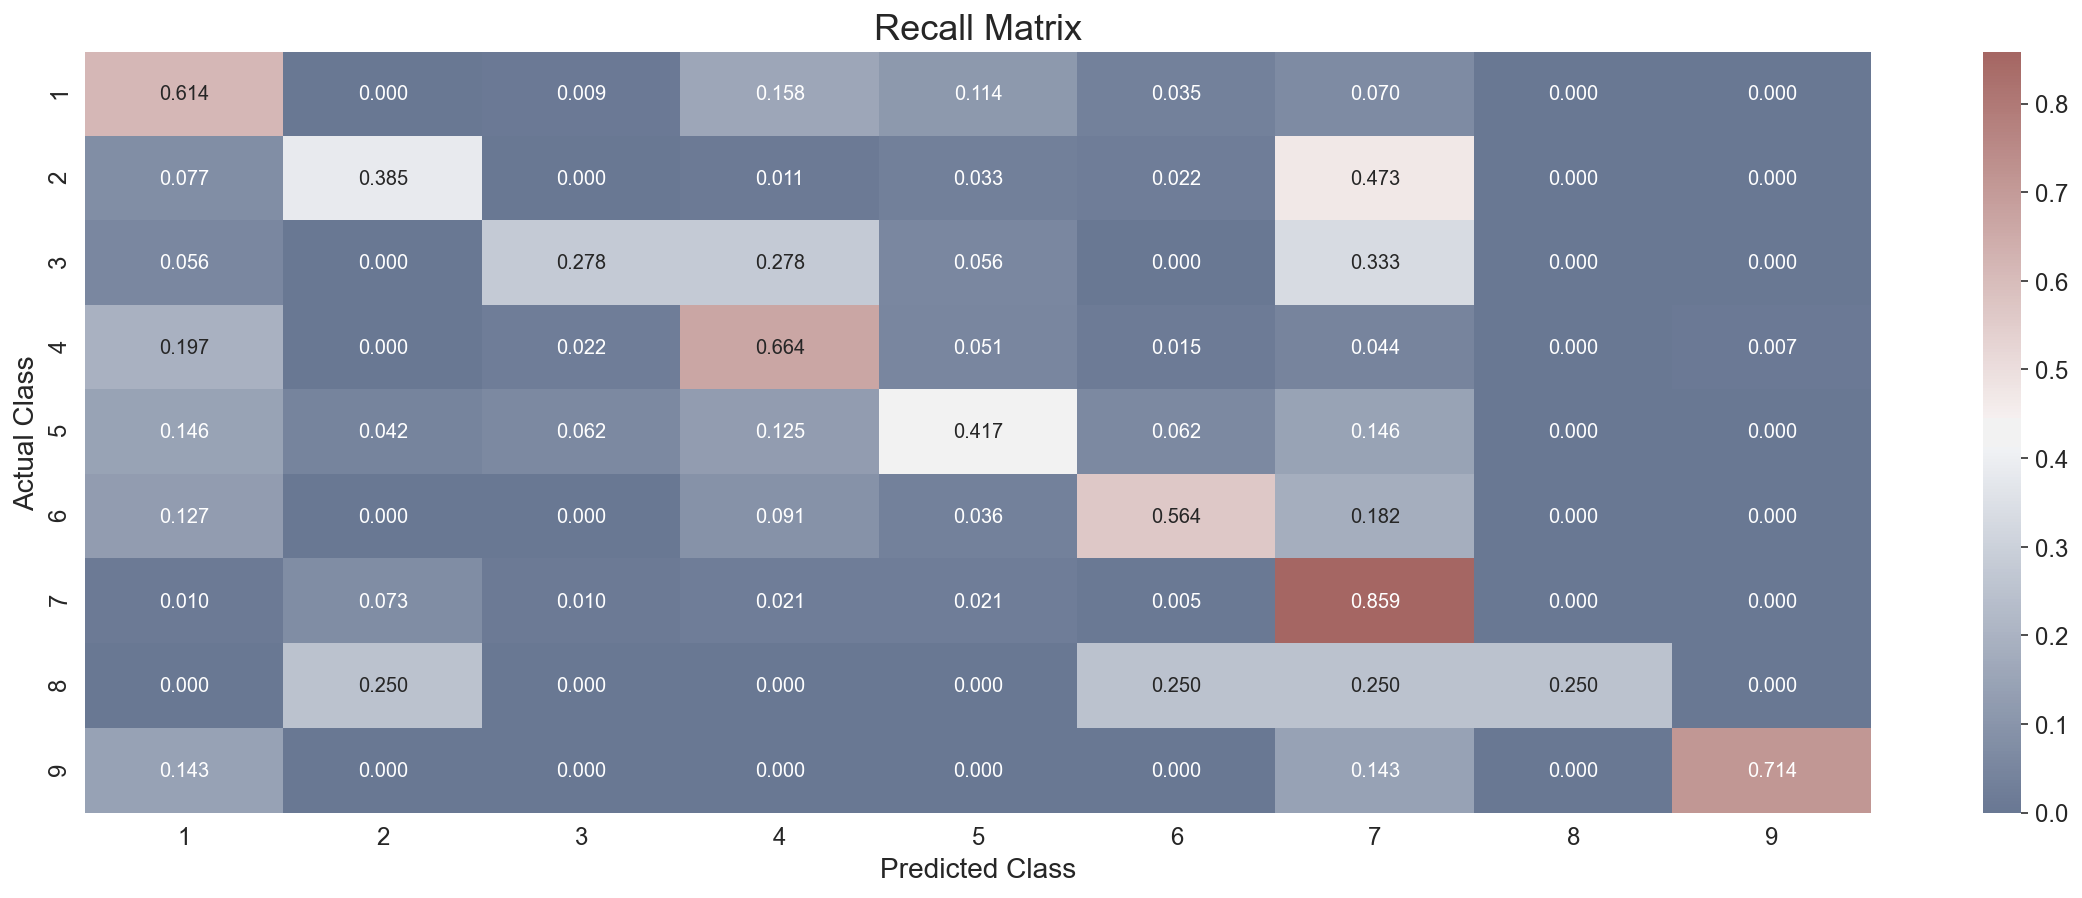

In [93]:
predicts_and_plot_confusion_matrix(X_train_ohe_bow, X_test_ohe_bow, y_train, y_test, clf=vclf)

In [101]:
bow = PrettyTable()
bow.field_names = ["clf", "Encoding Method", "Test loss", "MisClassified %"]

bow.add_rows(
    [
        ["Naive Bayes", "One Hot Encoding", 1.34, str(41)+"%"],
        ["Random Forest", "One Hot Encoding", 1.17, str(38)+"%"],
        ["Logistic Regression", "One Hot Encoding", 1.12, str(35)+"%"],
        ["Linear SVM", "One Hot Encoding", 1.12, str(36)+"%"],
        ["Stacking", "One Hot Encoding", 1.25, str(37)+"%"],
        ["Soft Voting", "One Hot Encoding", 1.11, str(36.54)+"%"],
    ]
)

print(bow.get_string(fields=["clf", "Encoding Method", "Test loss", "MisClassified %"]))

+---------------------+------------------+-----------+-----------------+
|         clf         | Encoding Method  | Test loss | MisClassified % |
+---------------------+------------------+-----------+-----------------+
|     Naive Bayes     | One Hot Encoding |    1.34   |       41%       |
|    Random Forest    | One Hot Encoding |    1.17   |       38%       |
| Logistic Regression | One Hot Encoding |    1.12   |       35%       |
|      Linear SVM     | One Hot Encoding |    1.12   |       36%       |
|       Stacking      | One Hot Encoding |    1.25   |       37%       |
|     Soft Voting     | One Hot Encoding |    1.11   |      36.54%     |
+---------------------+------------------+-----------+-----------------+


I Believe , Logistic regression beats rest of all the classifier's hence we'll be picking up logistic regression for our final model.


In [116]:
found_gene = ['RUNX1']
found_variation = ['K83N']
research_text = ['frequent mutations associated leukemia recurrent somatic chromosomal translocations inversions many involve polyomavirus enhancer binding protein core binding factor transcriptional regulation complex pebp2 cbf several translocations involve subunit complex runx1 gene also called aml1 cbf 2 pebp2 b chromosome 21q22 1 8 21 3 21 12 21 additionally subunit complex pebp2 also called cbf disrupted inv 16 p13 q22 1 abundance evidence points existence genes predispose hematologic malignancies however large multiple generation families hematologic malignancies alone rare 2 2 loci familial hematologic malignancies identified date 1 chromosome 21q22 13 16q22 4 5 loci contain runx1 andpebp2 cbf respectively studies families demonstrate single gene inheritance leukemia predisposition help identify genes mechanisms involved first steps leukemia development autosomal dominant familial platelet disorder fpd aml acute myelogenous leukemia online mendelian inheritance man 601399 good model validate hypothesis addition developing thrombocytopenia patients show propensity progression myelodysplasia acute myeloid leukemia 6 9 affected individuals within family may present variable clinical severity varying ages fpd aml linked 21q22 1 22 2 3 9 including region contains runx1 germline runx1 mutations subsequently identified 6 pedigrees 10heterozygous missense mutations biallelic nonsense frameshift mutations runx1 also identified sporadic leukemias 11 point mutations characterized patients m0 aml various myeloid malignancies 12 including acquired trisomy tetrasomy chromosome 21 13 missense mutations abolish dna binding transactivation activities runx1 affect heterodimerization pebp2 cbf addition mutant proteins inhibit wild type runx1 cotransfection studies 11 12the evolutionarily conserved 128 amino acid runt domain present runx1 isoforms involved dna binding heterodimerization pebp2 cbf 14 15heterodimerization runx1 pebp2 cbf promotes dna binding stabilizing interaction complex dna 16 17 runx1 point mutations described fpd aml patients10 runx1 point mutations patients sporadic leukemias11 13 within runt domain alter amino acids essential dna binding heterodimerization 18 19 longer runx1 proteins also contain transactivation domain domains involved self regulation protein protein interaction cellular localization 20 runx1 regulates activity several important hematopoietic genes macrophage colony stimulating factor csf receptor 21 cell receptor 22 granulocyte macrophage gm csf 23myeloperoxidase 24 neutrophil elastase 25by binding core sequence tgt cggt found promoters enhancers proposed haploinsufficiency runx1 responsible fpd aml 10 however hyperactivating inhibitory loss function runx1 point mutations reported sporadic leukemia 11 diversity mechanisms pathogenesis sporadic aml runx1 mutations suggested fpd aml runx1 mutations warranted functional studies describe 3 new runx1 mutations fpd aml potential mechanisms involved pathogenesis disease based vitro studies 7 runx1 fpd aml mutations materials methodssample collection genomic dna isolationour fpd aml pedigrees shown figure1 pedigree 1 extensively described 7 fourteen members family hemorrhagic diathesis characterized long bleeding time abnormal platelet aggregation decreased numbers platelet dense bodies among affected individuals 3 documented cases myeloblastic leukemia 2 documented cases myelomonoblastic leukemia 3 cases leukemia history fig 1 download figureopen new tabdownload powerpointfig 1 fpd aml pedigrees unique study 3 pedigrees show linkage fpd aml locus 21q22 1 22 2 half filled symbols represent individuals bleeding disorder studied platelet defect well completely filled symbols represent affected individuals developed leukemia pedigree 2 previously unreported 8 affected individuals 4 generations clinical history prolonged bleeding constitutional thrombocytopenia found 5 members 3 extensive platelet evaluations documenting aspirinlike aggregation defects dense granule abnormality demonstrable electron microscopic morphology quinacrine fluorescence three individuals developed aml fourth said died pernicious anemia pedigree 3 consists 15 affected individuals 4 generations family bleeding disorder characterized impaired platelet aggregation associated decreased numbers contents platelet dense granules26 27 well unique platelet phospholipid defect decreased 2 adrenergic receptors 28 29 platelet counts family slightly lower limit normal 26 27 two members family developed aml another reported died leukemia 29blood samples obtained healthy affected individuals obtaining informed consent accordance institutional guidelines human subjects dna isolated blood leukocytes using standard protocols linkage analysisgenotype information generated polymerase chain reaction pcr amplification chromosome 21 microsatellite markers genome database http www gdb org linkage analysis previously described 4 5 least 7 microsatellite repeat polymorphisms fpd aml critical region chromosome 21q22 1 3 genotyped family mutation analysesall 9 exons runx1 amplified genomic dna using primers designed flanking region exon single strand conformational polymorphism analysis performed pcr fragments less 400 base pairs using genephor apparatus genegel 12 5 kit amersham pharmacia biotech freiburg germany exons showing conformational changes directly sequenced directions using bigdye terminator cycle sequencing applied biosystems foster city ca analyzed abi377 sequencer rt pcrfirst strand complementary dna cdna synthesized patient individuals iv 2 v 2 pedigree 2 control rna using superscript ii reverse transcriptase pcr performed using primers aml1rtf3 figure 2d primer c 5 ctgctccgtgctgcctacgcactg 3 exon 3 aml1b amlrtr1 5 cgcagctgctccagttcactgagc 3 exon 6 reverse primer double stranded cdnas cloned ta vector sequenced cryptic splice site observed one clone primers covering cryptic splice junction exon 4 5 f2amlmf4 figure 2d primer 5 taatgacctcagggaaaagcttc 3 within nucleotides exon 4 excluded mutant transcript f2amlf1 figure 2d primer b 5 tgtcggtcgaagtggaagagg 3 designed used aml1rtr1 amplify pcr product patients cdna mutant transcript observed control cdna fig 2 download figureopen new tabdownload powerpointfig 2 mutation analysis fpd aml pedigrees electropherograms affected control individuals showing g substitution leading k83e missense mutation pedigree 1 c substitution resulting nonsense mutation y260x pedigree 3 b deletion 3 position splice donor site intron 4 pedigree 2 ivs4 3dela c arrows indicate point mutations schematic representation cryptic splice site within exon 4 used mutated transcript pedigree 2 rt pcrs used analyze splicing b c represent forward primers used rt pcr experiment primer specific mutated form primer b specific wild type form primer c used control reverse primer used reaction 23 nucleotides exon 4 excluded mutant transcript indicated black box e rt pcr patient control rna described panel primer specific mutated form show amplification control rna f sequence analysis mutant exon 4 exon 5 junction electrophoretic mobility shift assayamino acids 24 189 runx1 including runt domain expressed escherichia coli purified subjected electrophoretic mobility shift assay emsa essentially described previously 11 wild type expression plasmid previously described 11 mutant runx1 plasmids obtained site directed mutagenesis wild type pqe9 runx1 using strategene quick change method according manufacturer instruction manual stratagene amsterdam netherlands k90fsx101 alternative vector pqe13 used instead express fusion bulky n terminal appendage containing hexahistidines dihydrofolate reductase mutant constructs confirmed sequencing affinity assay runx1 pebp2 cbf associationthe heterodimerization activity runx1 mutants impaired dna binding assayed magextractor kit toyobo osaka japan briefly hexahistidine tagged runx1 fragment 1 g incubated tagless pebp2 cbf 1 g mixed nickel coated magnetic beads mixture successively washed buffers containing 30 mm imidazole eluted buffer supplied manufacturer proteins fraction analyzed previously described 11subcellular localizationfor functional studies mutated runx1 proteins wild type runx1 sequence 1 453 inserted pef bos mammalian expression plasmid construction runx1 mutants carried using megaprimers method 30 resultant plasmids transfected nih3t3 ref52 h58n k83n r177q r177x cells using nonliposomal transfection reagent fugene6 boehringer mannheim germany immunofluorescence labeling runx1 pebp2 cbf microscopy previously described 11 transfection 50 cells visualized transactivation assaysthe luciferase reporter plasmid pm csf r luc effector plasmid pef aml1 containing 453 amino acid isoform runx1 mutations studied transfected fixed ratio 0 5 0 8 g per assay respectively u937 hl60 jurkat cells cell extracts prepared 48 hours transfection assayed essentially described 11 study inhibitory effect mutant runx1 proteins wild type runx1 reporter gene activation 0 5 g pm csf r luc 0 1 0 8 g pef constructs expressing either runx1 without mutations pebp2 myh11 cotransfected u937 hl60 jurkat cells total amount dna transfected kept constant 1 3 g supplementing appropriate amounts backbone pef plasmid thereby avoiding potential artifacts due unbalanced dna dosages partial rescue repression obtained transfecting varying doses pebp2 cbf repressive dose wild type mutant proteins resultslinkage mutation analyses 3 new pedigreeseach 3 families demonstrated features typical fpd aml candidate region genetic linkage analysis provided maximum 2 point log odds ratio scores 3 14 2 15 2 43 0 markers d21s1413 pedigree 1 ifnar pedigree 2 d21s65 pedigree 3 extended haplotype analysis family indicated approximate 3 megabase common nonrecombinant interval human chromosome 21q22 1 containing runx1 affected individuals pedigree 1 showed g substitution exon 3 resulting missense mutation k83e figure 2a mutation segregates disorder family absent 188 unrelated control chromosomes pedigree 2 showed one base deletion splice donor site intron 4 ivs4 3dela figure 2c mutation segregates disorder family absent 184 unrelated control chromosomes reverse transcriptase rt pcr rna affected individuals showed use cryptic donor splice site used control rna 23 nucleotides upstream normal splice site figure 2d f novel transcript generated use cryptic splice site results frameshift amino acid 135 addition 41 unrelated residues termination codon 177 r135fsx177 pedigree 3 showed c substitution exon 7b resulting nonsense mutation y260x figure 2b mutation segregated disease family members tested effects runx1 fpd aml mutations dna binding heterodimerization activities runt domainwe examined function runt domain 2 new k83e r135fsx177 swiss prot q01196 5 described r139q r174q k90fsx101 r174x r177x 10 fpd aml point mutations emsa analyses r139q r174x r177x alone showed barely detectable dna binding produced supershift band increased intensity presence pebp2 cbf indicating heterodimerization mutants pebp2 cbf still occurs figure3a k83e r135fsx177 r174q k90fsx101 showed detectable dna binding presence absence pebp cbf affinity assay mutants heterodimerization pebp2 cbf revealed missense mutants retained ability heterodimerize whereas frameshift mutants figure 3b fig 3 download figureopen new tabdownload powerpointfig 3 alterations dna binding heterodimerization activities runt domain fpd aml runx1 mutations partial runx1 proteins indicated subjected emsa presence absence pebp2 cbf wt indicates wild type runx1 position runx1 runx1 cbf complexes dna indicated b affinity assay indicated partial runx1 proteins pebp2 cbf indicates molecular weight marker indicated left right pebp2 cbf input runx1 protein w unbound proteins washed fractions e bound proteins eluted 250 mm imidazole bands marked arrows indicate subunits associated runx1 proteins subcellular localization fpd aml runx1 mutants colocalization pebp2 cbf runx1 nuclear localization signal nls present amino acids 167 183 end runt domain runx1 wild type protein localized nucleus diffuse pattern excluded nucleoli figure 4a transfection mutant full length cdnas nih3t3 cells immunostaining expressed runx1 proteins revealed frameshift r135fsx177 k90fsx101 nls nonsense r174x r177x half nls missing mutants localized almost exclusively cytoplasm consistent importance basic amino acids nls r174q r177q sporadic mutation described osato et al11 showed cytoplasmic localization 20 5 observed cells respectively figure 4a fig 4 download figureopen new tabdownload powerpointfig 4 subcellular localization mutant runx1 proteins colocalization pebp2 cbf subcellular localization indicated runx1 proteins detected immunofluorescence staining anti b1 schematic runx1 protein shown runt transactivation domains indicated sequence nls indicated b double staining mutant runx1 pebp2 cbf reveals subunits colocalized cytoplasm within speckled dotlike structures missense mutants diffuse staining pattern frameshift nonsense mutations examples figure nih3t3 cells original magnification 400 k83e r139q mutations within known nls mutant proteins showed reduced nuclear localization k83e showed cytoplasmic localization 30 transfected cells contrast normal nuclear localization seen k83n sporadic mutation figure 4a 11 observation may suggest k83e mutation k positive hydrophilic c6 e negative hydrophilic c5 results greater loss function k83n mutation n polar hydrophobic c4 r139q mutation site involved dna binding18 expected affect dna binding rather nuclear localization however cytoplasmic localization observed 40 cells observed defect nuclear localization k83e r139q consistent earlier studies31 may point existence additional unidentified n terminal domain critical nuclear localization contrast runx1 pebp2 cbf normally localized cytoplasm heterodimerization32 enter nucleus runx1 31 however regulation heterodimerization remains unknown shown proteins may different cellular localizations transfected cells 31 missense mutants showed speckled dotlike distribution cytoplasm markedly different diffuse pattern truncated nonsense mutants double staining subunits revealed colocalized within speckled patterns figure 4b transactivation abilities fpd aml runx1 mutantsthe transactivation potential mutant runx1 proteins measured using reporter construct based csf receptor promoter myeloid specific runx1 target 33 34wild type runx1 demonstrated 100 fold transactivation compared fpd aml mutants showed significant transactivation without pebp2 cbf figure5a despite retention dna binding activity c terminal activation domains r139q failed transactivate several mutants showed persistently lower luciferase activities mock transfected plasmid indicating mutants could hinder function endogenous runx1 u937 cells allow measurement inhibition wild type transactivational activities caused mutant proteins reporter construct fixed amount nonsaturating wild type runx1 plasmid cotransfected varying amounts fpd aml mutant plasmids encoding mutant proteins dna pebp2 cbf binding activity pebp2 cbf myh11 k83n repressed csf receptor promoter previously reported 11 35 exception r177x mutants showed varying degrees interference wild type protein function cell lines tested u937 hl60 jurkat notably k83e r174q showed potent inhibition similar pebp2 cbf myh11 figure 5b results cotransfection reporter assays using frameshift mutants reproducible within cell lines fig 5 download figureopen new tabdownload powerpointfig 5 transactivation csf receptor promoter exogenously expressed runx1 proteins cells transfected luciferase reporter plasmid indicated runx1 expression constructs luciferase activities measured presented fold increase relative control transfected backbone expression vector b wild type runx1 missense runx1 mutants coexpressed varying doses indicated luciferase activities expressed fold changes relative activity observed standard dose 0 3 g wild type runx1 alone c pebp2 cbf transfected varying doses repressive dose wild type mutant runx1 proteins panels c value represents mean 3 separate experiments luciferase activity axis panel c shown relative luciferase units rlu deviations measurements given thin vertical bars chimeric protein pebp2 cbf myh11 sporadic mutation k83n used controls experiment examples figure u937 cells inhibitory mutants maintained ability heterodimerize colocalized pebp2 cbf sequestration pebp2 cbf mutant runx1 proteins may major inhibitory mechanism test hypothesis pebp2 cbf cotransfected increasing amounts together inhibitory amounts mutant runx1 resulting restoration near normal reporter gene activity figure 5c discussionfive runx1 point mutations deletion entire runx1 gene previously described fpd aml report 3 new runx1 point mutations associated disease y260x pedigree 3 beginning transactivating domain removes part negative regulatory region dna binding 20 31 first described familial runx1 mutation outside runt domain studies described paper appropriate test functional implications mutation functional analyses 7 mutants 2 frameshift 2 nonsense 3 missense mutations performed investigate mechanisms contribute fpd aml particularly propensity develop aml capacity bind dna reduced abolished mutant proteins expected sites substitutions runt domain missense nonsense mutant proteins largely intact runt domain retained capacity heterodimerize pebp2 cbf frameshift mutant proteins lack substantial part runt domain failed heterodimerize reported sporadic runx1 aml nonsense mutation s114x 11 observations consistent known crystal structure predicted binding domain mouse runx1 positions 3 missense mutations critical structural integrity dimerization site whereas frameshift mutant proteins predicted fold abnormally lack runt domain residues required heterodimerization 18do mechanisms pathogenesis sporadic leukemias provide clues mechanisms pathogenesis fpd aml many sporadic hematologic malignancies chromosomal rearrangements consistently appear supporting hypothesis events prerequisite tumor induction somatic mutations acquired leukemia translocations inversions heterozygous affected cells normal copies translocated genes still present consequently mechanism disease pathogenesis may include 1 gain function chimeric fusion proteins 2 haploinsufficiency 3 dominant negative effect chimeric fusion proteins 4 combination mechanisms however unlikely mutations described gain function activity haploinsufficiency runx proteinsthe importance gene dosage normal function cbf transcriptional regulators seen autosomal dominant human bone disorder cleidocranial dysplasia caused mutations inrunx2 also called cbf 1 36 37runx2 mice show skeletal defects similar cleidocranial dysplasia 38 runx2 mutations may heterozygous missense mutations insertions deletions either runt dna binding domain c terminal domains responsible transactivation 39 runx2 point mutations predicted affect folding stability runx2 18 resulting haploinsufficiency runx2 defects bone formation 36 40 43complete deletion runx1 results haploinsufficiency fpd aml 10 2 fpd aml splice site mutations resulting frameshifts r135fsx177 k90fsx101 cause loss dna binding heterodimerization nuclear localization transactivation functions also likely act simple haploinsufficiency dominant negative effects mutant runx proteins translocations involving runx1 produce chimeric proteins notably runx1 aml1 eto mtg8 aml 8 21 tel runx1 aml1 12 21 chimeric proteins retain entire runt domain shown interfere transactivation normal runx1 dominant negative manner 44 46 runx1 aml1 eto related fusion proteins shown form complexes pebp2 cbf nuclear proteins efficiently wild type runx1 47 49 moreover naturally occurring isoforms runx1 proteins contain runt domain also suppress transactivation full length runx1 50 deletion negative regulatory domain heterodimerization c terminal region full length runx1 amino acids 372 451 results efficient heterodimer formation 31 thus chimeric runx1 proteins resulting translocations isoforms runx1 without transactivation domain50 may act manner dimerizing pebp2 cbf efficiently wild type cotransfection equal amounts wild type mutant plasmids closely mimics vivo situation one normal one mutant allele fpd aml runx1 missense nonsense mutants studied except r177x show decrease transactivation capacities inhibitory effect wild type runx1 upon cotransfection thus also seem act dominant negative inhibitors missense nonsense mutants still interact pebp2 cbf nonsense mutants studied lack negative regulatory domain heterodimerization r139q 2 nonsense mutant proteins maintain degree dna binding although dna binding nonsense mutations may irrelevant vivo due cytoplasmic localization resulting direct disruption nls missense mutants appropriately translocated nucleus time also show cytoplasmic staining inhibitory nature mutants likely due competition wild type dimerization pebp2 cbf sequestration case r174x must occur cytoplasm whereas missense mutations may occur nucleus cytoplasm r177x differs r174x 3 amino acids show significant repression wild type runx1 cotransfection assay may considered haploinsufficient structural analysis c terminal end runt domain nuclear magnetic resonance suggested region conformational flexibility 51 r174x lacks 3 amino acids region might show decreased flexibility increased affinity pebp2 cbf r177x alternatively lack inhibition r177x could due technical difficulties inherent assay seen inconclusive results observed frameshift mutations one notable features fpd aml runx1 missense mutants studied colocalization runx1 pebp2 cbf cytoplasmic speckles sequestration pebp2 cbf could occur correlation colocalization pebp2 cbf interaction vitro level inhibitory effect pattern seen nonsense frameshift mutants prematurely terminated within runt domain presence c terminal region must required aggregation runx1 speckled cytoplasmic patterns raises possibility speckled structures could result c terminal associating molecules could also sequestered cytoplasm recently shown dimerization pebp2 cbf protects runx1 ubiquitin proteasome mediated degradation substitution k83 r shown increase half life runx1 lysine residues ubiquitylated 52 preferential binding mutant runx1 proteins pebp2 cbf may increase half lives k83e may potent nonchimeric mutant inhibitor wild type runx1 described far k83 residue important ubiquitinylation mice heterozygous runx1 aml1 eto pebp2 cbf myh11 knocked ins showed defects definitive hematopoiesis similar observed runx1 pebp2 cbf mice 53 54 thus expression strong dominant negative inhibitors runx1 seems produce embryonic lethal phenotype dominant transmission runx1 mutations fpd aml implies strong dominant negative runx1 mutations would also expected lethal another study recently showed dominant negative mutations incebpa encoding c ebp transcription factor sporadic aml however dominant negative effects predominantly frameshift mutations described study inhibitory effect increased formation secondary protein product use downstream initiating methionine 55progression leukemia fpd amlhaploidy runx1 clearly sufficient normal development possibly insufficient tumor suppression runx1 mice show complete lack definitive hematopoietic cells fetal liver death occurring hemorrhages central nervous system 12 5 days coitus 56runx1 mice demonstrate minimal changes phenotype 56 58 although closer hematologic analysis revealed trend bone marrow progenitor cells increased sensitivity g csf possibly reflecting propensity develop myelogenous leukemia 59the presence biallelic runx1 mutations sporadic leukemias may indicate runx1 functions classical tumor suppressor gene 11 13 however cases sporadic leukemia monoallelic runx1 mutations described 11 13 also fpd aml leukemic patients one families complete runx1 deletion r177x annotated r203x song et al10 analysis leukemic cells failed detect runx1 mutations deletion second runx1 allele two tumor suppressor genes p53 p27kip1 shown haploinsufficient tumor suppression hemizygous mice potential complication dominant negative mutations excluded 60 61 revision knudson model proposed accommodate haploinsufficiency normal level biologic activity tumorigenic gene tightly controlled increase decrease activity leads increased tumor susceptibility multiprotein complex molecular cascade hemizygous loss 2 partners molecules pathway may almost tumorigenic homozygous loss one partner 62while mutations early acting genes runx1 predispose development hematologic malignancies affected lineage consequent type malignancy may depend upon genes subsequently sustain downstream hits additional somatic mutation example combined positivity antigens cd34 c kit hla dr characterizes cbf leukemias aml m2 runx1 aml1 eto 8 21 aml m4eo pebp2 cbf myh11 inv 16 63 c kit cd117 transmembrane tyrosine kinase receptor stem cell factor required normal hematopoiesis mutations c kit described various sporadic hematologic malignancies diseases 63 67 example mutations residue d816 exon 17 c kit detected 6 15 patients either 8 21 aml m2 inv 16 aml m4eo 68it difficult make robust correlation type mutation proportion patients develop leukemia fpd aml families limited number individuals identified lack detailed clinical information would appear however families mutations acting simply via haploinsufficiency deletions frameshift mutations show smaller proportion affected individuals develop leukemia families transmitting mutations may act dominant negative fashion figure6 consistent hypothesis second mutation occur runx1 genes cause leukemia among individuals harboring inheritedrunx1 mutation mutations likely occur individuals lower biologic activity runx1 example 2 largest fpd aml pedigrees markedly higher rate leukemia seen family strong predicted dominant negative k83e mutation 57 compared pedigree complete deletion runx1 24 fig 6 download figureopen new tabdownload powerpointfig 6 summary fpd aml runx1 mutants studies presented paper fpd aml runx1 mutants listed descending order pebp2 cbf activity runt transactivation domains indicated mutant proteins appropriate pedigrees 1 6 song et al 10 a1 a2 described paper results emsa dna binding affinity assay pebp2 cbf subunit interaction subcellular localization transactivation studies summarized ratio leukemic fpd individuals fpd affected individuals pedigree indicated right largest fpd aml pedigrees markedly higher rate leukemia seen family strong predicted dominant negative k83e mutation pedigree a1 dominant negative 57 compared pedigree complete deletion runx1 pedigree 1 haploinsufficiency 24 thus propose less functional pebp cbf transcriptional regulation complex present hematopoietic cell due variable inhibitory effects heterozygous mutations mutations alleles higher propensity develop leukemia mechanism valid fpd aml sporadic leukemia patients clearly biallelic mutations would prone leukemia development although additional genetic changes may still required genes analyses additional fpd aml sporadic leukemia cases additional clinical molecular data including mutation analyses genes coding partners pebp cbf molecules tumorigenic pathway help provide evidence hypothesis runx1 aml1 gene frequent target chromosomal translocation leukemia addition recent studies demonstrated point mutations runx1 gene another mode genetic alteration development leukemia monoallelic germline mutations runx1 result familial platelet disorder predisposed acute myelogenous leukemia fpd aml sporadic point mutations frequently found three leukemia entities aml m0 subtype mds aml secondary therapy related mds aml therapy related leukemias resulting anticancer treatments uncommon incidence runx1 point mutations appears comparable incidence 8 21 aml m2 subtype inv 16 aml m4eo subtype half point mutations m0 cases biallelic although frequency varies ethnicity runx1 mutations clustered runt domain result defective dna binding active beta subunit binding consistent three dimensional structural findings may explain dominant inhibitory effects unlike classical tumor suppressor genes requiring biallelic inactivation haploinsufficient runx1 apparently leukemogenic however runx1 abnormalities per se insufficient cause full blown leukemia intensive investigation cooperating genetic alterations elucidate leukemic mechanisms keywords runx aml1 pebp2 point mutation familial leukemia top page introduction since discovery philadelphia chromosome 9 22 chronic myelogenous leukemia 1960 leukemia researchers physicians paid much attention investigation chromosomal translocations resultant chimeric genes also case runx1 aml1 related leukemia also known cbf leukemia hereafter referred runx leukemia miyoshi et al 1991 identified aml1 gene located breakpoint chromosomal translocation 8 21 1991 since leukemia research aml1 runx1 exclusively concentrated investigating 8 21 resultant aml1 runx1 eto mtg8 3 21 runx1 evi1 12 21 tel etv6 runx1 inv 16 pebp2beta cbfbeta myh11 1999 osato et al 1999 song et al 1999 reported runx1 point mutation sporadic familial myeloid leukemia respectively subsequent studies identified point mutations acute myeloid leukemia aml predominantly m0 subtype different ethnic groups preudhomme et al 2000 langabeer et al 2002 matsuno et al 2003 roumier et al 2003a 2003b silva et al 2003 recently mutations believed cluster within runt domain however mutations c terminal region outside runt domain also identified predominantly mds aml harada et al 2004 finally runx1 point mutations turned occur comparable frequency first mode runx1 alterations namely 8 21 inv 16 12 21 secondary mds aml harada et al 2003 accordingly runx1 point mutation fully recognized second mode leukemogenesis runx leukemia review summarize currently available cases point mutations discuss leukemogenesis mediated runx1 status top page frequency distribution point mutations runx1 gene consists 10 exons exons 1 6 7a 7b 7c 8 two promoters followed distinct initiation codon exon 1 exon 3 proximal promoter driven transcript starts exon 3 encodes 453 amino acids aa full length 453 whereas distal promoter driven transcript exon 1 encodes 480 aa full length 480 full length 480 contains additional 32 aa instead 5 aa full length 453 n terminal end thus full lengths share exons 3 6 7b 8 nearly complete coding sequence runt domain highly conserved 128 aa protein motif responsible dna binding heterodimerization beta subunit pebp2beta cbfbeta spans aa 50 178 full length 453 located exons 3 5 runx1 mutation screening studies covered exons 3 5 included intron sequences flanking exon studies screened exons 1 2 well half studies cover exons 6 8 encoding c terminal moiety transactivation domain spanning aa 291 371 located types human leukemia except chronic lymphocytic leukemia cll extensively investigated addition significant number cell lines including established solid tumors well healthy volunteers also included mutation screenings table 1 langabeer et al 2002 vegesna et al 2002 harada et al 2003 taketani et al 2003 total 102 cases 1786 tested runx1 alteration including point mutation gene deletion nucleotide changes resulted amino acid changes clear functional defects shown figure 1 however mutations failed show apparent functional alterations nucleotide change may constitutive leukemia specific nucleotide changes lead amino acid change synonymous may generate abnormal splicing donor acceptor site resulting nonfunctional protein enigmatic cases listed variation table 1 numbers mutations table 1 include variation cases mutations clustered within runt domain figure 1 n terminal region 9 8 6 runt domain 84 80 8 c terminal region 11 10 5 total number mutations table 1 figure 1 differs 104 vs 102 compiled mutants figure 1 include 11 cases fpd aml listed table 1 conversely gene deletion included figure 1 biallelic case table 1 provides two distinct mutations simultaneously figure 1 figure 1 unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author distribution functional consequences runx1 gene mutations mutations bold disease subtypes compiled left corresponding amino acid indicated center amino acids runt domain dark green green bar representing exons listed consecutive manner outside runt domain missense termination frameshift mutations highlighted yellow dark gray gray respectively functional consequences dna binding beta subunit binding dominant negative effects listed right indicates function retention normal hypernormal functions pink red respectively dominant negative effects shown light blue dark blue right end column strong cases dark blue full figure legend 235k table 1 frequency mutations runx1 aml1 gene various cancer patients healthy volunteers table 1 frequency mutations runx1 aml1 gene various cancer patients healthy volunteers unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table top page functional consequence haploinsufficiency entire gene deletions early truncated type mutations frameshift nonsense mutations found significant frequency missense mutations also lost dna binding transcriptional activities figure 1 right middle column since majority cases heterozygous haploinsufficiency appears basis pathogenesis notion strongly supported whole gene deletion fpd aml runx1 status likely provide cells growth advantage overcome selective pressure subject however mechanism mutations would distributed throughout gene without hot spots therefore clustering runt domain suggests mechanism genuine haploinsufficiency important leukemogenesis top page dominant negative effect retained bold italic beta binding activity runt domain eight regions hot spots affected twice figure 1 two different mechanisms probably least partly responsible first primary sequence particular sites seems preferably targeted mutation mechanism r139 r174 r177 encoded triplets containing cpg dinucleotides extremely prone transition type mutations mechanism facilitated methylation cytidine residue rodenhiser et al 1997 yoshida et al 2003 second certain mutation sites considered provide cells stronger growth advantage selective pressure mapping missense mutations strongly supports notion three regions recurrently affected missense mutations exclusively correspond three loop containing regions responsible dna binding betap1 loop betap1 betab betae loop betae betaf betap2 loop betap2 c terminus figure 2 nagata et al 1999 osato et al 2001 tahirov et al 2001 consequently mutants defective dna binding packing heterodimerization figure 1 may explain dominant negative effects runx1 mutants cotransfection assays missense nonsense mutants showed inhibitory effects towards transactivation mediated wild type runx1 mutants bound pebp2beta cbfbeta efficiently wild type runx1 imai et al 2000 michaud et al 2002 addition pebp2beta protects runx1 ubiquitin proteasome mediated degradation huang et al 2001 thus preferential binding mutant runx1 proteins pebp2beta may turn increase protein half life hence augment dominant negative effects right end column figure 1 general correlation seen retained beta binding activity inhibitory potential mutant correlation clearly indicated comparison distribution missense mutations runx1 runx2 figure 2 germline mutation runx2 causes bone disease cleidocranial dysplasia ccd mundlos et al 1997 missense mutations runx2 distributed throughout runt domain affected overall folding architecture cases marked asterisks figure 2 resulting impairment dna binding heterodimerization activity packing defect mutations underlined figure 2 showed defects beta binding alone clear contrast mutations resulting defective packing beta binding found runx1 far reported cases mapped residues responsible packing suspected cases functional analyses yet performed suspected case defect beta binding alone reported conversely mutations mapping first dna interacting region betap1 loop betap1 betab seen runx1 runx2 figure 2 yoshida et al 2003 runx1 mutants r80c k83n k83e showed strong affinity beta subunit hence strong dominant negative effect suggesting haploinsufficiency dominant mechanism runx2 mutants whereas dominant negative effect important runx1 mutants sequestration beta subunit may one important mechanism dominant negative effect caused runx1 mutants figure 2 figure 2 unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author structural mappings missense mutations detected leukemia bone disease ccd runx1 mutants leukemia rectangular outline orange mapped exclusively three regions involved dna binding whereas runx2 mutations ccd blue distributed runt domain except loop betap1 betaf mutations associated packing asterisk beta binding underline defects found ccd adapted nagata et al 1999 full figure legend 307k top page lower runx1 activity higher leukemogenicity dominant negative effect mentioned relate leukemogenesis although limited number individuals minimal clinical information evaluated prohibit robust conclusion families mutations acting simply via haploinsufficiency lower incidence leukemia families mutations acting dominant negative fashion two largest fpd aml pedigrees leukemia occurred markedly higher rate family strong dominant negative k83e mutation 57 compared pedigree complete deletion runx1 24 table 2 song et al 1999 michaud et al 2002 thus low runx1 activity appears correlate high leukemogenicity hypothesis may expanded extent leukemogenesis induced chimeric genes majority current findings indicate major function chimeric genes transdominant inhibition wild type runx1 resulting severely decreased runx1 activity affected cells currently 10 partner genes fused runx1 identified chromosomal translocations although chimeric gene may leukemogenic mechanism runx1 insufficiency may common underlying mechanism runx leukemias table 2 runx1 mutations familial leukemia fpd aml table 2 runx1 mutations familial leukemia fpd aml unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table acquired trisomy 21 underscores notion runx1 mutant alleles appear duplicated frequently finding may also lend supporting evidence hypothesis reduced runx1 activity increases leukemogenic status argument discussed later top page mutation status disease phenotype sporadic leukemias biallelic mutation aml m0 subtype runx1 point mutations frequently found aml m0 subtype table 1 addition 22 39 56 4 m0 cases showed biallelic type mutation table 3 conversely two 80 runx1 mutation cases leukemia subtypes biallelic type therefore clear runx1 point mutations biallelic type tightly associated aml m0 subtype mice heterozygous runx1 mtg8 pebp2beta cbfbeta myh11 chimeric genes showed defects definitive hematopoiesis similar runx1 mice suggesting chimeric genes act strong transdominant inhibitors remaining normal runx1 allele castilla et al 1996 okuda et al 1996 yergeau et al 1997 therefore leukemogenic potential biallelic runx1 mutants considered equivalent chimeric genes hand 8 21 inv 16 biallelic point mutations related distinct m2 m4eo m0 subtypes myeloid leukemias respectively different disease phenotypes quite interesting contribution partner gene thought considerable may also explained different residual activities runx1 affected adult hematopoietic cells conditional runx1 knockout mice showed apparent defects hematopoiesis ichikawa et al 2004 whereas hematopoiesis conditional heterozygous runx1 eto knockin mice nearly normal higuchi et al 2002 suggesting runx1 induces severe effects runx1 eto chimeric gene adult hematopoiesis m0 subtype shows minimally differentiated morphology m2 subtype characteristically well differentiated therefore differing residual activities runx1 seem important addition influence activities runx family genes must considered runx1 mtg8 pebp2beta cbfbeta myh11 chimeric genes could inhibit runx2 runx3 well runx1 status defect runx1 alone careful study resolve intriguing issue table 3 runx1 mutations aml m0 subtype table 3 runx1 mutations aml m0 subtype unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table note biallelic type mutation strictly confined status two copies runx1 biallelic mutation trisomy 21 associated aml m0 subtype associated myeloid malignancies m0 phenotypic difference discussed later entire distribution including c terminal moiety mds aml secondary leukemia runx1 point mutations also frequently found mds subsequent overt leukemia referred review mds aml tables 1 4 mutations characteristically distributed also detected c terminal region rarely targeted types leukemias harada et al 2004 since distribution recently identified c terminal mutations overlooked number previous studies half studies investigate exons 7b 8 c terminal region regard mds aml incidence covering exons 3 6 exons 3 8 evaluated less frequently exons 3 8 alone table 4 thus c terminal mutations may underestimated mds aml however c terminal mutations still seem rare aml since c terminal mutations identified study relatively large number cases therefore runx1 point mutations including c terminal moiety appear found predominantly mds aml table 4 runx1 mutations mds table 4 runx1 mutations mds unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table harada et al 2003 hiroshima one two cities suffered atomic bomb reported two implications runx1 mutations secondary mds aml referred review mds aml including therapy related atomic bomb related mds aml firstly relationship radiation seems important terms social issue addition victims two cities estimated 220 000 us soldiers significant number local residents passengers irradiated aboveground nuclear weapon test sites nevada bikini atoll others late 1940s 1950s many people thought succumbed mds aml caused runx1 point mutation secondly involvement therapy related mds aml seems general impact improvement treatments primary cancer incidence therapy related mds aml continues increase therapy related mds aml accounts roughly 10 20 new cases mds aml standard hospitals therefore incidence secondary mds aml runx1 mutation comparable 8 21 aml m2 subtype inv 16 aml m4eo subtype table 5 considering poor prognosis clinical implication runx1 point mutation secondary mds aml would rather significant expected table 5 estimated frequency leukemia runx1 point mutation table 5 estimated frequency leukemia runx1 point mutation unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table leukemic incidence rates based several textbooks public databases cdc national cancer institute nih cll accounts 10 30 may explain relatively low incidences 8 21 inv 16 12 21 acquired congenital trisomy 21 non mo myeloid malignancy preudhomme et al 2000 first reported relationship trisomy 21 runx1 point mutation table 6 sporadic cases myeloid lymphoid malignancy trisomy 21 associated high frequency runx1 point mutations taketani et al 2002 subsequently surveyed runx1 mutation congenital cases trisomy 21 syndrome related hematopoietic diseases however point mutation congenital cases appears rare except enigmatic h58n variation nearly normal function allelic analysis sporadic cases acquired trisomy 21 showed following combination 2 3 mutant vs 0 1 wild type co occurrence mutation trisomy 21 associated allelic combination one mutant two wt combination however combination never found findings suggest trisomy 21 increases copy number mutant allele already exists status two copies runx1 words trisomy 21 thought secondary change runx1 status trisomy 21 second hit discussed later table 6 trisomy 21 runx1 mutation table 6 trisomy 21 runx1 mutation unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author full table mentioned earlier biallelic runx1 mutations tightly liked aml m0 subtype however interestingly acquired 21 carrying runx1 point mutation never observed aml m0 subtype even cases biallelic mutations table 6 discrepancy explained differing residual activities runx1 half m0 cases runx1 mutation monoallelic leukemic phenotype may determined yet undetermined mechanism top page familial leukemia fpd aml heterozygous germline mutation runx1 gene causes familial leukemia familial platelet disorder predisposition acute myelogenous leukemia fpd aml total 12 pedigrees identified far mainly individuals european descent table 2 fpd alone onset aml fatal significantly inhibits blood clotting could life threatening surgery injury dental treatment childbirth incidence leukemia among affected individuals varies 20 50 average 35 highest familial leukemia syndromes including fanconi anemia bloom syndrome kostman syndrome affected subjects seem develop myeloid malignancies throughout life span later life described previous reports leukemia developed age 10 years four 11 cases features fpd aml compared similar dominant hereditary disease huntington disease hd subjects hd healthy disease onset 30 50 years age die 10 15 years later addition low penetrance low severity symptoms late onset key factor hereditary disease since patients often children disease symptoms appear hands fpd aml seems detrimental subjects factors hereditary disease pedigree full drawbacks exist fpd aml may persist disease due easy mutability runx1 discussed runx1 indeed contains easy mutable primary sequences triplets containing cpg dinucleotides extremely prone transition type mutations facilitated methylation cytidine residue rodenhiser et al 1997 yoshida et al 2003 mechanism could work particularly well germ cells fpd aml pedigree may readily disappear human population de novo pedigree could continually generated comparable frequency consistent argument ccd cases caused runx2 mutation approximately half de novo familial type zhou et al 1999 irradiation readily generates ccd like phenotypes mice due runx2 alterations runx2 shares noted easy mutable sequences case runx1 healthy british subjects two kinds variations l29s s21syn 5 3 frequency respectively langabeer et al 2002 japanese subjects also several recurrent enigmatic variations g42r i87syn h58n interestingly g42r identified leukemia patients healthy volunteers harada et al 2003 taketani et al 2003 variations probably including polymorphisms might reflect noted easy mutability runx1 mentioned fpd aml extremely rare worldwide therefore clinical entity overlooked physicians recently bone marrow transplantaion carried affected sibling mild fpd symptoms patient suffering aml buijs et al 2001 recipient succumbed leukemia clearly hematopoietic cells derived donor top page genetic alterations cooperating runx1 status mentioned earlier runx1 status frequently found aml m0 subtype thus runx1 may appear act classical tumor suppressor gene requiring inactivation two alleles according knudson two hits theory however biallelic inactivation required cases leukemogenesis fact overall frequency biallelic cases relatively low 27 102 cases 26 biallelic cases fpd aml never reported therefore runx1 per se appears leukemogenic dominant negative effect associated missense mutations might play role leukemogenesis extent gene inactivation case heterozygous mutation appears step towards leukemogenesis therefore mutation wild type runx1 remaining allele considered second hit addition runx1 status furthermore acquired congenital trisomy 21 also thought second hit discussed earlier link 21 runx1 mutation interpreted follows mutation takes place two copy status mutant allele duplicated accordance 21 runx1 21 cases acquirement another mutant allele therefore thought additional genetic alteration cooperating runx1 status figure 3 figure 3 figure 3 unfortunately unable provide accessible alternative text require assistance access image please contact help nature com author leukemogenesis runx1 biallelic mutations runx1 runx1 tightly liked aml m0 subtype however acquired 21 carrying runx1 point mutation runx1 never observed m0 despite cases biallelic mutations mutation likely takes place two copy status runx1 mutant allele duplicated accordance 21 resulting myeloid malignancies m0 flt 3 mutations frequently found m0 cases runx1 point mutations genetic alterations mapped based observations full figure legend 55k line 21 cytogenetics helps identify second hits patients runx1 point mutations show following concurrent abnormalities 12 cases showed 7 6 8 5 13 tables 2 3 4 loss chromosome 7 suspected strong predisposing factor second hit runx1 flt 3 mutations frequently observed even monoallelic runx1 mutations m0 patients table 3 matsuno et al 2003 roumier et al 2003a 2003b hence flt 3 mutation also cooperating genetic alteration figure 3 flt 3 mutation results constitutively active form known stimulate cell proliferation therefore differentiation blockade runx1 alteration growth stimulation flt3 mutation would synergistically contribute substantial fraction aml m0 subtype cases interesting enough flt 3 mutations known rare runx leukemias 8 21 inv 16 certain runx leukemias seem cooperate distinct second hits elucidation mechanism might shed light development runx leukemias top page current problems region mutation screening discussed previously half screening studies cover c terminal exons 7b 8 therefore overlooked c terminal mutations mds aml c terminal screening unlikely reveal information aml recommended likewise exons 1 2 might affected particular types leukemia theoretically promoter untranslated regions could also targeted variations significant numbers variations reported shown table 1 figure 1 functional analyses yet performed cases variation must studied determine mutation polymorphism analyses polymorphisms might help characterize susceptibility leukemia dominant negative effect c terminal mutants mds aml reporter assay c terminal mutants found mds aml showed inhibitory effects transdominant manner like missense mutants runt domain harada et al 2004 however similar c terminal runx2 mutations ccd patients retain partial transactivation activity show much milder phenotypes compared standard ccd phenotypes caused simple gene deletions yoshida et al 2002 discrepancy may due distinct cell context promoter used assay however correlation mds aml might indicate c terminal mutants milder inhibitory effects runt domain mutants biological assay reporter assay may address issue cooperative genetic alterations flt 3 mutation 21 thought second hits mds aml runx1 mutations high frequency chromosome 7 loss suggests inactivation unknown gene chromosome 7 plays synergistic role runx1 mutations however overall frequency mutations account cases furthermore induce leukemia three five genetic alterations considered required based current evidence therefore number genetic alterations must identified understand whole leukemogenic mechanism runx leukemia laboratory recently established mouse system appears quite useful myeloid leukemia prone mice mimicking fpd aml generated backcrossing runx1 onto bxh2 strain retroviral insertional mutagenesis occurs spontaneously eventual development myeloid leukemia 90 cases li et al 1999 proviral integration sites leukemias provide powerful genetic tags disease gene identification therefore collaborating oncogenes runx1 would readily detected loss function runx1 widely believed common underlying mechanism runx leukemia runx1 status considered minimum alteration required several forms runx leukemias therefore mouse model fpd aml mentioned useful searching cooperative genetic alterations runx leukemias 8 21 inv 16 genetic alterations identified retroviral tagging system might explain leukemogenic mechanisms runx1 point mutations also runx leukemias top page future directions runx1 status leukemogenic question seems fundamental question runx1 point mutation also runx leukemias determining means runx1 leukemogenic may possible currently used approaches evaluate differentiation proliferation apoptosis cellular level transcriptional control molecular level novel approach warranted example alteration stemness investigated runx1 status stemness could provide cells time window sufficient sequential genetic alterations intrinsic molecular functions relevant leukemogenesis transcriptional control might identified novel approaches']

gene_vector = gene_vectorizer.transform(found_gene)
variation_vector = variation_vectorizer.transform(found_variation)
text_vector = text_vect_bow.transform(research_text)

query_vector = hstack((gene_vector, variation_vector, text_vector)).tocsr()
query_vector.shape

(1, 55961)

In [125]:
print("Actual Class :", X_test['Class'][3300])

Actual Class : 4


In [123]:
clf = SGDClassifier(alpha = 0.001, penalty='l2', loss='log', random_state=1)
clf.fit(X_train_ohe_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_ohe_bow, y_train)

predicted_cls = sig_clf.predict(query_vector)
print(f"[Predicted class ({predicted_cls})]")

[Predicted class ([4])]
